In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, root
from scipy.integrate import solve_ivp
import matplotlib.animation as animation
import timeit
import weno_coefficients
from numba import jit, int8, float32
from math import factorial
import tqdm

In [2]:
# This cell imports what is needed for DG methods. 
# You may need to install extra modules: skip this if you don't need the DG stuff
import quadpy
from numpy.polynomial import legendre

In [3]:
%matplotlib notebook

In [4]:
full_width = (7.68, 4.8)
half_width = (3.84, 4.8)
half_double = (7.68, 9.6)
plt.rcParams['figure.figsize'] = half_width # 50% of the screen, vertical, assuming a 1x2 plot
plt.rcParams['font.size'] = 10
save_plots = False

# Various plots for the ETK Dublin 2022 meeting

## Toy models

In [ ]:
def wave_eqn(x, t):
    x_p = x + t
    x_m = x - t
    width = 0.2
    return (np.exp(-(x_p/width)**2)+np.exp(-(x_m/width)**2))/2

In [ ]:
def adv_eqn(x, t):
    X = x - t
    width = 0.2
    return np.exp(-(X/width)**2)

In [ ]:
plt.figure()
x = np.linspace(-1, 1, 1000)
for t in np.linspace(0, 0.5, 5):
    plt.plot(x, wave_eqn(x, t))
plt.show()

In [ ]:
plt.figure()
for t in np.linspace(0, 0.5, 5):
    plt.plot(x, adv_eqn(x, t))
plt.show()

What follows is not the true solution to Burger's equation - it's a frozen coefficient characteristic tracing of the initial data - but it's fine for illustrative purposes.

In [ ]:
def burgers_eqn(x, t):
    width = 0.2
    amplitude = 0.5
    def residual(x0, xi):
        return xi - x0 - t * amplitude * (2 + np.exp(-(x0/width)**2))
    y = np.zeros_like(x)
    for i in range(len(x)):
        sol = root_scalar(residual, x0=x[i]-0.01, x1=x[i]+0.01, args=(x[i],))
        X = sol.root
        y[i] = np.exp(-(X/width)**2)
    return y

In [ ]:
plt.figure()
for t in np.linspace(0, 0.5, 5):
    plt.plot(x, burgers_eqn(x, t))
plt.show()

In [ ]:
np.random.seed(1234)
A_evals = np.diag(np.random.rand(4))
P = np.random.rand(4, 4)
b = np.random.rand(4)
y0 = np.random.rand(4)

def relax_rhs(t, y):
    return (P@A_evals@P.T)@(b - y)

sol_ivp = solve_ivp(relax_rhs, [0, 10], y0, dense_output=True)

In [ ]:
plt.figure()
t = np.linspace(0, 10, 1000)
for i in range(4):
    plt.plot(t, sol_ivp.sol(t)[i, :])

In [ ]:
plt.close('all')

## MoL

In [ ]:
fig, axes = plt.subplots(3, 1)

x = np.linspace(0, 1, 500)
y1 = np.zeros_like(x)
y2 = 1 + 0.1 * np.sin(2*np.pi*(x+0.1))

for ax in axes.flatten():
    ax.fill_between(x, y1, y2, color='b', alpha=0.1)

axes[0].text(0.1, 0.7, r"${\cal M}$", size=16)
    
x_nodes = np.linspace(0.2, 0.8, 3)
axes[1].plot(x_nodes, np.zeros_like(x_nodes), 'kx', lw=2, mew=2, ms=6)
for xx in x_nodes:
    axes[1].arrow(xx, 0, 0, 0.9+0.1*np.sin(2*np.pi*(xx+0.1)), color='b', lw=2)
axes[1].annotate(r"$\Delta x$", xy=(0.2, 0.25), xytext=(0.35, 0.25), arrowprops=dict(arrowstyle="->"),
                ha='center', va='center')
axes[1].annotate(r"", xy=(0.5, 0.25), xytext=(0.38, 0.25), arrowprops=dict(arrowstyle="->"),
                ha='center', va='center')

t_nodes = np.linspace(0, 0.8, 2)
for xx in x_nodes:
    axes[2].plot(xx*np.ones_like(t_nodes), t_nodes, 'kx', lw=2, mew=2, ms=6)
axes[2].annotate(r"$\Delta x$", xy=(0.2, 0.25), xytext=(0.35, 0.25), arrowprops=dict(arrowstyle="->"),
                ha='center', va='center')
axes[2].annotate(r"", xy=(0.5, 0.25), xytext=(0.38, 0.25), arrowprops=dict(arrowstyle="->"),
                ha='center', va='center')
axes[2].annotate(r"$\Delta t$", xy=(0.65, 0.0), xytext=(0.65, 0.4), arrowprops=dict(arrowstyle="->"),
                ha='center', va='center')
axes[2].annotate(r"", xy=(0.65, 0.8), xytext=(0.65, 0.48), arrowprops=dict(arrowstyle="->"),
                ha='center', va='center')

for ax in axes.flatten():
    ax.axis('off')
    ax.set_xlim(0, 1)

fig.tight_layout()
if save_plots:
    fig.savefig('figures/mol1.svg', bbox_inches='tight')
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 1)

x = np.linspace(0, 1, 500)
y1 = np.zeros_like(x)
y2 = 1 + 0.1 * np.sin(2*np.pi*(x+0.1))

for ax in axes.flatten():
    ax.fill_between(x, y1, y2, color='b', alpha=0.1)

axes[0].text(0.1, 0.7, r"${\cal M}$", size=16)
    
x_nodes = np.linspace(0.2, 0.8, 3)
axes[1].plot(x_nodes, np.zeros_like(x_nodes), 'kx', lw=2, mew=2, ms=6)
for xx in x_nodes:
    axes[1].arrow(xx, 0, 0, 0.9+0.1*np.sin(2*np.pi*(xx+0.1)), color='b', lw=2)
axes[1].annotate(r"$\Delta x$", xy=(0.2, 0.25), xytext=(0.35, 0.25), arrowprops=dict(arrowstyle="->"),
                ha='center', va='center')
axes[1].annotate(r"", xy=(0.5, 0.25), xytext=(0.38, 0.25), arrowprops=dict(arrowstyle="->"),
                ha='center', va='center')

t_nodes = np.linspace(0, 0.8, 2)
for xx in x_nodes:
    axes[2].plot(xx*np.ones_like(t_nodes), t_nodes, 'kx', lw=2, mew=2, ms=6)
axes[2].fill_between([0.2, 0.5, 0.8], [0, 0.8, 0], [0, 0, 0], color='g', alpha=0.5)
axes[2].fill_between([0.3, 0.5, 0.7], [0, 0.8, 0], [0, 0, 0], color='y', alpha=0.8)

for ax in axes.flatten():
    ax.axis('off')
    ax.set_xlim(0, 1)

fig.tight_layout()
if save_plots:
    fig.savefig('figures/mol2.svg', bbox_inches='tight')
plt.show()

## Movie

In [ ]:
fig = plt.figure(figsize=half_double)
gs = fig.add_gridspec(2, 2, hspace=0.05, wspace=0.025)
axes = gs.subplots()
# fig, axes = plt.subplots(2, 2)
line_wave, = axes[0, 0].plot(x, wave_eqn(x, 0))
axes[0, 0].set_ylabel('Wave', size=20)
line_adv,  = axes[1, 0].plot(x, adv_eqn(x, 0))
axes[1, 0].set_ylabel('Advection', size=20)
line_burgers, = axes[0, 1].plot(x, burgers_eqn(x, 0))
axes[0, 1].set_ylabel('Burgers', size=20)
axes[0, 1].yaxis.set_label_position('right')
ts = np.linspace(0, 0.01, 1000)
lines_relax_0, = axes[1, 1].plot(ts, sol_ivp.sol(ts)[0, :])
lines_relax_1, = axes[1, 1].plot(ts, sol_ivp.sol(ts)[1, :])
lines_relax_2, = axes[1, 1].plot(ts, sol_ivp.sol(ts)[2, :])
lines_relax_3, = axes[1, 1].plot(ts, sol_ivp.sol(ts)[3, :])
axes[1, 1].set_ylabel('Relaxation', size=20)
axes[1, 1].yaxis.set_label_position('right')
axes[1, 1].set_xlim(0, 10)
axes[1, 1].set_ylim(0, 1)
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
# axes[1, 0].set_xlabel("$x$")
# axes[1, 1].set_xlabel("$t$")

i_total = 100
def animate(i):
    line_wave.set_data(x, wave_eqn(x, 0.5 * i / i_total))
    line_adv.set_data(x, adv_eqn(x, 0.5 * i / i_total))
    line_burgers.set_data(x, burgers_eqn(x, 0.5 * i / i_total))
    ts = np.linspace(0, 10 * i / i_total, 1000)
    lines_relax_0.set_data(ts, sol_ivp.sol(ts)[0, :])
    lines_relax_1.set_data(ts, sol_ivp.sol(ts)[1, :])
    lines_relax_2.set_data(ts, sol_ivp.sol(ts)[2, :])
    lines_relax_3.set_data(ts, sol_ivp.sol(ts)[3, :])
    return line_wave, line_adv, line_burgers, lines_relax_0, lines_relax_1, lines_relax_2, lines_relax_3

anim = animation.FuncAnimation(fig, animate, interval=20, blit=True, frames=i_total)
if save_plots:
    anim.save('figures/toy_models.mp4')
plt.show()

## Finite differencing example

In [ ]:
def ics_smooth(x, a=0.0, b=2*np.pi, t=0): # This is repeated later
    L = b - a
    X = L*x/(2*np.pi) - t
    y = np.sin(X - np.sin(X)/np.pi)
    dy = (L/(2*np.pi) - np.cos(X)*L/(2*np.pi**2))*np.cos(X - np.sin(X)/np.pi)
    return y, dy

In [ ]:
x_exact = np.linspace(0, 2*np.pi, 1000)
x_nodes_2 = np.linspace(0.5*2*np.pi, 0.8*2*np.pi, 3)
x_p_2 = np.linspace(0.5*2*np.pi, 0.8 *2*np.pi, 1000)
p = np.polyfit(x_nodes_2, ics_smooth(x_nodes_2)[0], 2)
dp = np.array([2*p[0], p[1]])

fig, axes = plt.subplots(2, 1, sharex=True)

axes[0].plot(x_exact, ics_smooth(x_exact)[0], 'b-', label="Exact")
axes[0].plot(x_nodes_2, ics_smooth(x_nodes_2)[0], 'kx', mew=2)
axes[0].plot(x_p_2, np.polyval(p, x_p_2), 'k--', lw=2, label="Interpolant")
axes[0].legend()
axes[0].set_ylabel(r"$\phi$")

axes[1].plot(x_exact, ics_smooth(x_exact)[1], 'b-', label="Exact")
axes[1].plot(x_nodes_2, ics_smooth(x_nodes_2)[1], 'kx', mew=2)
axes[1].plot(x_p_2, np.polyval(dp, x_p_2), 'k--', lw=2, label="Interpolant")
axes[1].legend()
axes[1].set_ylabel(r"$\partial_x \phi$")
axes[1].set_xlabel(r"$x$")

for ax in axes.flatten():
    ax.set_xlim(0,2*np.pi)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
if save_plots:
    fig.savefig('figures/fd_example.svg', bbox_inches='tight')
plt.show()

## Phase errors

The phase errors take the form from Hesthaven. The damping errors are put in by hand and are an assumption based on data from Table 8.1 in Hesthaven using the one-norm results. Look around p170.

In [ ]:
print(1-np.exp(-(1/16)**2*90), 1-np.exp(-(1/4096)**2*90))
print(1-np.exp(-(1/16)**4*5000), 1-np.exp(-(1/4096)**4*5000))

In [ ]:
x = np.linspace(0, 2*np.pi, 1000)

a = 1
a2 = lambda l, h : a * (1 - (l*h)**2 / 6)
a4 = lambda l, h : a * (1 - (l*h)**4 / 30)
a6 = lambda l, h : a * (1 - (l*h)**6 / 140)

damping2 = lambda h, t : np.exp(-h**2*90*t)
damping4 = lambda h, t : np.exp(-h**4*5000*t)

dxs = [0.1, 0.05]
ls  = [2, 20]


fig = plt.figure(figsize=full_width)
gs = fig.add_gridspec(2, 2, hspace=0.05, wspace=0.025)
axes = gs.subplots()
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 2*np.pi)
lines_exact = []
lines_damp2 = []
lines_damp4 = []
for r, l in enumerate(ls):
    axes[r, 0].set_ylabel(rf"$\ell={l}$")
    for c, dx in enumerate(dxs):
        axes[1, c].set_xlabel(rf"$\Delta x={dx}$")
        l_e, = axes[r, c].plot(x, np.sin(l*x), 'k-', label="Exact")
        lines_exact.append(l_e)
        l_d2, = axes[r, c].plot(x, np.sin(l*x), 'r--', label=r"$2^{{nd}}$ order")
        lines_damp2.append(l_d2)
        l_d4, = axes[r, c].plot(x, np.sin(l*x), 'g--', label=r"$4^{{th}}$ order")
        lines_damp4.append(l_d4)
axes[0, 0].legend(loc='upper left')

i_total = 200
t_end = 5
def animate(i):
    lines = []
    for r, l in enumerate(ls):
        for c, dx in enumerate(dxs):
            t = t_end*i/i_total
            lines_exact[c+2*r].set_data(x, np.sin(l*(x - a*t)))
            lines_damp2[c+2*r].set_data(x, damping2(dx, t) * np.sin(l*(x - a2(l, dx)*t)))
            lines_damp4[c+2*r].set_data(x, damping4(dx, t) * np.sin(l*(x - a4(l, dx)*t)))

anim = animation.FuncAnimation(fig, animate, interval=100, blit=True, frames=i_total)
if save_plots:
    anim.save('figures/damping.mp4')
plt.show()

In [ ]:
x = np.linspace(0, 2*np.pi, 1000)

a = 1
a2 = lambda l, h : a * (1 - (l*h)**2 / 6)
a4 = lambda l, h : a * (1 - (l*h)**4 / 30)
a6 = lambda l, h : a * (1 - (l*h)**6 / 140)

damping2 = lambda h, t : np.exp(-h**2*90*t)
damping4 = lambda h, t : np.exp(-h**4*5000*t)

dx = 0.1
ls  = [2, 20]


fig = plt.figure()
gs = fig.add_gridspec(2, 1, hspace=0.05, wspace=0.025)
axes = gs.subplots()
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 2*np.pi)
lines_exact = []
lines_damp2 = []
lines_damp4 = []
for r, l in enumerate(ls):
    axes[r].set_ylabel(rf"$\ell={l}$")
    axes[1].set_xlabel(rf"$\Delta x={dx}$")
    l_e, = axes[r].plot(x, np.sin(l*x), 'k-', label="Exact")
    lines_exact.append(l_e)
    l_d2, = axes[r].plot(x, np.sin(l*x), 'r--', label=r"$2^{{nd}}$ order")
    lines_damp2.append(l_d2)
    l_d4, = axes[r].plot(x, np.sin(l*x), 'g--', label=r"$4^{{th}}$ order")
    lines_damp4.append(l_d4)
axes[0].legend(loc='upper left')

i_total = 200
t_end = 5
def animate(i):
    lines = []
    for r, l in enumerate(ls):
            t = t_end*i/i_total
            lines_exact[r].set_data(x, np.sin(l*(x - a*t)))
            lines_damp2[r].set_data(x, damping2(dx, t) * np.sin(l*(x - a2(l, dx)*t)))
            lines_damp4[r].set_data(x, damping4(dx, t) * np.sin(l*(x - a4(l, dx)*t)))

anim = animation.FuncAnimation(fig, animate, interval=100, blit=True, frames=i_total)
if save_plots:
    anim.save('figures/damping_dx0_1.mp4')
plt.show()

In [ ]:
x = np.linspace(0, 2*np.pi, 1000)

a = 1
a2 = lambda l, h : a * (1 - (l*h)**2 / 6)
a4 = lambda l, h : a * (1 - (l*h)**4 / 30)
a6 = lambda l, h : a * (1 - (l*h)**6 / 140)

damping2 = lambda h, t : np.exp(-h**2*90*t)
damping4 = lambda h, t : np.exp(-h**4*5000*t)

dx = 0.05
ls  = [2, 20]


fig = plt.figure()
gs = fig.add_gridspec(2, 1, hspace=0.05, wspace=0.025)
axes = gs.subplots()
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 2*np.pi)
lines_exact = []
lines_damp2 = []
lines_damp4 = []
for r, l in enumerate(ls):
    axes[r].set_ylabel(rf"$\ell={l}$")
    axes[1].set_xlabel(rf"$\Delta x={dx}$")
    l_e, = axes[r].plot(x, np.sin(l*x), 'k-', label="Exact")
    lines_exact.append(l_e)
    l_d2, = axes[r].plot(x, np.sin(l*x), 'r--', label=r"$2^{{nd}}$ order")
    lines_damp2.append(l_d2)
    l_d4, = axes[r].plot(x, np.sin(l*x), 'g--', label=r"$4^{{th}}$ order")
    lines_damp4.append(l_d4)
axes[0].legend(loc='upper left')

i_total = 200
t_end = 5
def animate(i):
    lines = []
    for r, l in enumerate(ls):
            t = t_end*i/i_total
            lines_exact[r].set_data(x, np.sin(l*(x - a*t)))
            lines_damp2[r].set_data(x, damping2(dx, t) * np.sin(l*(x - a2(l, dx)*t)))
            lines_damp4[r].set_data(x, damping4(dx, t) * np.sin(l*(x - a4(l, dx)*t)))

anim = animation.FuncAnimation(fig, animate, interval=100, blit=True, frames=i_total)
if save_plots:
    anim.save('figures/damping_dx0_05.mp4')
plt.show()

Phase error analysis. Again Hesthaven p170 on. 

Take a single wave mode with wavelength $\lambda$ or wave number $\ell = 2 \pi / \lambda$, propagating at speed $c$. Define the points per wavelength $p = 2 \pi / (\ell \, \Delta x)$ and the number of periods to solve the problem with end-time $T$, $\nu = \ell c T / (2 \pi)$. Then the phase errors with different schemes are
$$
\begin{aligned}
e_2 &= \frac{\pi \nu}{3} \left( \frac{2 \pi}{p} \right)^2, \\
e_4 &= \frac{\pi \nu}{15} \left( \frac{2 \pi}{p} \right)^4, \\
e_6 &= \frac{\pi \nu}{70} \left( \frac{2 \pi}{p} \right)^6.
\end{aligned}
$$

We are interested in gravitational waves of around one kHz over simulations times of around one second, $\nu = 1000$. The wavelength or equivalently wave number depends on whether we're focusing on the spacetime or the fluid, but we can approximate them as roughly $\pi / 10^4 \textrm{m}^{-1}$ for the neutron star case, or $\pi / (c 10^{-4}) \textrm{m}^{-1}$ for the gravitational wave case.

From this we can reverse-engineer the required grid resolution, assuming a maximum phase error of $\epsilon$, as
$$
\begin{aligned}
\Delta x &\le \frac{2 \pi}{\ell} \frac{1}{202} \left[ \epsilon \right]^{1/2} \\
\Delta x &\le \frac{2 \pi}{\ell} \frac{1}{51} \left[ \epsilon \right]^{1/4} \\
\Delta x &\le \frac{2 \pi}{\ell} \frac{1}{19} \left[ \epsilon \right]^{1/6}
\end{aligned}
$$
depending on the order, which gives, assuming a $1\%$ phase error:

In [ ]:
# dx2 = lambda phase_error, ell: 2*np.pi/(202*ell) * (phase_error)**(1/2)
# dx4 = lambda phase_error, ell: 2*np.pi/(51*ell) * (phase_error)**(1/4)
# dx6 = lambda phase_error, ell: 2*np.pi/(19*ell) * (phase_error)**(1/6)
dx2 = lambda phase_error, ell, nu: 1/(ell) * (3*phase_error/(nu*np.pi))**(1/2)
dx4 = lambda phase_error, ell, nu: 1/(ell) * (15*phase_error/(nu*np.pi))**(1/4)
dx6 = lambda phase_error, ell, nu: 1/(ell) * (70*phase_error/(nu*np.pi))**(1/6)

ell_ns = np.pi/1e4
ell_gw = np.pi/(3e8/1e4)

nu=1000
phase_error = 1e-2
print(dx2(phase_error,ell_ns,nu), dx4(phase_error,ell_ns,nu), dx6(phase_error,ell_ns,nu))
print(dx2(phase_error,ell_gw,nu), dx4(phase_error,ell_gw,nu), dx6(phase_error,ell_gw,nu))

In [ ]:
ell_ns

Now guess that ET/CE will need phase errors closer to $0.1\%$, and that we need accurate GWs at ten kHz, meaning $\nu = 10^4$:

In [ ]:
phase_error = 1e-4
nu=1e4
print(dx2(phase_error,ell_ns,nu), dx4(phase_error,ell_ns,nu), dx6(phase_error,ell_ns,nu))
print(dx2(phase_error,ell_gw,nu), dx4(phase_error,ell_gw,nu), dx6(phase_error,ell_gw,nu))

Rule of thumb: 10 metres is the best people have done; 100 metres is (I think) about standard for medium to long term simulations.

In [ ]:
plt.close('all')

## Actual solvers

### ODE solvers

In [5]:
def ssperk33(f, yn, dt):
    y1 = yn + dt * f(yn)
    y2 = (3 * yn + y1 + dt * f(y1)) / 4
    return (yn + 2 * y2 + 2 * dt * f(y2)) / 3

def ssperk104(f, yn, dt):
    y1 = yn + dt * f(yn) / 6
    y2 = y1 + dt * f(y1) / 6
    y3 = y2 + dt * f(y2) / 6
    y4 = y3 + dt * f(y3) / 6
    y5 = (9 * yn + 6 * y4 + dt * f(y4)) / 15
    y6 = y5 + dt * f(y5) / 6
    y7 = y6 + dt * f(y6) / 6
    y8 = y7 + dt * f(y7) / 6
    y9 = y8 + dt * f(y8) / 6
    return (2 * yn + 18 * y4 + 30 * y9 + 3 * dt * f(y4) + 5 * dt * f(y9)) / 50

### Setup

#### Grid

In [6]:
def grid(N, gz, a=0.0, b=2*np.pi):
    dx = (b-a) / N
    x = np.arange(a-(gz-1/2)*dx, b+(gz)*dx, dx)
    return dx, x

#### Initial conditions

In [7]:
def ics_smooth(x, a=0.0, b=2*np.pi, t=0):
    L = b - a
    X = L*x/(2*np.pi) - t
    y = np.sin(X - np.sin(X)/np.pi)
    dy = (L/(2*np.pi) - np.cos(X)*L/(2*np.pi**2))*np.cos(X - np.sin(X)/np.pi)
    return y, dy

def ics_discontinuous(x, a=0.0, b=2*np.pi, t=0):
    L = b - a
    x_norm = np.mod(x - t, L)
    y = np.zeros_like(x)
    dy = np.zeros_like(x)
    for i, xx in enumerate(x_norm):
        if (xx > a + L/8) and (xx < a + L/4):
            y[i] = (xx - (a+L/8)) / (L/8)
            dy[i] = 8/L
        elif (xx > a + L/4) and (xx < a + 3*L/8):
            y[i] = -(xx - (a+3*L/8)) / (L/8)
            dy[i] = -8/L
        elif (abs(xx - (a+3*L/4)) < L/8):
            y[i] = 1
    return y, dy

#### Solver

In [8]:
def solve_periodic(rhs, stepper, y0, dt, t_end=2*np.pi):
    y = y0.copy()
    t = 0
    while t < t_end:
        if t+dt > t_end:
            dt = t_end - t 
        t += dt
        y = stepper(rhs, y, dt)
    return y

#### Errors

In [9]:
def compute_errors(y, y_exact, dx):
    return np.sqrt(dx) * np.linalg.norm(y - y_exact, 2)

def solve_and_errors(stepper, rhs_generator, N, gz, cfl=0.4, t_end=2*np.pi, a=0.0, b=2*np.pi, ics=ics_smooth,
                     generator_arg="dx"):
    dx, x = grid(N, gz, a, b)
    y0, dy = ics(x, a, b)
    dt = cfl * dx
    if generator_arg == "dx":
        rhs = rhs_generator(dx)
    else:
        rhs = rhs_generator(N)
    y = solve_periodic(rhs, stepper, y0, dt, t_end)
    errors = compute_errors(y, y0, dx)
    return x, y, dx, errors

#### Timing kernel

In [10]:
def time_kernel(stepper, rhs_generator, N, gz, cfl=0.4, t_end=2*np.pi, a=0.0, b=2*np.pi, ics=ics_smooth,
                 generator_arg="dx"):
    dx, x = grid(N, gz, a, b)
    y0, dy = ics(x, a, b)
    dt = cfl * dx
    if generator_arg == "dx":
        rhs = rhs_generator(dx)
    else:
        rhs = rhs_generator(N)
    y = solve_periodic(rhs, stepper, y0, dt, t_end)
    return compute_errors(y, y0, dx)

#### Movie for one method

In [11]:
def movie(stepper, rhs_generator, N, gz, name, cfl=0.4, t_end=2*np.pi, a=0.0, b=2*np.pi, ics=ics_smooth,
         generator_arg="dx"):
    dx, x = grid(N, gz, a, b)
    y0, dy = ics(x, a, b)
    y = y0.copy()
    dt = cfl * dx
    Nframes = int(t_end / dt)+1
    if generator_arg == "dx":
        rhs = rhs_generator(dx)
    else:
        rhs = rhs_generator(N)
    
    
    class Mov:
        def __init__(self, ax):
            self.ax = ax
            self.name = name
            self.x = x
            self.y = y0.copy()
            self.dt = cfl * dx
            self.stepper = stepper
            self.rhs = rhs
            self.t = 0
            self.t_end = t_end
            _, x_exact = grid(1000, 1)
            self.x_exact = x_exact
            self.ics = ics
            self.lines_exact, = self.ax.plot(x_exact, self.ics(x_exact)[0], 'b-', label="Exact")
            self.lines, = self.ax.plot(x, self.y, 'kx--', label=self.name)
            self.ax.set_xlim(0, 2*np.pi)
            self.ax.set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi], ["0", r"$\pi$/2", r"$\pi$", r"3$\pi$/2", r"2$\pi$"])
            self.ax.set_xlabel(r"$x$")
            self.ax.legend(loc='upper left')
            self.time_text = self.ax.set_title(r"$t=0$")

        def update(self, i):
            if self.t+self.dt > self.t_end:
                self.dt = self.t_end - self.t
            self.t += self.dt
            self.y = self.stepper(self.rhs, self.y, self.dt)
            self.lines_exact.set_data(self.x_exact, self.ics(self.x_exact, t=self.t)[0])
            self.lines.set_data(self.x, self.y)
            self.time_text.set_text(rf"$t={self.t:.2f}$")
            return self.lines_exact, self.lines, self.time_text

    fig, ax = plt.subplots()
    mov = Mov(ax)

    anim = animation.FuncAnimation(fig, mov.update, interval=100, blit=True, frames=Nframes)
    return anim

#### Movie for two methods

In [12]:
# Assuming all are FD methods

def movie2(stepper, rhs_generators, N, gz, names, cfl=0.4, t_end=2*np.pi, a=0.0, b=2*np.pi, ics=ics_smooth, legend_loc='upper left'):
    dx, x = grid(N, gz, a, b)
    y0, dy = ics(x, a, b)
    y = y0.copy()
    dt = cfl * dx
    Nframes = int(t_end / dt)+1
    
    
    class Mov:
        def __init__(self, axes):
            self.axes = axes
            self.names = names
            self.x = x
            self.y = [y0.copy(), y0.copy()]
            self.dt = cfl * dx
            self.stepper = stepper
            self.rhs = [rhsg(dx) for rhsg in rhs_generators]
            self.t = 0
            self.t_end = t_end
            _, x_exact = grid(1000, 1)
            self.x_exact = x_exact
            self.ics = ics
            self.lines_exact = []
            self.lines = []
            for j, ax in enumerate(self.axes.flatten()):
                lines_exact, = ax.plot(x_exact, self.ics(x_exact)[0], 'b-', label="Exact")
                lines, = ax.plot(x, self.y[j], 'kx--', label=self.names[j])
                self.lines_exact.append(lines_exact)
                self.lines.append(lines)
                ax.set_xlim(0, 2*np.pi)
                ax.legend(loc=legend_loc)
            self.axes[1].set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi], ["0", r"$\pi$/2", r"$\pi$", r"3$\pi$/2", r"2$\pi$"])
            self.axes[1].set_xlabel(r"$x$")
            self.time_text = self.axes[0].set_title(r"$t=0$")

        def update(self, i):
            if self.t+self.dt > self.t_end:
                self.dt = self.t_end - self.t
            self.t += self.dt
            for j in range(len(self.y)):#y, rhs in zip(self.y, self.rhs):
                self.y[j] = self.stepper(self.rhs[j], self.y[j], self.dt)
            self.lines_exact[0].set_data(self.x_exact, self.ics(self.x_exact, t=self.t)[0])
            self.lines_exact[1].set_data(self.x_exact, self.ics(self.x_exact, t=self.t)[0])
            self.lines[0].set_data(self.x, self.y[0])
            self.lines[1].set_data(self.x, self.y[1])
            self.time_text.set_text(rf"$t={self.t:.2f}$")
            return self.lines_exact, self.lines, self.time_text

    fig, axes = plt.subplots(2, 1, sharex=True)
    mov = Mov(axes)

    anim = animation.FuncAnimation(fig, mov.update, interval=100, blit=True, frames=Nframes)
    return anim

#### Movie comparing two versions

In [13]:
# Assuming all are FD methods

def movie_compare(stepper, rhs_generators, N, gz, names, cfl=0.4, t_end=2*np.pi, a=0.0, b=2*np.pi, ics=ics_smooth, legend_loc='upper left'):
    dx, x = grid(N, gz, a, b)
    y0, dy = ics(x, a, b)
    y = y0.copy()
    dt = cfl * dx
    Nframes = int(t_end / dt)+1
    colors='kr'
    markers='x+'
    
    class Mov:
        def __init__(self, axes):
            self.axes = axes
            self.names = names
            self.x = x
            self.y = [y0.copy(), y0.copy()]
            self.dt = cfl * dx
            self.stepper = stepper
            self.rhs = [rhsg(dx) for rhsg in rhs_generators]
            self.t = 0
            self.t_end = t_end
            self.ics = ics
            self.lines = []
            self.lines_compare = []
            for j in range(len(self.y)):
                lines, = axes[0].plot(x, self.y[j], color=colors[j], marker=markers[j], label=names[j])
                self.lines.append(lines)
            lines_compare, = axes[1].plot(x, self.y[1]-self.y[0], 'b--', label="Difference")
            self.lines_compare.append(lines_compare)
            for j, ax in enumerate(self.axes.flatten()):
                ax.set_xlim(0, 2*np.pi)
                ax.legend(loc=legend_loc)
            self.axes[1].set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi], ["0", r"$\pi$/2", r"$\pi$", r"3$\pi$/2", r"2$\pi$"])
            self.axes[1].set_xlabel(r"$x$")
            self.time_text = self.axes[0].set_title(r"$t=0$")

        def update(self, i):
            if self.t+self.dt > self.t_end:
                self.dt = self.t_end - self.t
            self.t += self.dt
            for j in range(len(self.y)):#y, rhs in zip(self.y, self.rhs):
                self.y[j] = self.stepper(self.rhs[j], self.y[j], self.dt)
            self.lines[0].set_data(self.x, self.y[0])
            self.lines[1].set_data(self.x, self.y[1])
            self.lines_compare[0].set_data(self.x, self.y[0]-self.y[1])
            self.time_text.set_text(rf"$t={self.t:.2f}$")
            return self.lines_compare, self.lines, self.time_text

    fig, axes = plt.subplots(2, 1, sharex=True)
    mov = Mov(axes)

    anim = animation.FuncAnimation(fig, mov.update, interval=100, blit=True, frames=Nframes)
    return anim

#### Error over time

In [14]:
def errors_over_time(stepper, rhs_generator, N, gz, cfl=0.4, t_end=2*np.pi, a=0.0, b=2*np.pi, ics=ics_smooth,
                     generator_arg="dx"):
    dx, x = grid(N, gz, a, b)
    y0, dy = ics(x, a, b)
    dt = cfl * dx
    if generator_arg == "dx":
        rhs = rhs_generator(dx)
    else:
        rhs = rhs_generator(N)
    y = y0.copy()
    t = 0
    ts = [t]
    errors = [0.0]
    while t < t_end:
        if t+dt > t_end:
            dt = t_end - t 
        t += dt
        y = stepper(rhs, y, dt)
        ts.append(t)
        errors.append(compute_errors(y, ics(x, a, b, t)[0], dx))
    return np.array(ts), np.array(errors)

#### Finite difference RHSs

These are the RHS generators for central finite differencing of second and fourth order. Both assume two ghost zones.

In [15]:
def rhs_advection_2(dx):
    def rhs(y):
        dydt = np.zeros_like(y)
        dydt[2:-2] = -(y[3:-1] - y[1:-3]) / (2*dx)
        dydt[0] = dydt[-4]
        dydt[1] = dydt[-3]
        dydt[-2] = dydt[2]
        dydt[-1] = dydt[3]
        return dydt
    return rhs

def rhs_advection_4(dx):
    def rhs(y):
        dydt = np.zeros_like(y)
        dydt[2:-2] = -(-y[4:] + 8*y[3:-1] - 8*y[1:-3] + y[:-4]) / (12*dx)
        dydt[0] = dydt[-4]
        dydt[1] = dydt[-3]
        dydt[-2] = dydt[2]
        dydt[-1] = dydt[3]
        return dydt
    return rhs

#### Spectral RHSs

This is the RHS generator for a spectral method. Ghost zones are built in.

In [16]:
def setup_spectral_D(N, a=0.0, b=2*np.pi):
    assert (np.allclose(a, 0) and np.allclose(b, 2*np.pi))
    assert (N % 2 == 1)
    D = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i != j:
                D[i, j] = (-1)**(i+j) / (2 * np.sin(np.pi*(i-j)/(N)))
    return D

def rhs_spectral(N):
    D = setup_spectral_D(N)
    def rhs(y):
        return -D@y
    return rhs

#### WENO method

In [17]:
@jit(float32[:](int8,float32[:]))
def weno(order, q):
    """
    Do WENO reconstruction

    Parameters
    ----------

    order : int
        The stencil width
    q : numpy array
        Scalar data to reconstruct

    Returns
    -------

    qL : numpy array
        Reconstructed data - boundary points are zero
    """
    C = weno_coefficients.C_all[order]
    a = weno_coefficients.a_all[order]
    sigma = weno_coefficients.sigma_all[order]

    qL = np.zeros_like(q)
    beta = np.zeros((order, len(q)))
    w = np.zeros_like(beta)
    nx = len(q) - 2 * order
    epsilon = 1e-16
    for i in range(order, nx+order):
        q_stencils = np.zeros(order)
        alpha = np.zeros(order)
        for k in range(order):
            for l in range(order):
                for m in range(l+1):
                    beta[k, i] += sigma[k, l, m] * q[i+k-l] * q[i+k-m]
            alpha[k] = C[k] / (epsilon + beta[k, i]**2)
            for l in range(order):
                q_stencils[k] += a[k, l] * q[i+k-l]
        w[:, i] = alpha / np.sum(alpha)
        qL[i] = np.dot(w[:, i], q_stencils)

    return qL

/var/folders/2v/9zty_x55647b9x3ch0lc018m0000gn/T/ipykernel_34099/2679065816.py:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "weno" failed type inference due to: Unknown attribute 'C_all' of type Module(<module 'weno_coefficients' from '/Users/ih3/Documents/github/slides/et-2022/weno_coefficients.py'>)

File "../../../../../../var/folders/2v/9zty_x55647b9x3ch0lc018m0000gn/T/ipykernel_34099/2679065816.py", line 20:
<source missing, REPL/exec in use?>

During: typing of get attribute at /var/folders/2v/9zty_x55647b9x3ch0lc018m0000gn/T/ipykernel_34099/2679065816.py (20)

File "../../../../../../var/folders/2v/9zty_x55647b9x3ch0lc018m0000gn/T/ipykernel_34099/2679065816.py", line 20:
<source missing, REPL/exec in use?>

  @jit(float32[:](int8,float32[:]))
/var/folders/2v/9zty_x55647b9x3ch0lc018m0000gn/T/ipykernel_34099/2679065816.py:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Functi

In [18]:
# This is reconstruction as a centered FD method would do it.

def reconstruction_fd(order, q):
    C = weno_coefficients.C_all[order]
    a = weno_coefficients.a_all[order]
    qr = np.zeros_like(q)
    for i in range(order, len(q)-order):
        q_stencils = np.zeros(order)
        alpha = np.zeros(order)
        w = np.zeros(order)
        for k in range(order):
            alpha[k] = C[k]
            for l in range(order):
                q_stencils[k] += a[k, l] * q[i+k-l]
        w = alpha / np.sum(alpha)
        qr[i] = np.dot(w, q_stencils)
    return qr

In [126]:
def rhs_advection_weno(dx, order=3, gz=None):
    if gz is not None:
        ngz = gz
    else:
        ngz = order+1
    def rhs(y):
        dydt = np.zeros_like(y)
        flux = np.zeros_like(y)
        f = y.copy()
        alpha = 1
        fp = (f + alpha * y) / 2
        fm = (f - alpha * y) / 2
        fpr = np.zeros_like(y)
        fml = np.zeros_like(y)
        fpr[1:] = weno(order, fp[:-1])
        fml[-1::-1] = weno(order, fm[-1::-1])
        flux[1:-1] = fpr[1:-1] + fml[1:-1]
        dydt[1:-1] = (flux[1:-1] - flux[2:]) / dx
        for k in range(order+1):
            dydt[k] = dydt[-(2*ngz-k)]
            dydt[-(k+1)] = dydt[2*ngz-k-1]
        return dydt
    return rhs

## Finite differences

Check the initial data:

<IPython.core.display.Javascript object>


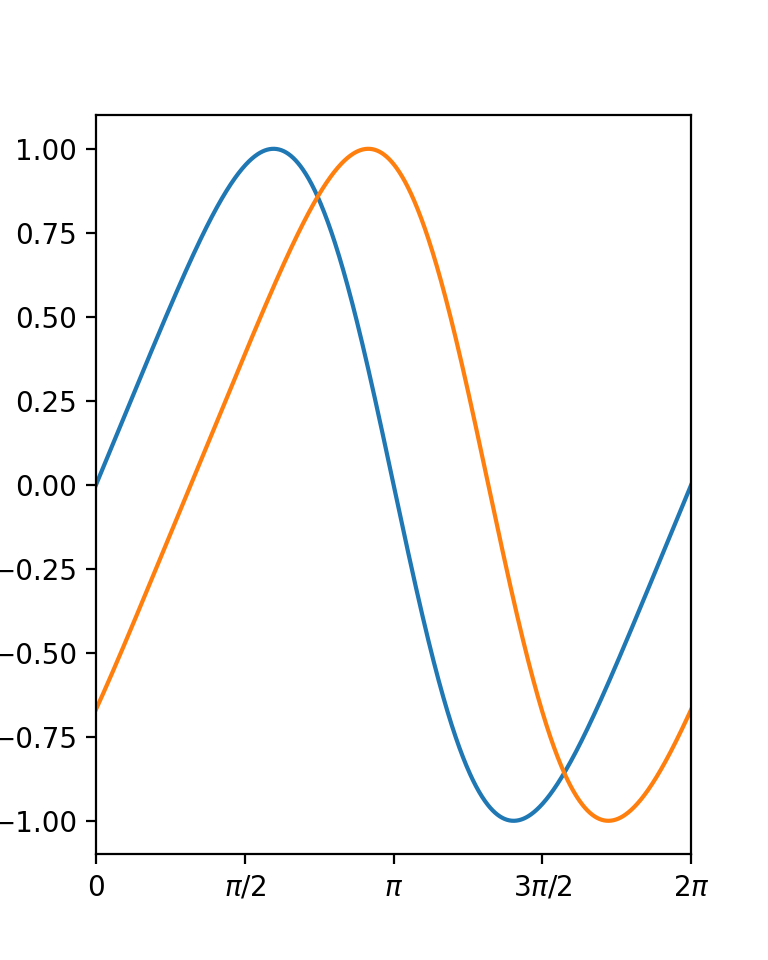

(0.0, 6.283185307179586)

In [20]:
dx, x = grid(1000, 1)
y, dy = ics_smooth(x)
plt.figure()
plt.plot(x, y)
plt.plot(x, ics_smooth(x, t=1)[0])
plt.xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi], ["0", r"$\pi$/2", r"$\pi$", r"3$\pi$/2", r"2$\pi$"])
plt.xlim(0, 2*np.pi)

<IPython.core.display.Javascript object>


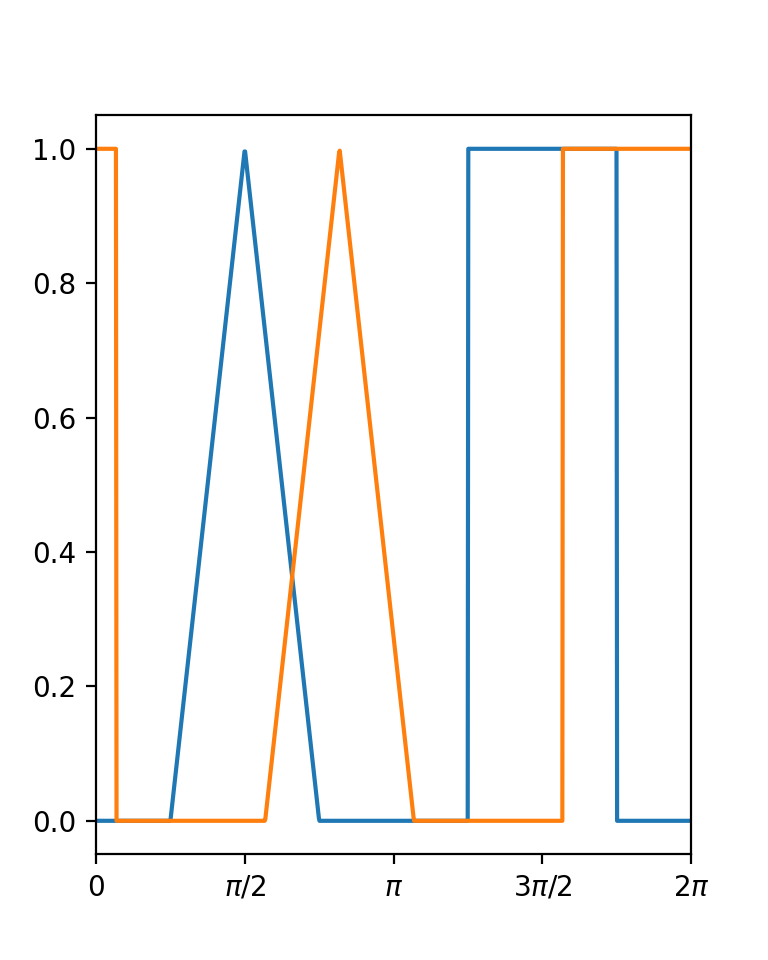

(0.0, 6.283185307179586)

In [21]:
dx, x = grid(1000, 1)
y, dy = ics_discontinuous(x)
plt.figure()
plt.plot(x, y)
plt.plot(x, ics_discontinuous(x, t=1)[0])
plt.xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi], ["0", r"$\pi$/2", r"$\pi$", r"3$\pi$/2", r"2$\pi$"])
plt.xlim(0, 2*np.pi)

In [23]:
N = 20
gz = 2
x, y2, dx, error2 = solve_and_errors(ssperk33, rhs_advection_2, N, gz)
x, y4, dx, error4 = solve_and_errors(ssperk104, rhs_advection_4, N, gz)

<IPython.core.display.Javascript object>


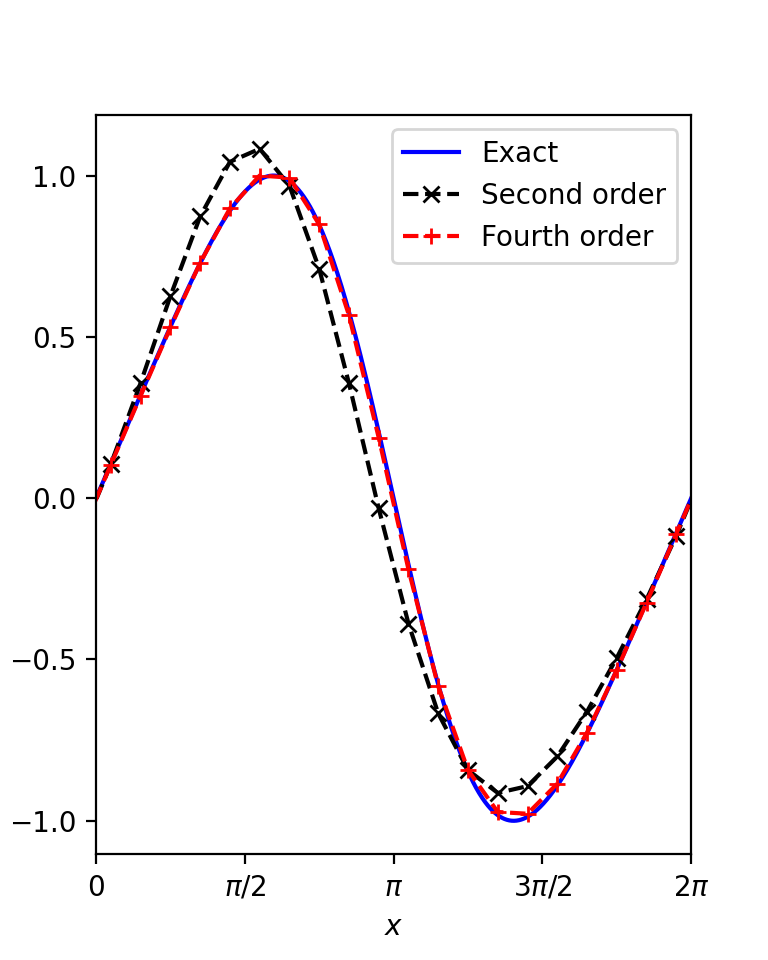

In [24]:
plt.figure()
_, x_exact = grid(1000, 1)
plt.plot(x_exact, ics_smooth(x_exact)[0], 'b-', label="Exact")
plt.plot(x, y2, 'kx--', label="Second order")
plt.plot(x, y4, 'r+--', label="Fourth order")
plt.xlim(0, 2*np.pi)
plt.xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi], ["0", r"$\pi$/2", r"$\pi$", r"3$\pi$/2", r"2$\pi$"])
plt.xlabel(r"$x$")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


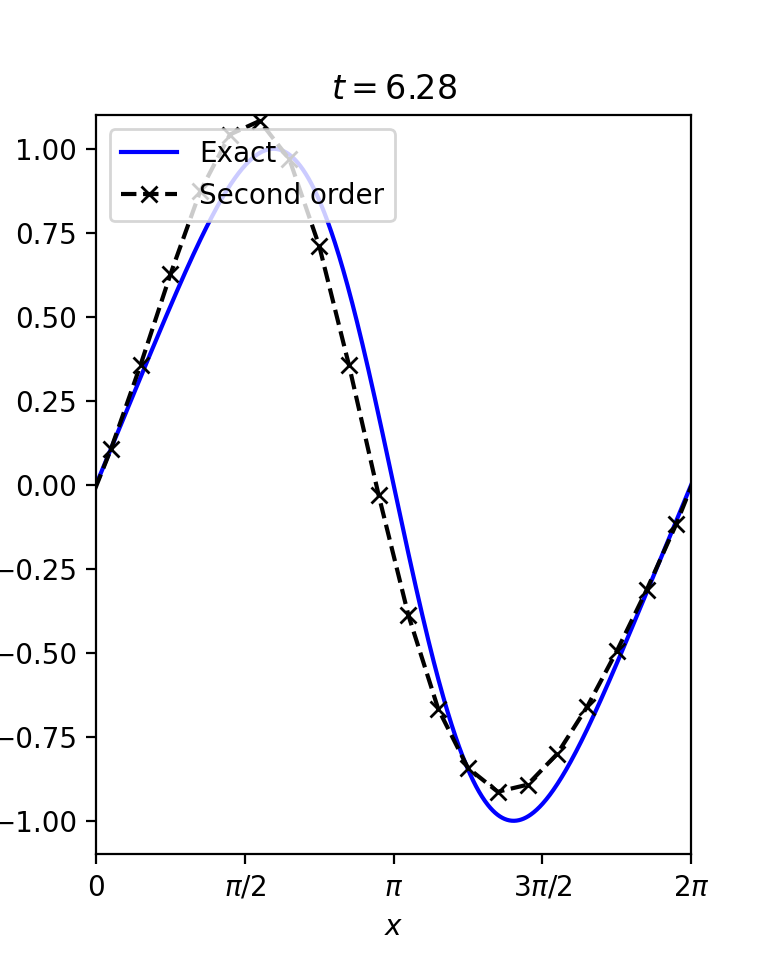

/Users/ih3/opt/anaconda3/lib/python3.8/site-packages/matplotlib/animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [26]:
anim=movie(ssperk33, rhs_advection_2, 20, 2, "Second order")
plt.show()

<IPython.core.display.Javascript object>


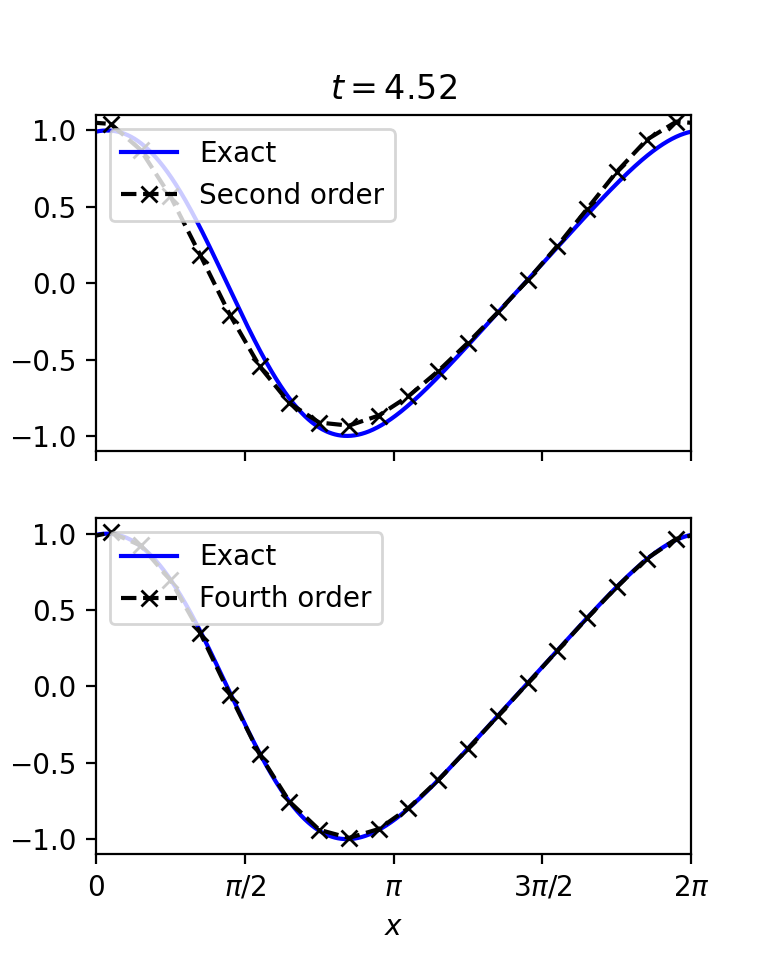

In [27]:
anim=movie2(ssperk104, [rhs_advection_2, rhs_advection_4], 20, 2, ["Second order", "Fourth order"], t_end=4*np.pi)
if save_plots:
    anim.save('figures/fd_compare.mp4')
plt.show()

Question: how does the error increase with time? Answer: linearly.

<IPython.core.display.Javascript object>


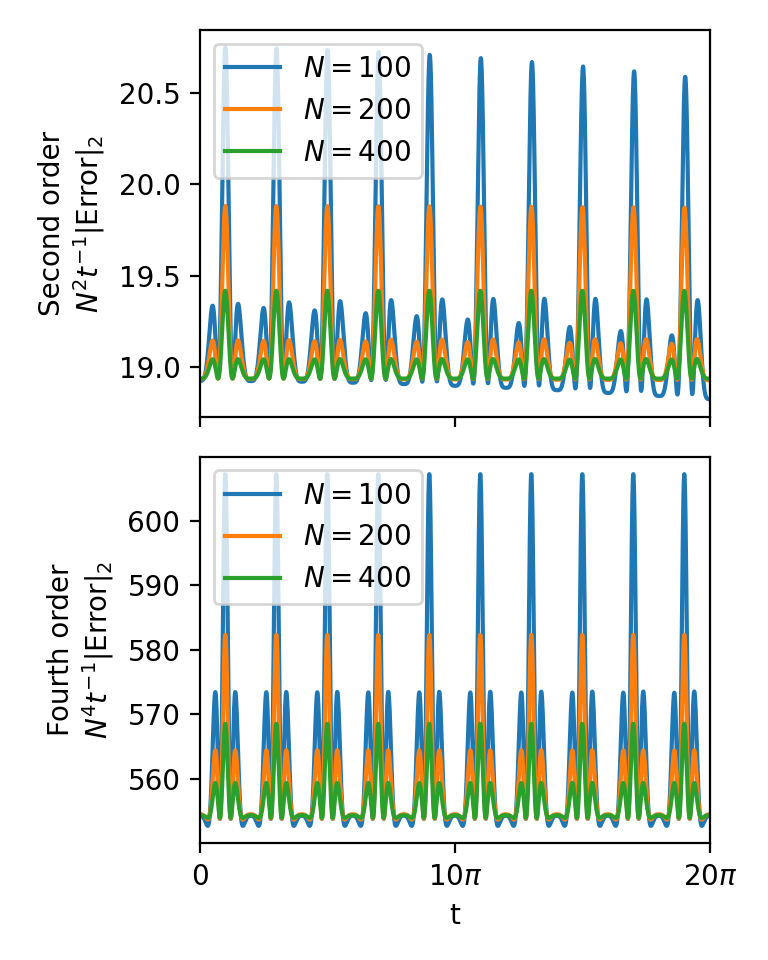

In [28]:
# This shows errors increasing linearly with time

fig, axes = plt.subplots(2, 1, sharex=True)
for N in [100, 200, 400]:
    ts2, errors2 = errors_over_time(ssperk33, rhs_advection_2, N, gz, t_end=20*np.pi)
    axes[0].plot(ts2[1:], errors2[1:]*N**2/ts2[1:], label=rf"$N={N}$")
    ts4, errors4 = errors_over_time(ssperk104, rhs_advection_4, N, gz, t_end=20*np.pi)
    axes[1].plot(ts4[1:], errors4[1:]*N**4/ts2[1:], label=rf"$N={N}$")
axes[1].set_xlabel("t")
axes[1].set_xlim(0, 20*np.pi)
axes[1].set_xticks([0, 10*np.pi, 20*np.pi], [r"$0$", r"$10\pi$", r"$20\pi$"])
axes[0].set_ylabel("Second order\n"+r"$N^2 t^{-1} \|$Error$\|_2$")
axes[1].set_ylabel("Fourth order\n"+r"$N^4 t^{-1} \|$Error$\|_2$")
for ax in axes.flatten():
    ax.legend(loc='upper left')
fig.tight_layout()
plt.show()

Question: how does the error at fixed end-time vary with the timestep (effectively the CFL)? Answer: very little, until the ODE solver is the limiting factor (and for FD methods that really doesn't happen until very high order or resolution). The following commented code will show that (it's slow).

In [ ]:
# cfls = 0.4*2.0**(-np.arange(1, 6))
# errors2 = np.zeros(len(cfls))
# errors4 = np.zeros(len(cfls))
# times2 = np.zeros(len(cfls))
# times4 = np.zeros(len(cfls))
# N = 400
# t_end = 4*np.pi
# for j, cfl in enumerate(tqdm.tqdm(cfls)):
#     x, y2, dx, error2 = solve_and_errors(ssperk33, rhs_advection_2, N, gz, cfl=cfl, t_end=t_end)
#     x, y4, dx, error4 = solve_and_errors(ssperk104, rhs_advection_4, N, gz, cfl=cfl, t_end=t_end)
#     errors2[j] = error2
#     errors4[j] = error4
#     times2[j] = timeit.timeit(f"time_kernel(ssperk33, rhs_advection_2, {N}, {gz}, cfl={cfl}, t_end={t_end})",
#                              globals=globals(), number=4)
#     times4[j] = timeit.timeit(f"time_kernel(ssperk104, rhs_advection_4, {N}, {gz}, cfl={cfl}, t_end={t_end})",
#                              globals=globals(), number=4)

# p2 = np.polyfit(np.log(cfls), np.log(errors2), 1)
# p4 = np.polyfit(np.log(cfls), np.log(errors4), 1)
# p2_cost = np.polyfit(np.log(times2), np.log(errors2), 1)
# p4_cost = np.polyfit(np.log(times4), np.log(errors4), 1)

# print(times4, errors4)

If we do a high-resolution spectral run so the solver is limited by the timestep, we do see improvements by reducing the CFL. Balancing this against the increase in cost is not easy.

In [ ]:
cfls = 0.4*2.0**(-np.arange(1, 6))
errors_spectral = np.zeros(len(cfls))
times_spectral = np.zeros(len(cfls))
N = 101
t_end = 4*np.pi
for j, cfl in enumerate(tqdm.tqdm(cfls)):
    x, y_s, dx, error_s = solve_and_errors(ssperk104, rhs_spectral, N, 0, cfl=cfl, t_end=t_end, generator_arg='N')
    errors_spectral[j] = error_s
    times_spectral[j] = timeit.timeit(f"time_kernel(ssperk104, rhs_spectral, {N}, 0, cfl={cfl}, t_end={t_end}, generator_arg='N')",
                             globals=globals(), number=4)
    
p_spectral = np.polyfit(np.log(cfls[:-1]), np.log(errors_spectral[:-1]), 1)
p_spectral_cost = np.polyfit(np.log(times_spectral[:-1]), np.log(errors_spectral[:-1]), 1)

print(times_spectral, errors_spectral)

In [ ]:
fig, axes = plt.subplots(2, 1)
axes[0].loglog(cfls, errors_spectral, 'go', label="Spectral")
axes[0].loglog(cfls[:-1], np.exp(p_spectral[1])*cfls[:-1]**(p_spectral[0]), 'g--', label=rf"$\propto (\Delta t / \Delta x)^{{{p_spectral[0]:.1f}}}$")
axes[0].legend()
axes[0].set_xlabel(r"$\Delta t / \Delta x$")
axes[0].set_ylabel(r"$\|$Error$\|_2$")
axes[1].loglog(times_spectral, errors_spectral, 'go', label='Spectral')
axes[1].loglog(times_spectral[:-1], np.exp(p_spectral_cost[1])*times_spectral[:-1]**p_spectral_cost[0], 'g--', label=rf"$\propto t^{{{p_spectral_cost[0]:.1f}}}$")
axes[1].legend()
axes[1].set_xlabel(r"Time [s]")
axes[1].set_ylabel(r"$\|$Error$\|_2$")
fig.tight_layout()
plt.show()

In [ ]:
plt.close('all')

## Finite differencing convergence plots

In [ ]:
Ns_fd = 2**np.arange(5, 10)
errors2 = np.zeros(len(Ns_fd))
errors4 = np.zeros(len(Ns_fd))
times2 = np.zeros(len(Ns_fd))
times4 = np.zeros(len(Ns_fd))
dxs_fd = np.zeros_like(errors2)
cfl = 0.4
t_end = 4*np.pi
for j, N in enumerate(tqdm.tqdm(Ns_fd)):
    x, y2, dx, error2 = solve_and_errors(ssperk33, rhs_advection_2, N, gz, t_end=t_end)
    x, y4, dx, error4 = solve_and_errors(ssperk104, rhs_advection_4, N, gz, t_end=t_end)
    dxs_fd[j] = dx
    errors2[j] = error2
    errors4[j] = error4
    times2[j] = timeit.timeit(f"time_kernel(ssperk33, rhs_advection_2, {N}, {gz}, t_end={t_end})",
                             globals=globals(), number=4)
    times4[j] = timeit.timeit(f"time_kernel(ssperk104, rhs_advection_4, {N}, {gz}, t_end={t_end})",
                             globals=globals(), number=4)

p2 = np.polyfit(np.log(Ns_fd), np.log(errors2), 1)
p4 = np.polyfit(np.log(Ns_fd), np.log(errors4), 1)
p2_cost = np.polyfit(np.log(times2), np.log(errors2), 1)
p4_cost = np.polyfit(np.log(times4), np.log(errors4), 1)

In [ ]:
fig, axes = plt.subplots(2, 1)
axes[0].loglog(Ns_fd, errors2, 'bx', label="Second order")
axes[0].loglog(Ns_fd, np.exp(p2[1])*Ns_fd**(-2.0), 'b--', label=r"$\propto N^{-2}$")
axes[0].loglog(Ns_fd, errors4, 'r+', label="Fourth order")
axes[0].loglog(Ns_fd, np.exp(p4[1])*Ns_fd**(-4.0), 'r--', label=r"$\propto N^{-4}$")
axes[0].legend()
axes[0].set_xlabel(r"$N$")
axes[0].set_ylabel(r"$\|$Error$\|_2$")
axes[1].loglog(times2, errors2, 'bx', label='Second order')
axes[1].loglog(times2, np.exp(p2_cost[1])*times2**p2_cost[0], 'b--', label=rf"$\propto t^{{{p2_cost[0]:.1f}}}$")
axes[1].loglog(times4, errors4, 'r+', label='Fourth order')
axes[1].loglog(times4, np.exp(p4_cost[1])*times4**p4_cost[0], 'r--', label=rf"$\propto t^{{{p4_cost[0]:.1f}}}$")
axes[1].legend()
axes[1].set_xlabel(r"Time [s]")
axes[1].set_ylabel(r"$\|$Error$\|_2$")
fig.tight_layout()
if save_plots:
    fig.savefig('figures/fd_costs.svg', bbox_inches='tight')
plt.show()

## Spectral

Spectral derivatives converge quickly.

In [ ]:
Ns_deriv_spectral = np.arange(8, 30, 2)+1
errors_deriv_spectral = np.zeros(len(Ns_deriv_spectral))
for j, N in enumerate(Ns_deriv_spectral):
    dx, x = grid(N, 0)
    y, dy = ics_smooth(x)
    D = setup_spectral_D(N)
    errors_deriv_spectral[j] = np.sqrt(dx) * np.linalg.norm(D@y - dy, 2)

Ns_deriv_fd = 2**np.arange(5, 10)
errors_deriv_fd2 = np.zeros(len(Ns_deriv_fd))
errors_deriv_fd4 = np.zeros(len(Ns_deriv_fd))
for j, N in enumerate(Ns_deriv_fd):
    dx, x = grid(N, 2)
    y, dy = ics_smooth(x)
    errors_deriv_fd2[j] = np.sqrt(dx) * np.linalg.norm(rhs_advection_2(dx)(y) + dy, 2)
    errors_deriv_fd4[j] = np.sqrt(dx) * np.linalg.norm(rhs_advection_4(dx)(y) + dy, 2)

p_deriv_spectral = np.polyfit(Ns_deriv_spectral[:-3], np.log(errors_deriv_spectral[:-3]), 1)

In [ ]:
fig, axes = plt.subplots(2, 1)


axes[0].loglog(Ns_deriv_fd, errors_deriv_fd2, 'kx')
axes[0].loglog(Ns_deriv_fd, errors_deriv_fd2[0]*(Ns_deriv_fd/Ns_deriv_fd[0])**(-2.0), 'k--', label=r"$\propto N^{-2}$")
axes[0].loglog(Ns_deriv_fd, errors_deriv_fd4, 'r+')
axes[0].loglog(Ns_deriv_fd, errors_deriv_fd4[0]*(Ns_deriv_fd/Ns_deriv_fd[0])**(-4.0), 'r--', label=r"$\propto N^{-4}$")
axes[0].loglog(2*Ns_deriv_spectral, errors_deriv_spectral, 'go', label='Spectral')
axes[1].semilogy(2*Ns_deriv_spectral, errors_deriv_spectral, 'go', label='Spectral')
axes[1].semilogy(2*Ns_deriv_spectral[:-3], np.exp(p_deriv_spectral[1]+Ns_deriv_spectral[:-3]*p_deriv_spectral[0]), 
                 'g--', label=rf"$\sim e^{{{p_deriv_spectral[0]:.1f}N}}$")
axes[0].set_ylabel(r"$\|$Error$\|_2$")
axes[1].set_ylabel(r"$\|$Error$\|_2$")
axes[0].legend(loc='lower right')
axes[1].legend()
for ax in axes.flatten():
    ax.set_xlabel(r"$N$")
fig.tight_layout()
if save_plots:
    fig.savefig('figures/spectral_deriv.svg', bbox_inches='tight')
plt.show()

But the evolution can be limited by other factors.

In [ ]:
dx, x = grid(5, 0)
y, dy = ics_smooth(x)
rhs = rhs_spectral(5)
dydt = rhs(y)

In [ ]:
Ns_fd = 2**np.arange(5, 10)
Ns_spectral = 2**np.arange(2, 7) + 1
errors2 = np.zeros(len(Ns_fd))
errors4 = np.zeros(len(Ns_fd))
errors_spectral = np.zeros(len(Ns_spectral))
times2 = np.zeros(len(Ns_fd))
times4 = np.zeros(len(Ns_fd))
times_spectral = np.zeros(len(Ns_spectral))
cfl = 0.4
t_end = 4*np.pi
gz = 2
for j, N in enumerate(tqdm.tqdm(Ns_fd)):
    x, y2, dx, error2 = solve_and_errors(ssperk33, rhs_advection_2, N, gz, t_end=t_end)
    x, y4, dx, error4 = solve_and_errors(ssperk104, rhs_advection_4, N, gz, t_end=t_end)
    errors2[j] = error2
    errors4[j] = error4
    times2[j] = timeit.timeit(f"time_kernel(ssperk33, rhs_advection_2, {N}, {gz}, t_end={t_end})",
                             globals=globals(), number=4)
    times4[j] = timeit.timeit(f"time_kernel(ssperk104, rhs_advection_4, {N}, {gz}, t_end={t_end})",
                             globals=globals(), number=4)

for j, N in enumerate(tqdm.tqdm(Ns_spectral)):
    x, y_s, dx, error_s = solve_and_errors(ssperk104, rhs_spectral, N, 0, t_end=t_end, generator_arg='N')
    errors_spectral[j] = error_s
    times_spectral[j] = timeit.timeit(f"time_kernel(ssperk104, rhs_spectral, {N}, 0, t_end={t_end}, generator_arg='N')",
                             globals=globals(), number=4)
    
p2 = np.polyfit(np.log(Ns_fd), np.log(errors2), 1)
p4 = np.polyfit(np.log(Ns_fd), np.log(errors4), 1)
p_spectral = np.polyfit(np.log(Ns_spectral), np.log(errors_spectral), 1)
p2_cost = np.polyfit(np.log(times2), np.log(errors2), 1)
p4_cost = np.polyfit(np.log(times4), np.log(errors4), 1)
p_spectral_cost = np.polyfit(np.log(times_spectral), np.log(errors_spectral), 1)

In [ ]:
fig, axes = plt.subplots(2, 1)
axes[0].loglog(Ns_fd, errors2, 'bx')#, label="Second order")
axes[0].loglog(Ns_fd, np.exp(p2[1])*Ns_fd**(-2.0), 'b--', label=r"$2^{\mathrm{nd}}, \propto N^{-2}$")
axes[0].loglog(Ns_fd, errors4, 'r+')#, label="Fourth order")
axes[0].loglog(Ns_fd, np.exp(p4[1])*Ns_fd**(-4.0), 'r--', label=r"$4^{\mathrm{th}}, \propto N^{-4}$")
axes[0].loglog(Ns_spectral, errors_spectral, 'go')#, label="Spectral")
axes[0].loglog(Ns_spectral, np.exp(p_spectral[1])*Ns_spectral**(-4.0), 'g--', label=r"Spectral, $\propto N^{-4}$")
axes[0].set_xlabel(r"$N$")
axes[0].set_ylabel(r"$\|$Error$\|_2$")

axes[0].text(Ns_fd[0], 0.02*errors2[0], r"$2^{\mathrm{nd}}, \propto N^{-2}$", color='b', rotation=-18)
axes[0].text(Ns_fd[2], 0.05*errors4[2], r"$4^{\mathrm{th}}, \propto N^{-4}$", color='r', rotation=-35)
axes[0].text(Ns_spectral[0], 0.01*errors_spectral[0], r"Spectral, $\propto N^{-4}$", color='g', rotation=-35)

axes[1].loglog(times2, errors2, 'bx')#, label='Second order')
axes[1].loglog(times2, np.exp(p2_cost[1])*times2**p2_cost[0], 'b--', label=rf"$2^{{\mathrm{{nd}}}}, \propto t^{{{p2_cost[0]:.1f}}}$")
axes[1].loglog(times4, errors4, 'r+')#, label='Fourth order')
axes[1].loglog(times4, np.exp(p4_cost[1])*times4**p4_cost[0], 'r--', label=rf"$4^{{\mathrm{{th}}}}, \propto t^{{{p4_cost[0]:.1f}}}$")
axes[1].loglog(times_spectral, errors_spectral, 'go')#, label='Spectral')
axes[1].loglog(times_spectral, np.exp(p_spectral_cost[1])*times_spectral**p_spectral_cost[0], 'g--', 
               label=rf"Spectral, $\propto t^{{{p_spectral_cost[0]:.1f}}}$")
axes[1].set_xlabel(r"Time [s]")
axes[1].set_ylabel(r"$\|$Error$\|_2$")

axes[1].text(times2[2], 0.2*errors2[2], rf"$2^{{\mathrm{{nd}}}}, \propto t^{{{p2_cost[0]:.1f}}}$", color='b', rotation=-18)
axes[1].text(times4[2], 0.02*errors4[2], rf"$4^{{\mathrm{{th}}}}, \propto t^{{{p4_cost[0]:.1f}}}$", color='r', rotation=-40)
axes[1].text(times_spectral[0], 0.003*errors_spectral[0], rf"Spectral, $\propto t^{{{p_spectral_cost[0]:.1f}}}$", color='g', rotation=-40)

fig.tight_layout()
if save_plots:
    fig.savefig('figures/spectral_costs.svg', bbox_inches='tight')
plt.show()

In [ ]:
plt.close('all')

## Discontinuous data

Gibbs' oscillations are an issue here.

In [ ]:
x_exact = np.linspace(0, 2*np.pi, 1000)
y_exact, dy_exact = ics_discontinuous(x_exact)

fig, axes = plt.subplots(3, 1, sharex=True)

axes[0].plot(x_exact, y_exact, 'b-', label='Exact')
axes[0].set_xlim(0, 2*np.pi)
axes[0].set_ylim(-0.1, 1.1)
axes[0].set_ylabel(r"$y$")
Ns = [41, 101]
for j, N in enumerate(Ns):
    ax = axes[j+1]
    ax.plot(x_exact, dy_exact, 'b-', label='Exact')
    dx, x = grid(N, 0)
    D = setup_spectral_D(N)
    y, dy = ics_discontinuous(x)
    ax.plot(x, -rhs_advection_2(dx)(y), 'r--', label='FD')
    ax.plot(x, D@y, 'k:', label='Spectral')
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylabel(rf"$N={N}: \partial_x y$")
    ax.set_ylim(-2, 2)
    
axes[2].set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi], ["0", r"$\pi$/2", r"$\pi$", r"3$\pi$/2", r"2$\pi$"])
# axes[2].set_xlabel(r"$x$")
axes[2].legend(bbox_to_anchor=(-0.02, -0.5), loc='lower left', ncol=3)
fig.tight_layout()
if save_plots:
    fig.savefig('figures/gibbs1.svg', bbox_inches='tight')
plt.show()

We usually get around this problem by thinking about the weak form and shifting to finite volume methods:

In [ ]:
# Fluxes, telescoping
fig, axes = plt.subplots(3, 1)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks(np.arange(-1, 1+0.01, 1))
    ax.set_yticks([])
    ax.set_xticklabels([r"$x_{i-1}$", r"$x_{i}$", r"$x_{i+1}$", ])
    ax.set_yticklabels([])

f = lambda x: np.where(x < -0.2,
                        np.exp(np.sin(x/3)),
                        np.cos(x/2))    

for num in np.arange(-2, 3, 2):
    axes[0].axvline(x=0.5+num/2, ymin=0, ymax=0.9, color='b', ls='--', lw=1)
x_left = np.linspace(-1.2, -0.2-1e-8)
x_right = np.linspace(-0.2+1e-8, 1.2)
axes[0].plot(x_left, f(x_left), 'k-', lw=2)
axes[0].plot(x_right, f(x_right), 'k-', lw=2)
axes[0].plot([-0.2, -0.2], [f(x_left[-1]), f(x_right[0])], 'k:', lw=2)
axes[0].set_xlim(-1.2, 1.2)
axes[0].set_ylim(0.6, 1.1)


for num in np.arange(-2, 3, 2):
    axes[1].axvline(x=0.5+num/2, ymin=0, ymax=0.9, color='b', ls='--', lw=1)
axes[1].plot([-1.5, -0.5],
             f(np.array([-1, -1])),
             'k-', lw=3)
axes[1].plot([-0.5, 0.5],
             f(np.array([0, 0])),
             'k-', lw=3)
axes[1].plot([0.5, 1.5],
             f(np.array([1, 1])),
             'k-', lw=3)
axes[1].set_xlim(-1.2, 1.2)
axes[1].set_ylim(0.6, 1.1)


for num in np.arange(-2, 3, 2):
    axes[2].axvline(x=0.5+num/2, ymin=0, ymax=0.9, color='b', ls='--', lw=1)
axes[2].plot([-1.5, -0.5],
             f(np.array([-1, -1])),
             'k-', lw=3)
axes[2].plot([-0.5, 0.5],
             f(np.array([0, 0])),
             'k-', lw=3)
axes[2].plot([0.5, 1.5],
             f(np.array([1, 1])),
             'k-', lw=3)
axes[2].annotate(r"$f_{i-1/2}$", xy=[-0.65, 0.8], xytext=[-0.35, 0.8],
                verticalalignment='center',
                arrowprops=dict(arrowstyle='<|-', color='k', ls='-', lw=3))
axes[2].annotate(r"$f_{i+1/2}$", xy=[0.35, 0.8], xytext=[0.65, 0.8],
                verticalalignment='center',
                arrowprops=dict(arrowstyle='<|-', color='k', ls='-', lw=3))
axes[2].set_xlim(-1.2, 1.2)
axes[2].set_ylim(0.6, 1.1)

fig.tight_layout()

if save_plots:
    fig.savefig('figures/weak_solutions1.svg', bbox_inches='tight')

But using adaptive algorithms (slope limiting, PPM, WENO, etc) we can reconstruct low regularity data without oscillations.

In [ ]:
x_exact = np.linspace(0, 2*np.pi, 1000)
y_exact, dy_exact = ics_discontinuous(x_exact)

for N in [21, 81]:
    dx, x = grid(N, 0)
    y, dy = ics_discontinuous(x)

    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(2, 2)
    ax_main = fig.add_subplot(gs[0, :])
    ax1 = fig.add_subplot(gs[1, 0])
    ax2 = fig.add_subplot(gs[1, 1])
    for ax in [ax_main, ax1, ax2]:
        ax.plot(x_exact, y_exact, 'k-', label="Exact")
        ax.plot(x+dx/2, reconstruction_fd(2, y), 'ro--', label="Central")
        ax.plot(x+dx/2, weno(3, y), 'bx--', label="WENO")
        ax.set_yticks([])
    ax_main.set_xlim(0, 2*np.pi)
    ax_main.set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi], ["0", r"$\pi$/2", r"$\pi$", r"3$\pi$/2", r"2$\pi$"])
    ax_main.legend(loc='upper left')
    ax1.set_xlim(0.6*np.pi, 0.9*np.pi)
    ax1.set_ylim(-0.05, 0.2)
    ax2.set_xlim(1.1*np.pi, 1.4*np.pi)
    for ax in [ax1, ax2]:
        ax.set_xlabel(r"$x$")
    if save_plots:
        fig.savefig(f"figures/recon{N}.svg", bbox_inches='tight')
    plt.show()

The evolution with WENO works; with other methods, the oscillations just spread.

In [ ]:
x_exact = np.linspace(0, 2*np.pi, 1000)
y_exact, dy_exact = ics_discontinuous(x_exact)

Ns = [100, 400]
fig, axes = plt.subplots(2, 1, sharex=True)
plt.subplots_adjust(hspace=0.01)
for j, N in enumerate(Ns):
    x, y4, dx, error4 = solve_and_errors(ssperk104, rhs_advection_4, N, gz, ics=ics_discontinuous)
    xw, yw, dx, errorw = solve_and_errors(ssperk104, rhs_advection_weno, N, 4, ics=ics_discontinuous)
    
    
    axes[j].plot(x_exact, y_exact, 'k-', label="Exact")
    axes[j].plot(x, y4, 'b--', label='Fourth order')
    axes[j].plot(xw, yw, 'r--', label="WENO")
    axes[j].legend(loc='upper left')
    axes[j].set_xlim(0, 2*np.pi)
    axes[j].set_ylim(-0.25, 1.25)
    axes[j].set_ylabel(rf"$N=${N}")
    axes[j].set_yticks([0, 0.5, 1], ["0.0", "0.5", "1.0"])

axes[-1].set_xlabel(r"$x$")
axes[-1].set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi], ["0", r"$\pi$/2", r"$\pi$", r"3$\pi$/2", r"2$\pi$"])
fig.tight_layout()
if save_plots:
    fig.savefig('figures/gibbs2.svg', bbox_inches='tight')
plt.show()

But for smooth solutions the cost is prohibitive.

In [ ]:
Ns_fd = 2**np.arange(5, 10)
errors4 = np.zeros(len(Ns_fd))
errorsw = np.zeros(len(Ns_fd))
times4 = np.zeros(len(Ns_fd))
timesw = np.zeros(len(Ns_fd))
cfl = 0.4
t_end = 4*np.pi
for j, N in enumerate(tqdm.tqdm(Ns_fd)):
    x, y4, dx, error4 = solve_and_errors(ssperk104, rhs_advection_4, N, 2, t_end=t_end)
    x, y4, dx, errorw = solve_and_errors(ssperk104, rhs_advection_weno, N, 4, t_end=t_end)
    errors4[j] = error4
    errorsw[j] = errorw
    times4[j] = timeit.timeit(f"time_kernel(ssperk104, rhs_advection_4, {N}, 2, t_end={t_end})",
                             globals=globals(), number=4)
    timesw[j] = timeit.timeit(f"time_kernel(ssperk104, rhs_advection_weno, {N}, 4, t_end={t_end})",
                             globals=globals(), number=4)

p4 = np.polyfit(np.log(Ns_fd), np.log(errors4), 1)
pw = np.polyfit(np.log(Ns_fd), np.log(errorsw), 1)
p4_cost = np.polyfit(np.log(times4), np.log(errors4), 1)
pw_cost = np.polyfit(np.log(timesw), np.log(errorsw), 1)

In [ ]:
fig, axes = plt.subplots(2, 1)
axes[0].loglog(Ns_fd, errors4, 'r+', label="Fourth order")
axes[0].loglog(Ns_fd, np.exp(p4[1])*Ns_fd**(-4.0), 'r--', label=r"$\propto N^{-4}$")
axes[0].loglog(Ns_fd, errorsw, 'k^', label="WENO")
axes[0].loglog(Ns_fd, np.exp(pw[1])*Ns_fd**(-4.0), 'k--', label=r"$\propto N^{-4}$")
axes[0].legend()
axes[0].set_xlabel(r"$N$")
axes[0].set_ylabel(r"$\|$Error$\|_2$")
axes[1].loglog(times4, errors4, 'r+', label='Fourth order')
axes[1].loglog(times4, np.exp(p4_cost[1])*times4**p4_cost[0], 'r--', label=rf"$\propto t^{{{p4_cost[0]:.1f}}}$")
axes[1].loglog(timesw, errorsw, 'k^', label='WENO')
axes[1].loglog(timesw, np.exp(pw_cost[1])*timesw**pw_cost[0], 'k--', label=rf"$\propto t^{{{pw_cost[0]:.1f}}}$")
axes[1].legend()
axes[1].set_xlabel(r"Time [s]")
axes[1].set_ylabel(r"$\|$Error$\|_2$")
fig.tight_layout()
if save_plots:
    fig.savefig('figures/weno_cost.svg', bbox_inches='tight')
plt.show()

In [ ]:
plt.close('all')

## Nonlinear

In [ ]:
def rhs_burgers_2(dx):
    def rhs(y):
        dydt = np.zeros_like(y)
        dydt[2:-2] = -y[2:-2] * (y[3:-1] - y[1:-3]) / (2*dx)
        dydt[0] = dydt[-4]
        dydt[1] = dydt[-3]
        dydt[-2] = dydt[2]
        dydt[-1] = dydt[3]
        return dydt
    return rhs

def rhs_burgers_4(dx):
    def rhs(y):
        dydt = np.zeros_like(y)
        dydt[2:-2] = -y[2:-2] * (-y[4:] + 8*y[3:-1] - 8*y[1:-3] + y[:-4]) / (12*dx)
        dydt[0] = dydt[-4]
        dydt[1] = dydt[-3]
        dydt[-2] = dydt[2]
        dydt[-1] = dydt[3]
        return dydt
    return rhs

def rhs_burgers_weno(dx, order=3):
    def rhs(y):
        dydt = np.zeros_like(y)
        flux = np.zeros_like(y)
        f = y**2/2
        alpha = np.max(np.abs(y))
        fp = (f + alpha * y) / 2
        fm = (f - alpha * y) / 2
        fpr = np.zeros_like(y)
        fml = np.zeros_like(y)
        fpr[1:] = weno(order, fp[:-1])
        fml[-1::-1] = weno(order, fm[-1::-1])
        flux[1:-1] = fpr[1:-1] + fml[1:-1]
        dydt[1:-1] = (flux[1:-1] - flux[2:]) / dx
        for k in range(order+1):
            dydt[k] = dydt[-(2*(order+1)-k)]
            dydt[-(k+1)] = dydt[2*(order+1)-k-1]
        return dydt
    return rhs

def rhs_burgers_weno_n(n=2):
    def rhs_burgers_weno(dx, order=3):
        def rhs(y):
            dydt = np.zeros_like(y)
            flux = np.zeros_like(y)
            f = y**((n+1)/n)/((n+1)/n)
            alpha = np.max(np.abs(y)**(1/n))
            fp = (f + alpha * y) / 2
            fm = (f - alpha * y) / 2
            fpr = np.zeros_like(y)
            fml = np.zeros_like(y)
            fpr[1:] = weno(order, fp[:-1])
            fml[-1::-1] = weno(order, fm[-1::-1])
            flux[1:-1] = fpr[1:-1] + fml[1:-1]
            dydt[1:-1] = (flux[1:-1] - flux[2:]) / dx
            for k in range(order+1):
                dydt[k] = dydt[-(2*(order+1)-k)]
                dydt[-(k+1)] = dydt[2*(order+1)-k-1]
            return dydt
        return rhs
    return rhs_burgers_weno

In [ ]:
# anim=movie(ssperk33, rhs_burgers_2, 100, 4, "Second order", t_end=2, ics=ics_discontinuous)
anim=movie(ssperk33, rhs_burgers_weno, 100, 4, "WENO", t_end=2, ics=ics_discontinuous)
plt.show()

In [ ]:
def ics_gauss(x, a=0.0, b=2*np.pi, t=0):
    L = b - a
    V = 2
    y = 0.9*np.exp(-((x-a-L/2)*8/L)**2)+0.1
    dy = np.zeros_like(x)
    return y, dy

def ics_shock(x, a=0.0, b=2*np.pi, t=0):
    L = b - a
    V = 2
    jump = a + L / 2 + V * t
    y = np.where(x < jump, 3*np.ones_like(x), np.ones_like(x))
    dy = np.zeros_like(x)
    return y, dy

We are comparing
$$
\partial_t q + \partial_x (q^2 / 2) = 0
$$
with
$$
\partial_t Q + \frac{n}{n+1} \partial_x Q^{(n+1)/n} = 0
$$
which should be the same thing if $Q = q^n$. Doing the re-map is a pain.

In [ ]:
# Assuming all are FD methods

def movie_compare_burgers_n(n, N, gz, cfl=0.4, t_end=2*np.pi, a=0.0, b=2*np.pi, ics=ics_smooth, legend_loc='upper left'):
    dx, x = grid(N, gz, a, b)
    y0, dy = ics(x, a, b)
    y = y0.copy()
    dt = cfl * dx
    Nframes = int(t_end / dt)+1
    colors='kr'
    markers='x+'
    stepper=ssperk33
    
    class Mov:
        def __init__(self, axes):
            self.axes = axes
            self.x = x
            self.y = [y0.copy(), y0.copy()**n]
            self.dt = cfl * dx
            self.stepper = stepper
            self.rhs = [rhs_burgers_weno(dx), rhs_burgers_weno_n(n)(dx)]
            self.t = 0
            self.t_end = t_end
            self.ics = ics
            self.lines = []
            self.lines_compare = []

            lines, = axes[0].plot(x, self.y[0], color=colors[0], marker=markers[0], label="WENO")
            self.lines.append(lines)
            lines, = axes[0].plot(x, self.y[1]**(1/n), color=colors[1], marker=markers[1], label=f"WENO ($n={n}$)")
            self.lines.append(lines)
            lines_compare, = axes[1].plot(x, self.y[1]-self.y[0]**(1/n), 'b--', label="Difference")
            self.lines_compare.append(lines_compare)
            for j, ax in enumerate(self.axes.flatten()):
                ax.set_xlim(0, 2*np.pi)
                ax.legend(loc=legend_loc)
            self.axes[1].set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi], ["0", r"$\pi$/2", r"$\pi$", r"3$\pi$/2", r"2$\pi$"])
            self.axes[1].set_xlabel(r"$x$")
            self.axes[1].set_ylim(-0.1, 0.1)
            self.time_text = self.axes[0].set_title(r"$t=0$")

        def update(self, i):
            if self.t+self.dt > self.t_end:
                self.dt = self.t_end - self.t
            self.t += self.dt
            for j in range(len(self.y)):#y, rhs in zip(self.y, self.rhs):
                self.y[j] = self.stepper(self.rhs[j], self.y[j], self.dt)
            self.lines[0].set_data(self.x, self.y[0])
            self.lines[1].set_data(self.x, self.y[1]**(1/n))
            self.lines_compare[0].set_data(self.x, self.y[0]-self.y[1]**(1/n))
            self.time_text.set_text(rf"$t={self.t:.2f}$")
            return self.lines_compare, self.lines, self.time_text

    fig, axes = plt.subplots(2, 1, sharex=True)
    mov = Mov(axes)

    anim = animation.FuncAnimation(fig, mov.update, interval=100, blit=True, frames=Nframes)
    return anim

In [ ]:
anim=movie_compare_burgers_n(5, 100, 4,  
            t_end=0.5, ics=ics_gauss, cfl=0.25, legend_loc='lower left')
if save_plots:
    anim.save('figures/burgers_n_smooth.mp4')
plt.show()

No re-mapping needed for the shock solution, as it's the shock speed we care about.

In [ ]:
anim=movie2(ssperk33, [rhs_burgers_weno, rhs_burgers_weno_n(5)], 100, 4, ["WENO", "WENO, $n=5$"], 
            t_end=1, ics=ics_shock, cfl=0.25, legend_loc='lower left')
if save_plots:
    anim.save('figures/burgers_n_shock.mp4')
plt.show()

In [ ]:
plt.close('all')

## AMR

Re-creating the figure from the Carpet paper.

In [ ]:
fig, axes = plt.subplots(2, 1)

grid0 = [[0, 1], [0, 1], (8, 6), (6/7, 0.2)]
grid10 = [[1/7, 4/7], [1/5, 4/5], (7, 7), (3/14, 0.7)]
grid11 = [[5/7, 6/7], [5/10, 4/5], (3, 4), (11/14, 0.6)]
grid22 = [[7/28, 14/28], [3/10, 6/10], (8, 7), (5/14, 0.45)]
grids = [[grid0], [grid10, grid11], [grid22]]

colors = 'bgr'
lss = ['-', '--', ':']

for il, level in enumerate(grids):
    for ig, g in enumerate(level):
        xs = np.linspace(g[0][0], g[0][1], g[2][0])
        ys = np.linspace(g[1][0], g[1][1], g[2][1])
        for x in xs:
            axes[0].plot(x*np.ones_like(ys), ys, color=colors[il], ls=lss[il])
        for y in ys:
            axes[0].plot(xs, y*np.ones_like(xs), color=colors[il], ls=lss[il])
        axes[0].text(g[3][0], g[3][1], rf"$G^{{{il}}}_{{{ig}}}$", color=colors[il], va='center', ha='center',
                     bbox=dict(boxstyle='round', facecolor='white', edgecolor='white', alpha=0.9))

        
mpl_g_solid = (0, 0.5, 0, 1)
mpl_g_clear = (0, 0.5, 0, 0)
dxc = 1/4
xc = np.arange(0, 1+dxc, dxc)
xf = np.arange(xc[2]-dxc/2, 1+dxc/2, dxc/2)
axes[1].plot(xc, 0.1*np.ones_like(xc), 'bx-', ms=8, mew=2)
axes[1].plot(xf[:2], 0.1*np.ones_like(xf[:2]), 'o--', color="g", markerfacecolor=mpl_g_clear, markeredgecolor=mpl_g_solid)
axes[1].plot(xf[1:], 0.1*np.ones_like(xf[1:]), 'o--', color="g", markerfacecolor=mpl_g_solid, markeredgecolor=mpl_g_solid)
axes[1].plot(xc, 0.9*np.ones_like(xc), 'bx-', ms=8, mew=2)
axes[1].plot(xf[:2], 0.9*np.ones_like(xf[:2]), 'o--', color="g", markerfacecolor=mpl_g_clear, markeredgecolor=mpl_g_solid)
axes[1].plot(xf[1:], 0.9*np.ones_like(xf[1:]), 'o--', color="g", markerfacecolor=mpl_g_solid, markeredgecolor=mpl_g_solid)
axes[1].plot(xf[:2], 0.5*np.ones_like(xf[:2]), 'o--', color="g", markerfacecolor=mpl_g_clear, markeredgecolor=mpl_g_solid)
axes[1].plot(xf[1:], 0.5*np.ones_like(xf[1:]), 'o--', color="g", markerfacecolor=mpl_g_solid, markeredgecolor=mpl_g_solid)
axes[1].annotate("",
            xy=(xf[0], 0.05), xycoords='data',
            xytext=(xc[1], 0.05), textcoords='data',
            arrowprops=dict(color='b',arrowstyle="->",
                            connectionstyle="arc3,rad=0.8"),
                )
axes[1].annotate("",
            xy=(xf[0], 0.05), xycoords='data',
            xytext=(xc[2], 0.05), textcoords='data',
            arrowprops=dict(color='b',arrowstyle="->",
                            connectionstyle="arc3,rad=-0.8"),
                )
axes[1].annotate("",
            xy=(xf[0], 0.45), xycoords='data',
            xytext=(xc[2], 0.15), textcoords='data',
            arrowprops=dict(color='b',arrowstyle="->",
                            connectionstyle="arc3,rad=0"),
                )
axes[1].annotate("",
            xy=(xf[0], 0.45), xycoords='data',
            xytext=(xc[1], 0.15), textcoords='data',
            arrowprops=dict(color='b',arrowstyle="->",
                            connectionstyle="arc3,rad=0"),
                )
axes[1].annotate("",
            xy=(xf[0], 0.55), xycoords='data',
            xytext=(xc[2], 0.85), textcoords='data',
            arrowprops=dict(color='b',arrowstyle="->",
                            connectionstyle="arc3,rad=0"),
                )
axes[1].annotate("",
            xy=(xf[0], 0.55), xycoords='data',
            xytext=(xc[1], 0.85), textcoords='data',
            arrowprops=dict(color='b',arrowstyle="->",
                            connectionstyle="arc3,rad=0"),
                )

axes[1].annotate(r"$t$", xy=(0.1, 0.7), xytext=(0.1, 0.3), ha='center',
            arrowprops=dict(color='black',arrowstyle="->",
                            connectionstyle="arc3,rad=0"),)
axes[1].annotate(r"$x$", xy=(0.9, 0.), xytext=(0.6, 0.0), va='center',
            arrowprops=dict(color='black',arrowstyle="->",
                            connectionstyle="arc3,rad=0"),)
for ax in axes.flatten():
    ax.set_xlim(-0.02,1.02)
    ax.set_ylim(-0.02,1.02)
    ax.axis('off')

fig.tight_layout()
if save_plots:
    fig.savefig('figures/amr.svg', bbox_inches='tight')

## CPU/GPU

In [ ]:
mpl_g_solid = (0, 0.5, 0, 1)
mpl_g_clear = (0, 0.5, 0, 0)
mpl_b_solid = (0, 0, 1, 1)
mpl_b_clear = (0, 0, 1, 0)

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(3, 1)
ax_cpu = fig.add_subplot(gs[0])
ax_gpu = fig.add_subplot(gs[1:])

nx = 16
gz = 2
bx1 = 10
bx2 = -10
xs, dx = np.linspace(0, 1, nx, retstep=True)
ax_cpu.plot(xs, np.zeros_like(xs), 'kx--', ms=8, mew=2)
ax_cpu.plot(xs[:(bx1-gz)], 0.3*np.ones_like(xs[:(bx1-gz)]), 'o', ms=8, markerfacecolor=mpl_b_solid, markeredgecolor=mpl_b_solid)
ax_cpu.plot(xs[(bx1-gz):bx1], 0.3*np.ones_like(xs[(bx1-gz):bx1]), 'o', ms=8, markerfacecolor=mpl_b_clear, markeredgecolor=mpl_b_solid)
ax_cpu.plot(xs[(bx2+gz):], 0.6*np.ones_like(xs[(bx2+gz):]), 'o', ms=8, markerfacecolor=mpl_g_solid, markeredgecolor=mpl_g_solid)
ax_cpu.plot(xs[bx2:(bx2+gz)], 0.6*np.ones_like(xs[bx2:(bx2+gz)]), 'o', ms=8, markerfacecolor=mpl_g_clear, markeredgecolor=mpl_g_solid)
ax_cpu.fill_between(xs[bx2:bx1], 0.8*np.ones_like(xs[bx2:bx1]), color="black", alpha=0.1)
ax_cpu.text(0.15, 0.45, "CPU1", color="b")
ax_cpu.text(0.85, 0.45, "CPU2", color="g")
ax_cpu.annotate("", xy=(xs[6]+dx/2, 0.55), xytext=(xs[6]+dx/2, 0.35), ha='center', va='center',
            arrowprops=dict(color='blue',arrowstyle="fancy",
                            connectionstyle="arc3,rad=0"),)
ax_cpu.annotate("", xy=(xs[8]+dx/2, 0.35), xytext=(xs[8]+dx/2, 0.55), ha='center', va='center',
            arrowprops=dict(color='green',arrowstyle="fancy",
                            connectionstyle="arc3,rad=0"),)

ax_gpu.plot(xs, np.zeros_like(xs), 'kx--', ms=8, mew=2)
ys, dy = np.linspace(0.4, 0.7, 4, retstep=True)
for j, y in enumerate(ys):
    ax_gpu.text(0.9, 1-y, f"GPU{j+1}", ha='center', va='center', bbox=dict(fc="cyan", ec="b", lw=2))

colors = 'kr'
for i in range(len(xs)//3):
    ax_gpu.fill_between(xs[3*i:3*i+4], 0.8*np.ones_like(xs[3*i:3*i+4]), color=colors[i%2], alpha=0.1)

ax_gpu.annotate("Task1", xy=(xs[4]+dx/2, 0.9), xytext=(xs[1]+dx/2, 0.65), ha='center', va='center',
            arrowprops=dict(color='black',arrowstyle="-",
                            connectionstyle="angle,angleA=90,angleB=0,rad=0.1"),
                            bbox=dict(ec="black", fc="white"))
ax_gpu.annotate("Task2", xy=(xs[1]+dx/2, 0.6), xytext=(xs[1]+dx/2, 0.4), ha='center', va='center',
            arrowprops=dict(color='black',arrowstyle="-",
                            connectionstyle="angle,angleA=90,angleB=0,rad=0.1"),
                            bbox=dict(ec="black", fc="white"))
ax_gpu.annotate("Task2", xy=(xs[7]+dx/2, 0.9), xytext=(xs[4]+dx/2, 0.4), ha='center', va='center',
            arrowprops=dict(color='black',arrowstyle="-",
                            connectionstyle="angle,angleA=90,angleB=0,rad=0.1"),
                            bbox=dict(ec="black", fc="white"))
ax_gpu.annotate("Task1", xy=(xs[10]+dx/2, 0.9), xytext=(xs[7]+dx/2, 0.65), ha='center', va='center',
            arrowprops=dict(color='black',arrowstyle="-",
                            connectionstyle="angle,angleA=90,angleB=0,rad=0.1"),
                            bbox=dict(ec="black", fc="white"))
ax_gpu.annotate("Task3", xy=(xs[7]+dx/2, 0.6), xytext=(xs[7]+dx/2, 0.15), ha='center', va='center',
            arrowprops=dict(color='black',arrowstyle="-",
                            connectionstyle="angle,angleA=90,angleB=0,rad=0.1"),
                            bbox=dict(ec="black", fc="white"))
ax_gpu.annotate("Task2", xy=(xs[13]+dx/2, 0.9), xytext=(xs[10]+dx/2, 0.4), ha='center', va='center',
            arrowprops=dict(color='black',arrowstyle="-",
                            connectionstyle="angle,angleA=90,angleB=0,rad=0.1"),
                            bbox=dict(ec="black", fc="white"))
ax_gpu.annotate("Task3", xy=(xs[10]+dx/2, 0.35), xytext=(xs[10]+dx/2, 0.15), ha='center', va='center',
            arrowprops=dict(color='black',arrowstyle="-",
                            connectionstyle="angle,angleA=90,angleB=0,rad=0.1"),
                            bbox=dict(ec="black", fc="white"))
ax_gpu.annotate("", xy=(xs[13]+dx/2, 0.65), xytext=(xs[1]+dx/2, 0.9), ha='center', va='center',
            arrowprops=dict(color='black',arrowstyle="-|>",lw=3,
                            connectionstyle="angle,angleA=0,angleB=-90,rad=0.1"),
                            bbox=dict(ec="black", fc="white"))
for ax in [ax_cpu, ax_gpu]:
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.05, 1.05)
    ax.axis('off')

if save_plots:
    fig.savefig('figures/parallel.svg', bbox_inches='tight')
plt.show()

In [ ]:
# Grids

fig, axes = plt.subplots(3, 1)
for ax in axes:
#     ax.spines['left'].set_position(('data', 0))
#     ax.spines['bottom'].set_position(('data', 0))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xticks(np.arange(-2, 2+0.01, 1))
    ax.set_yticks([])
    ax.set_xticklabels([r"$x_{i-2}$", r"$x_{i-1}$", r"$x_{i}$", r"$x_{i+1}$", r"$x_{i+2}$", ])
    ax.set_yticklabels([])

for num in np.arange(-4, 5, 2):
    axes[0].axvline(x=num/2, ymin=0, ymax=0.9, color='b', ls='--', lw=1)
axes[0].plot([-2, -1, 0, 1, 2],
             [0.8, 0.5, 0.45, 0.3, 0.075],
             'kx', lw=2, ms=10, mew=3)
# axes[1].set_xlabel(r"$x$", size=textsize)
axes[0].set_xlim(-2.2, 2.2)
axes[0].set_ylim(0, 1)


for num in np.arange(-3, 4, 2):
    axes[1].axvline(x=num/2, ymin=0, ymax=0.9, color='b', ls='--', lw=1)
axes[1].plot([-2.5, -1.5, -1.5, -0.5, -0.5, 0.5, 0.5, 1.5, 1.5, 2.5],
             [0.8, 0.8, 0.5, 0.5, 0.45, 0.45, 0.3, 0.3, 0.075, 0.075],
             'k-', lw=3)
# axes[1].set_xlabel(r"$x$", size=textsize)
axes[1].set_xlim(-2.2, 2.2)
axes[1].set_ylim(0, 1)


values = [0.8, 0.5, 0.45, 0.3, 0.075]
slopes = [0.3, 0.1, 0.25, -0.2, -0.1]
curves = [0.15, -0.15, 0.2, -0.15, 0.15]
for i, num in enumerate(np.arange(-3, 6, 2)):
    axes[2].axvline(x=num/2, ymin=0, ymax=0.9, color='b', ls='--', lw=1)
    x_cell = np.linspace(num/2-1, num/2)
    x_centre = num/2-0.5
    axes[2].plot(x_cell, values[i] * np.ones_like(x_cell), 'k:', lw=2)
    axes[2].plot(x_cell, values[i] * np.ones_like(x_cell) + slopes[i] * (x_cell - x_centre), 'g:', lw=2)
    axes[2].plot(x_cell, values[i] * np.ones_like(x_cell) + curves[i] * (x_cell - x_centre)**2, 'r:', lw=2)
# axes[1].set_xlabel(r"$x$", size=textsize)
axes[2].set_xlim(-2.2, 2.2)
axes[2].set_ylim(0, 1)



axes[0].set_title(r"Finite differences")
axes[1].set_title(r"Finite volumes")
axes[2].set_title(r"Finite Elements")
fig.tight_layout()

if save_plots:
    fig.savefig('figures/fd_fv_fe_grids.svg', bbox_inches='tight')

## Stiff solvers

Some simple stiff solution examples using relaxation.

In [ ]:
def sspirk332(f, yn, dt):

    gamma = (2 - np.sqrt(2))/2
    
    def residual_332_stage1(guess):
        return -guess + yn + gamma * dt * f(guess)
    
    sol1 = root(residual_332_stage1, x0=yn)
    y1 = sol1.x
    
    def residual_332_stage2(guess):
        return -guess + yn + (1 - 2 * gamma) * dt * f(y1) + gamma * dt * f(guess)
    
    sol2 = root(residual_332_stage2, x0=y1)
    y2 = sol2.x
    
    def residual_332_stage3(guess):
        return -guess + yn + (1/2 - gamma) * dt * f(y1) + gamma * dt * f(guess)
    
    sol3 = root(residual_332_stage3, x0=y2)
    y3 = sol3.x
    
    return yn + dt * (f(y1) + f(y2) + 4 * f(y3)) / 6

In [ ]:
def rhs_nonstiff(y):
    return -y

def rhs_stiff(y):
    return -1e3*y

To show the stiffness we need to solve with timesteps larger than around $\sim 10^{-3}$.

In [ ]:
t, dt = np.linspace(0, 1, 101, retstep=True)
t_exact = np.linspace(0, 1, 10001)
y_exact_nonstiff = np.exp(-t_exact)
y_exact_stiff = np.exp(-1e3*t_exact)
y_e_n = np.ones_like(t)
y_i_n = np.ones_like(t)
y_e_s = np.ones_like(t)
y_i_s = np.ones_like(t)

for i in range(len(t)-1):
    y_e_n[i+1] = ssperk33(rhs_nonstiff, y_e_n[i], dt)
    y_i_n[i+1] = sspirk332(rhs_nonstiff, y_i_n[i], dt)
    y_e_s[i+1] = ssperk33(rhs_stiff, y_e_s[i], dt)
    y_i_s[i+1] = sspirk332(rhs_stiff, y_i_s[i], dt)

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(t_exact, y_exact_nonstiff, 'b-', label="Exact")
axes[0].plot(t, y_e_n, 'kx', label="Explicit")
axes[0].plot(t, y_i_n, 'ro', label="Implicit")
axes[1].plot(t_exact, y_exact_stiff, 'b-', label="Exact")
axes[1].plot(t, y_e_s, 'kx', label="Explicit")
axes[1].plot(t, y_i_s, 'ro', label="Implicit")
axes[1].set_xlabel(r"$t$")
axes[0].set_ylabel(r"$y [\tau=1]$")
axes[1].set_ylabel(r"$y [\tau=10^{-3}]$")
axes[0].set_xlim(0, 1)
axes[1].legend()
axes[1].set_ylim(-0.01, 1.01)
fig.tight_layout()
plt.show()

Will be clearer by plotting the error.

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].semilogy(t, np.abs(y_e_n-np.exp(-t)), 'k-', label="Explicit")
axes[0].semilogy(t, np.abs(y_i_n-np.exp(-t)), 'r--', label="Implicit")
axes[1].semilogy(t, np.abs(y_e_s-np.exp(-1e3*t)), 'k-', label="Explicit")
axes[1].semilogy(t, np.abs(y_i_s-np.exp(-1e3*t)), 'r--', label="Implicit")
axes[1].set_xlabel(r"$t$")
axes[0].set_ylabel(r"Error $[\tau=1]$")
axes[1].set_ylabel(r"Error $[\tau=10^{-3}]$")
axes[0].set_xlim(0, 1)
axes[1].legend()
fig.tight_layout()
if save_plots:
    plt.savefig('figures/implicit1.svg', bbox_inches='tight')
plt.show()

Try the van der Pol equation in its stiff setup (following Matlab docs here)
$$
\begin{aligned}
\dot{y}_0 & = y_1, & y_0(0) & = 2, \\
\dot{y}_1 & = \mu (1 - y_0^2) y_1 - y_0, & y_1(0) & = 0.
\end{aligned}
$$
This needs to be solved for large $\mu$ (say 1000) for large time (say 3000).

In [ ]:
mu = 1000
def rhs_vdp(y):
    dydt = np.zeros_like(y)
    dydt[0] = y[1]
    dydt[1] = mu * (1 - y[0]**2)*y[1] - y[0]
    return dydt

Try solving explicitly with extremely small timesteps (need roughly $1/(2 \mu)$).

In [ ]:
t_end = 3000
nt = 2000*t_end+1
t, dt = np.linspace(0, t_end, nt, retstep=True)
y = np.zeros((2, len(t)))
y[:, 0] = np.array([2, 0])

for i in range(len(t)-1):
    y[:, i+1] = ssperk33(rhs_vdp, y[:, i], dt)

In [ ]:
plt.figure()
plt.plot(t, y[0, :])
plt.show()

Now we can try an implicit solver with a larger timestep.

In [ ]:
nt_implicit = t_end + 1
t_implicit, dt_implicit = np.linspace(0, t_end, nt_implicit, retstep=True)
y_implicit = np.zeros((2, len(t_implicit)))
y_implicit[:, 0] = np.array([2, 0])

for i in range(len(t_implicit)-1):
    y_implicit[:, i+1] = sspirk332(rhs_vdp, y_implicit[:, i], dt_implicit)

The result is poor, as it totally misses the jumps:

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True)
for i, ax in enumerate(axes):
    ax.plot(t, y[i, :], 'b-', label="True")
    ax.plot(t_implicit, y_implicit[i, :], 'ro', label="Implicit")
    ax.set_xlim(0, 1000)
    ax.set_ylabel(rf"$y_{{{i}}}$")
axes[1].set_xlabel(r"$t$")
axes[0].legend()
axes[1].set_ylim(-1, 0.01)
fig.tight_layout()
if save_plots:
    plt.savefig('figures/vdp_stiff.svg', bbox_inches='tight')
plt.show()

## Toy heat for adaptive model problem

In [ ]:
tau = 0.01
kappa = 0.01

def ics_heat(x, a=0.0, b=2*np.pi):
    L = b - a
    y = np.zeros((2, len(x)))
    y[0, :] = np.exp(-((x - a - L/2)*10/L)**2)
    return y

def rhs_cattaneo(dx):
    def rhs(y):
        dydt = np.zeros_like(y)
        dTdx = np.zeros(y.shape[1])
        dqdx = np.zeros(y.shape[1])
        dTdx[1:-1] = (y[0, 2:] - y[0, :-2]) / (2*dx) 
        dqdx[1:-1] = (y[1, 2:] - y[1, :-2]) / (2*dx) 
        dydt[0, 2:-2] = dqdx[2:-2]
        dydt[1, 2:-2] = -(y[1, 2:-2] - kappa * dTdx[2:-2]) / tau
        dydt[:, 0] = dydt[:, -4]
        dydt[:, 1] = dydt[:, -3]
        dydt[:, -2] = dydt[:, 2]
        dydt[:, -1] = dydt[:, 3]
        return dydt
    return rhs

def rhs_heat(dx):
    def rhs(y):
        dydt = np.zeros_like(y)
        d2Tdx2 = np.zeros_like(y)
        d2Tdx2[1:-1] = (y[2:] + y[:-2] - 2*y[1:-1]) / (dx**2) 
        dydt[1:-1] = kappa * d2Tdx2[1:-1]
        dydt[0] = dydt[-4]
        dydt[1] = dydt[-3]
        dydt[-2] = dydt[2]
        dydt[-1] = dydt[3]
        return dydt
    return rhs

In [ ]:
cfl = 0.1
dx, x = grid(1000, 2)
dx_h, x_h = grid(20, 2)
rhs_c = rhs_cattaneo(dx)
rhs_h = rhs_heat(dx_h)
y0 = ics_heat(x)
y0_hc = ics_heat(x_h)
y0_c = y0.copy()
y0_h = y0_hc[0, :].copy()
y_c = solve_periodic(rhs_c, ssperk33, y0_c, cfl * dx, t_end=50)
y_h = solve_periodic(rhs_h, ssperk33, y0_h, cfl * dx_h, t_end=50)

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(x, y0[0, :], 'b-', label="Cattaneo")
axes[0].plot(x_h, y0_h, 'ro', label="Heat")
axes[0].set_ylabel(r"$T [t=0]$")
axes[1].plot(x, y_c[0, :], 'b-', label="Cattaneo")
axes[1].plot(x_h, y_h, 'ro', label="Heat")
axes[1].set_xlim(0, 2*np.pi)
axes[1].set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi], ["0", r"$\pi$/2", r"$\pi$", r"3$\pi$/2", r"2$\pi$"])
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(rf"$T [t=50]$")
axes[1].legend()
for ax in axes.flatten():
    ax.set_ylim(-0.05, 1.05)
fig.tight_layout()
if save_plots:
    plt.savefig('figures/toy_heat.svg', bbox_inches='tight')
plt.show()

In [ ]:
t_end = 50
cfl = 0.1
dx_h_20, x_h_20 = grid(20, 2)
dt_h_20 = cfl * dx_h_20
rhs_h_20 = rhs_heat(dx_h_20)
y0 = ics_heat(x_h_20)
y_h_20 = []
y_h_20.append(y0[0, :].copy())

t_h_20 = []
t_h_20.append(0)
latest_t = 0
while t_h_20[-1] < t_end:
    if latest_t + dt_h_20 > t_end:
        dt_h_20 = t_end - latest_t
    latest_t += dt_h_20
    t_h_20.append(latest_t)
    y_h_20.append(ssperk33(rhs_h_20, y_h_20[-1], dt_h_20).copy())

dx_h_50, x_h_50 = grid(50, 2)
dt_h_50 = cfl * dx_h_50
rhs_h_50 = rhs_heat(dx_h_50)
y0 = ics_heat(x_h_50)
y_h_50 = []
y_h_50.append(y0[0, :].copy())    
latest_t = 0
latest_y = y0[0, :].copy()
for ts in t_h_20[1:]:
    dt_h_50 = cfl * dx_h_50
    while latest_t < ts:
        if latest_t + dt_h_50 > ts:
            dt_h_50 = ts - latest_t + 1e-6
        latest_t += dt_h_50
        latest_y = ssperk33(rhs_h_50, latest_y, dt_h_50)
    y_h_50.append(latest_y.copy())

dx_c, x_c = grid(500, 2)
dt_c = cfl * dx_c
rhs_c = rhs_cattaneo(dx_c)
y0 = ics_heat(x_c)
y_c = []
y_c.append(y0.copy())    
latest_t = 0
latest_y = y0.copy()
for ts in t_h_20[1:]:
    dt_c = cfl * dx_c
    while latest_t < ts:
        if latest_t + dt_c > ts:
            dt_c = ts - latest_t + 1e-6
        latest_t += dt_c
        latest_y = ssperk33(rhs_c, latest_y, dt_c)
    y_c.append(latest_y.copy())

In [ ]:
plt.figure()
plt.plot(x_c, y_c[-1][0, :])
plt.plot(x_h_50, y_h_50[-1], 'ro')
plt.plot(x_h_20, y_h_20[-1], 'g+')

In [ ]:
fraction = 10
class Mov():
    def __init__(self, axes):
        self.axes = axes
        self.x_h_20 = x_h_20
        self.x_h_50 = x_h_50
        self.x_c = x_c
        self.y_h_20 = y_h_20
        self.y_h_50 = y_h_50
        self.y_c = y_c
        self.t = t_h_20
        self.line_c_0, = self.axes[0].plot(self.x_c, self.y_c[0][0, :], 'b-', label="Cattaneo")
        self.line_c_1, = self.axes[1].plot(self.x_c, self.y_c[0][0, :], 'b-', label="Cattaneo")
        self.line_h_0, = self.axes[0].plot(self.x_h_20, self.y_h_20[0], 'ro', label=r"Heat, $N=20$")
        self.line_h_1, = self.axes[1].plot(self.x_h_50, self.y_h_50[0], 'ro', label=r"Heat, $N=50$")
        self.time_text = self.axes[0].set_title(r"$t=0$")
        self.axes[1].set_xlabel(r"$x$")
        self.axes[0].legend(loc='upper left')
        self.axes[1].legend(loc='upper left')
        self.axes[0].set_xlim(0, 2*np.pi)
        self.axes[0].set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi], ["0", r"$\pi$/2", r"$\pi$", r"3$\pi$/2", r"2$\pi$"])
            

    def update(self, i):
        self.line_c_0.set_data(self.x_c, self.y_c[fraction*i][0, :])
        self.line_c_1.set_data(self.x_c, self.y_c[fraction*i][0, :])
        self.line_h_0.set_data(self.x_h_20, self.y_h_20[fraction*i])
        self.line_h_1.set_data(self.x_h_50, self.y_h_50[fraction*i])
        self.time_text.set_text(rf"$t={self.t[fraction*i]:.2f}$")
        return self.line_c_0, self.line_c_1, self.line_h_0, self.line_h_1, self.time_text

fig, axes = plt.subplots(2, 1, sharex=True, figsize=half_double)
mov = Mov(axes)
anim = animation.FuncAnimation(fig, mov.update, interval=50, blit=True, frames=len(t_h_20)//fraction-1)
if save_plots:
    anim.save('figures/toy_heat_compare.mp4')
plt.show()

## Discontinuous Galerkin

This comes out of my branch of the OpenAstroBookshelf stuff.

In [29]:
def DG_matrices(m=3):
    # Need the Gauss-Lobatto nodes and weights in the reference element
    GL = quadpy.c1.gauss_lobatto(m+1)
    nodes = GL.points
    weights = GL.weights
    # To go from modal to nodal we need the Vandermonde matrix
    V = legendre.legvander(nodes, m)
    c = np.eye(m+1)
    # Also create evenly spaced nodes for MOOD
    dx_mood = 2 / (m+1)
    nodes_mood = np.arange(-1+dx_mood/2, 1, dx_mood)
    V_mood = legendre.legvander(nodes_mood, m)
    # Orthonormalize
    for p in range(m+1):
        V[:, p] /= np.sqrt(2/(2*p+1))
        V_mood[:, p] /= np.sqrt(2/(2*p+1))
        c[p, p] /= np.sqrt(2/(2*p+1))
    V_inv = np.linalg.inv(V)
    to_mood = V_mood @ V_inv
    from_mood = np.linalg.inv(to_mood)
    M = np.linalg.inv(V @ V.T)
    M_inv = V @ V.T
    # Derivatives of Legendre polynomials lead to derivatives of V
    dV = legendre.legval(nodes,
                         legendre.legder(c)).T
    D = dV @ V_inv
    # Stiffness matrix for the interior flux
    S = M @ D
    DG = {
        "nodes": nodes,
        "weights": weights,
        "V": V,
        "V_inv": V_inv,
        "c": c,
        "M": M,
        "M_inv": M_inv,
        "dV": dV,
        "D": D,
        "S": S,
        "dx_mood": dx_mood,
        "nodes_mood": nodes_mood,
        "V_mood": V_mood,
        "to_mood": to_mood,
        "from_mood": from_mood
    }
    return DG

def modal_to_nodal(modes, V):
    q = np.zeros_like(modes)
    for i in range(modes.shape[1]):
        q[:, i] = V @ modes[:, i]
    return q

def nodal_to_modal(nodes, V_inv):
    q = np.zeros_like(nodes)
    for i in range(nodes.shape[1]):
        q[:, i] = V_inv @ nodes[:, i]
    return q

def nodal_to_mood(nodes, to_mood):
    q = np.zeros_like(nodes)
    for i in range(nodes.shape[1]):
        q[:, i] = to_mood @ nodes[:, i]
    return q

def mood_to_nodal(nodes, from_mood):
    q = np.zeros_like(nodes)
    for i in range(nodes.shape[1]):
        q[:, i] = from_mood @ nodes[:, i]
    return q

def DG_nodes(x, dx, m=3):
    x_per_node = np.zeros((m+1, len(x)))
    x_mood = np.zeros((m+1, len(x)))
    DG = DG_matrices(m)
    for i in range(len(x)):
        x_per_node[:, i] = x[i] + DG['nodes'] * dx / 2
        x_mood[:, i] = x[i] + DG['nodes_mood'] * dx / 2
    return x_per_node, x_mood

def rhs_advection_DG(dx, m=3, gz=1):
    DG = DG_matrices(m)
    S = DG["S"]
    M_inv = DG["M_inv"]
    def rhs(y):
        # BCs to start. Assumes 1 ghostzone
#         for k in range(gz):
#             y[:, k] = y[:, -(2*(gz+1)-k)]
#             y[:, -(k+1)] = y[:, 2*(gz+1)-k-1]
#         y[:, 0] = y[:, -2]
#         y[:, -1] = y[:, 1]
        dydt = np.zeros_like(y)
        flux = y.copy() # Advection equation, v=1
        dydt = S.T @ flux # interior flux calculation
        # Boundary flux calculation
        boundary_f = np.zeros(y.shape[1])
        boundary_f[1:] = y[-1, 0:-1] # Upwinded boundary flux for advection equation, v=1
        dydt[0, 1:-1] += boundary_f[1:-1]
        dydt[-1, 1:-1] -= boundary_f[2:]
        # Apply boundary conditions.
        for k in range(gz):
            dydt[:, k] = dydt[:, -(2*(gz)-k)]
            dydt[:, -(k+1)] = dydt[:, 2*(gz)-k-1]
        # Multiply by the inverse mass matrix
        return 2 / dx * M_inv @ dydt
    return rhs

We have implicitly defined two grids: one using Gauss-Lobatto nodes within in element, and one using evenly spaced nodes (for MOOD) within each element. We check that the result looks similar in both cases, and that we can transform forward and back without problems.

<IPython.core.display.Javascript object>


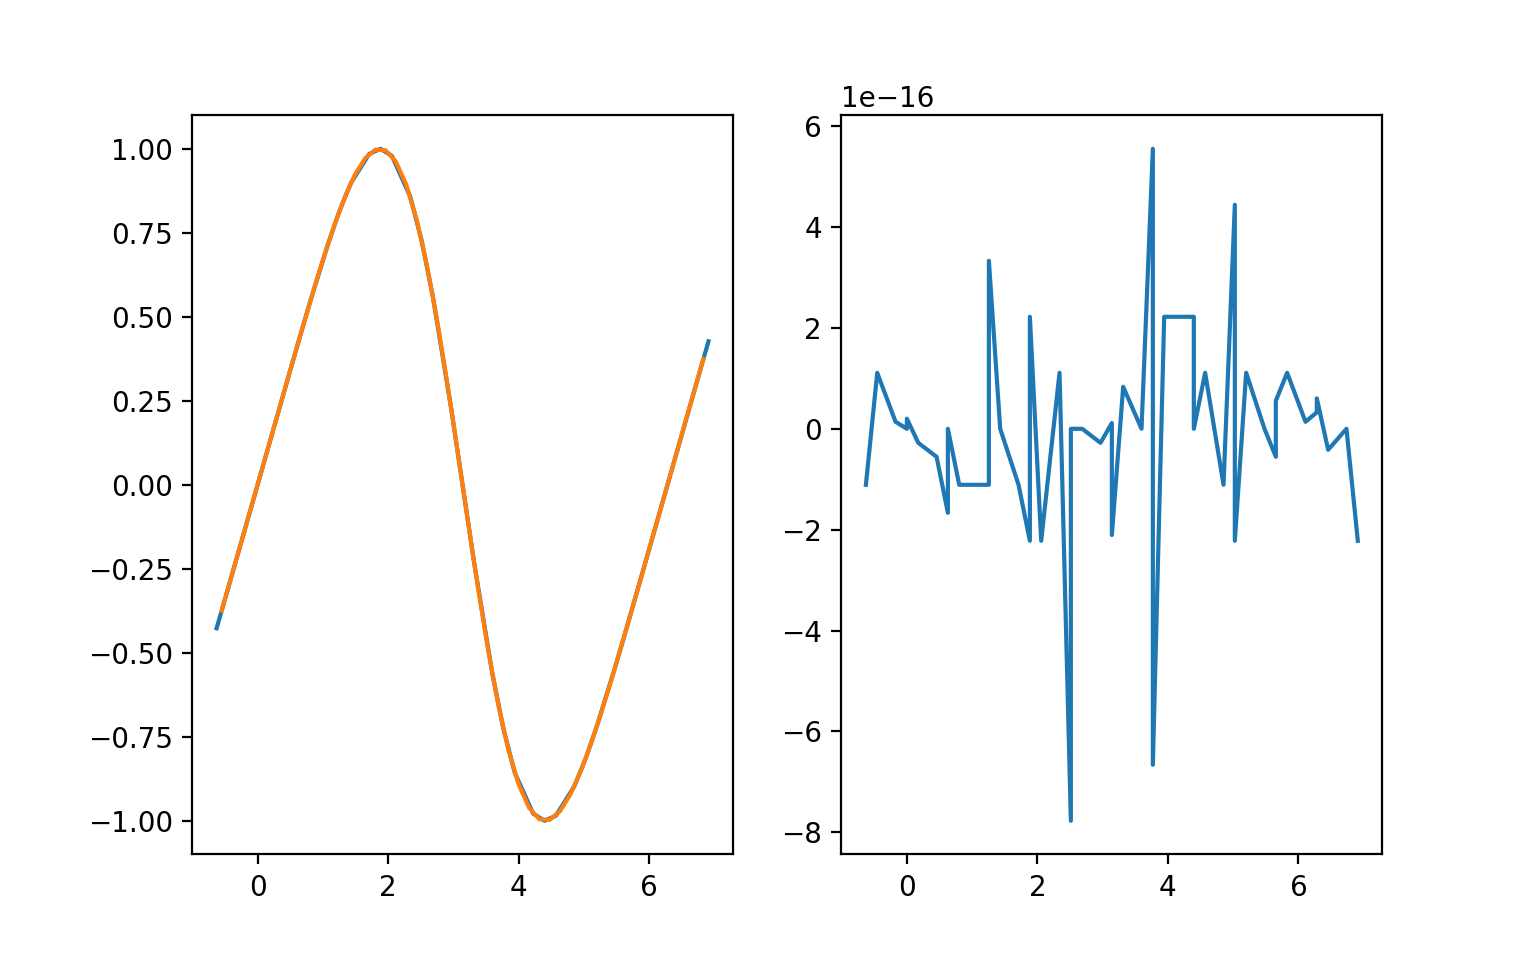

In [30]:
N=10
dx, x = grid(N, 1)
DG = DG_matrices(m=3)
x_DG, x_mood = DG_nodes(x, dx, m=3)
y0, dy0 = ics_smooth(x_DG)
y_mood = nodal_to_mood(y0, DG['to_mood'])
y_again = mood_to_nodal(y_mood, DG['from_mood'])

fig, axes = plt.subplots(1, 2, figsize=full_width)
axes[0].plot(x_DG.ravel(order='F'), y0.ravel(order='F'))
axes[0].plot(x_mood.ravel(order='F'), y_mood.ravel(order='F'))
axes[1].plot(x_DG.ravel(order='F'), y0.ravel(order='F')-y_again.ravel(order='F'))
plt.show()

Now we evolve forward using the "standard" $m=3$ case. We'll see later that the timestep effectively depends on $m$, but here I just fix a small CFL.

In [31]:
N=10
cfl = 0.1
t_end = np.pi/2

dx, x = grid(N, 1)
x_DG, _ = DG_nodes(x, dx, m=3)
y0, dy0 = ics_smooth(x_DG)
rhs = rhs_advection_DG(dx, m=3)
y = solve_periodic(rhs, ssperk33, y0, cfl*dx, t_end=t_end)

<IPython.core.display.Javascript object>


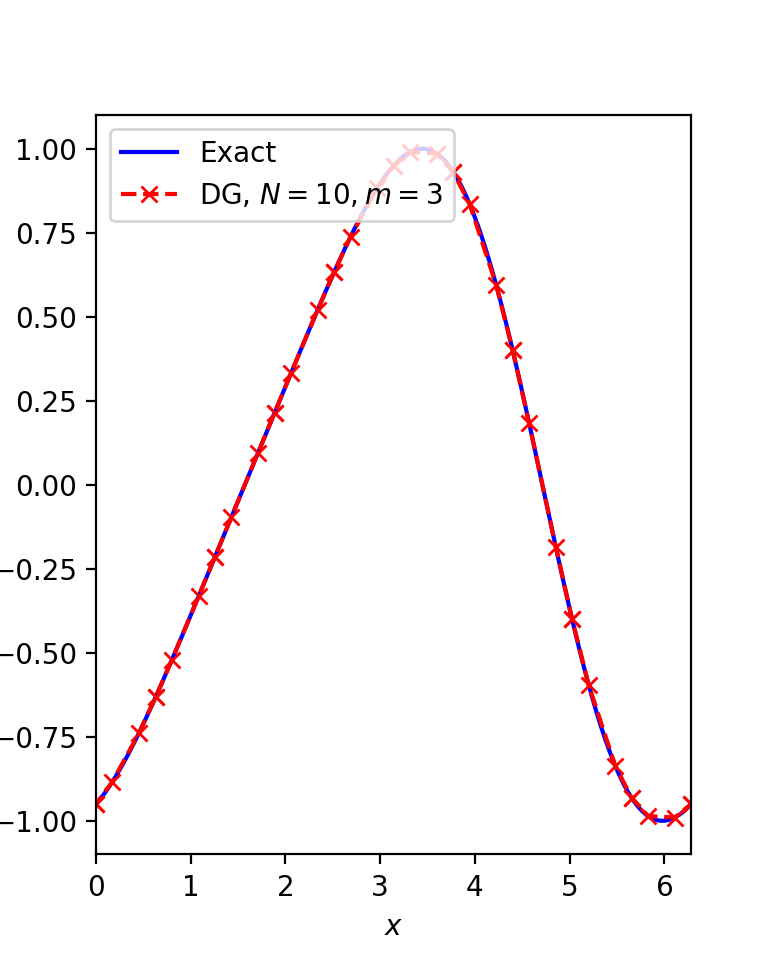

In [32]:
plt.figure()
x_exact = np.linspace(0, 2*np.pi, 1000)
y_exact, _ = ics_smooth(x_exact, t=np.pi/2)
plt.plot(x_exact, y_exact, 'b-', label="Exact")
plt.plot(x_DG.ravel(order='F'), y.ravel(order='F'), 'rx--', label="DG, $N=10, m=3$")
plt.xlabel(r"$x$")
plt.xlim(0, 2*np.pi)
plt.legend(loc='upper left')
plt.show()

In [48]:
def movie_dg(stepper, Ns, m, gz=1, cfl=0.1, t_end=2*np.pi, a=0.0, b=2*np.pi, ics=ics_smooth, legend_loc='upper left', 
             ylim=(-1.1, 1.1), ics_exact=None):
    
    colors='kr'
    markers='x+'
    
    class Mov:
        def __init__(self, axes):
            self.axes = axes
            self.stepper = stepper
            self.Ns = Ns
            self.m = m
            self.cfl = cfl
            self.t_end = t_end
            self.ics = ics
            if ics_exact is not None:
                self.ics_exact = ics_exact
            else:
                self.ics_exact = ics
            self.legend_loc = legend_loc
            self.a = a
            self.b = b
            self.x_exact = np.linspace(a, b, 1000)
            self.dx_xs = [grid(N, gz, a, b) for N in Ns]
            self.x_DGs = [DG_nodes(dx_x[1], dx_x[0], m)[0] for dx_x in self.dx_xs]
            self.y = [ics(x)[0] for x in self.x_DGs]
            self.rhss = [rhs_advection_DG(dx_x[0], m, gz=gz) for dx_x in self.dx_xs]
            self.ts = [0 for dx_x in self.dx_xs]
            self.dts = [cfl*dx_x[0] for dx_x in self.dx_xs]
            
            self.lines = []
            self.lines_compare = []
            for j in range(len(self.y)):
                lines, = axes[j].plot(self.x_DGs[j].ravel(order='F'), self.y[j].ravel(order='F'), 
                                      color=colors[j], marker=markers[j], 
                                      label=rf"DG, $N={self.Ns[j]}, m={m}$")
                self.lines.append(lines)
                lines_compare, = axes[j].plot(self.x_exact, self.ics_exact(self.x_exact)[0], 'b-', label="Exact")
                self.lines_compare.append(lines_compare)
            for j, ax in enumerate(self.axes.flatten()):
                ax.set_xlim(0, 2*np.pi)
                ax.legend(loc=legend_loc)
                ax.set_ylim(*ylim)
            self.axes[-1].set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi], ["0", r"$\pi$/2", r"$\pi$", r"3$\pi$/2", r"2$\pi$"])
            self.axes[-1].set_xlabel(r"$x$")
            self.time_text = self.axes[0].set_title(r"$t=0$")

        def update(self, i):
            if self.ts[0]+self.dts[0] > self.t_end:
                self.dts[0] = self.t_end - self.ts[0]
            self.ts[0] += self.dts[0]
            self.y[0] = self.stepper(self.rhss[0], self.y[0], self.dts[0])
            self.dts[1] = cfl*self.dx_xs[1][0]
            while self.ts[1] < self.ts[0]:
                if self.ts[1]+self.dts[1] > self.ts[0]:
                    self.dts[1] = self.ts[0] - self.ts[1]
                self.ts[1] += self.dts[1]
                self.y[1] = self.stepper(self.rhss[1], self.y[1], self.dts[1])
            for j in range(len(self.y)):
                self.lines[j].set_data(self.x_DGs[j].ravel(order='F'), self.y[j].ravel(order='F'))
                self.lines_compare[j].set_data(self.x_exact, self.ics_exact(self.x_exact, t=self.ts[0])[0])
            self.time_text.set_text(rf"$t={self.ts[0]:.2f}$")
            return self.lines_compare, self.lines, self.time_text

    fig, axes = plt.subplots(2, 1, sharex=True)
    mov = Mov(axes)

    Nframes = int(t_end / mov.dts[0])+1
    anim = animation.FuncAnimation(fig, mov.update, interval=100, blit=True, frames=Nframes)
    return anim

<IPython.core.display.Javascript object>


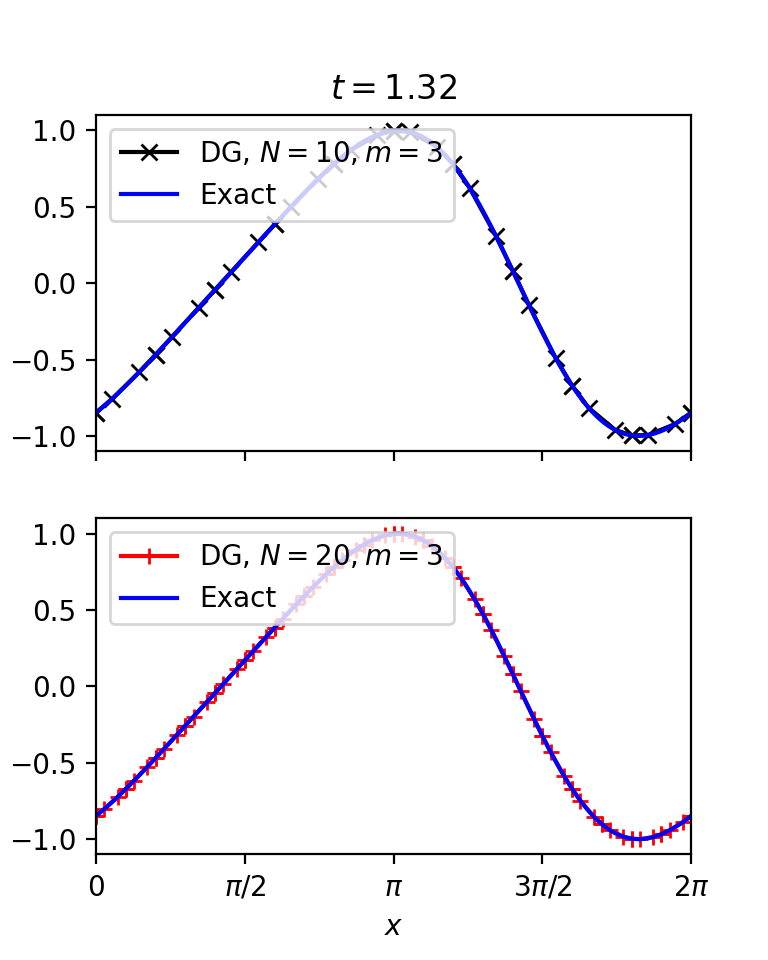

In [49]:
movie_dg(ssperk33, [10, 20], 3, gz=4)

In [ ]:
movie_dg(ssperk33, [5, 10], 4, cfl=0.05)

Let us check if we do get spectral convergence.

Note for what follows the end time is short - a single period. Direct comparison with the FD and spectral methods will require changing this.

Also note that, as this now goes to large values of $m$, we have to make the timestep explicitly depend on $m$.

In [34]:
def DG_errors(N, m=3, t_end=2*np.pi, ics=ics_smooth):
    cfl = 0.2/m

    dx, x = grid(N, 1)
    x_DG, _ = DG_nodes(x, dx, m)
    y0, dy0 = ics(x_DG)
    rhs = rhs_advection_DG(dx, m)
    y = solve_periodic(rhs, ssperk104, y0, cfl*dx, t_end=t_end)
    return compute_errors(y.ravel(order='F'), ics(x_DG.ravel(order='F'), t=t_end)[0], dx)

In [35]:
Ns = [10, 20, 40]
ms = np.arange(2, 9)
all_errors = np.zeros((len(Ns), len(ms)))
for i, N in enumerate(Ns):
    for j, m in enumerate(ms):
        all_errors[i, j] = DG_errors(N, m)

<IPython.core.display.Javascript object>


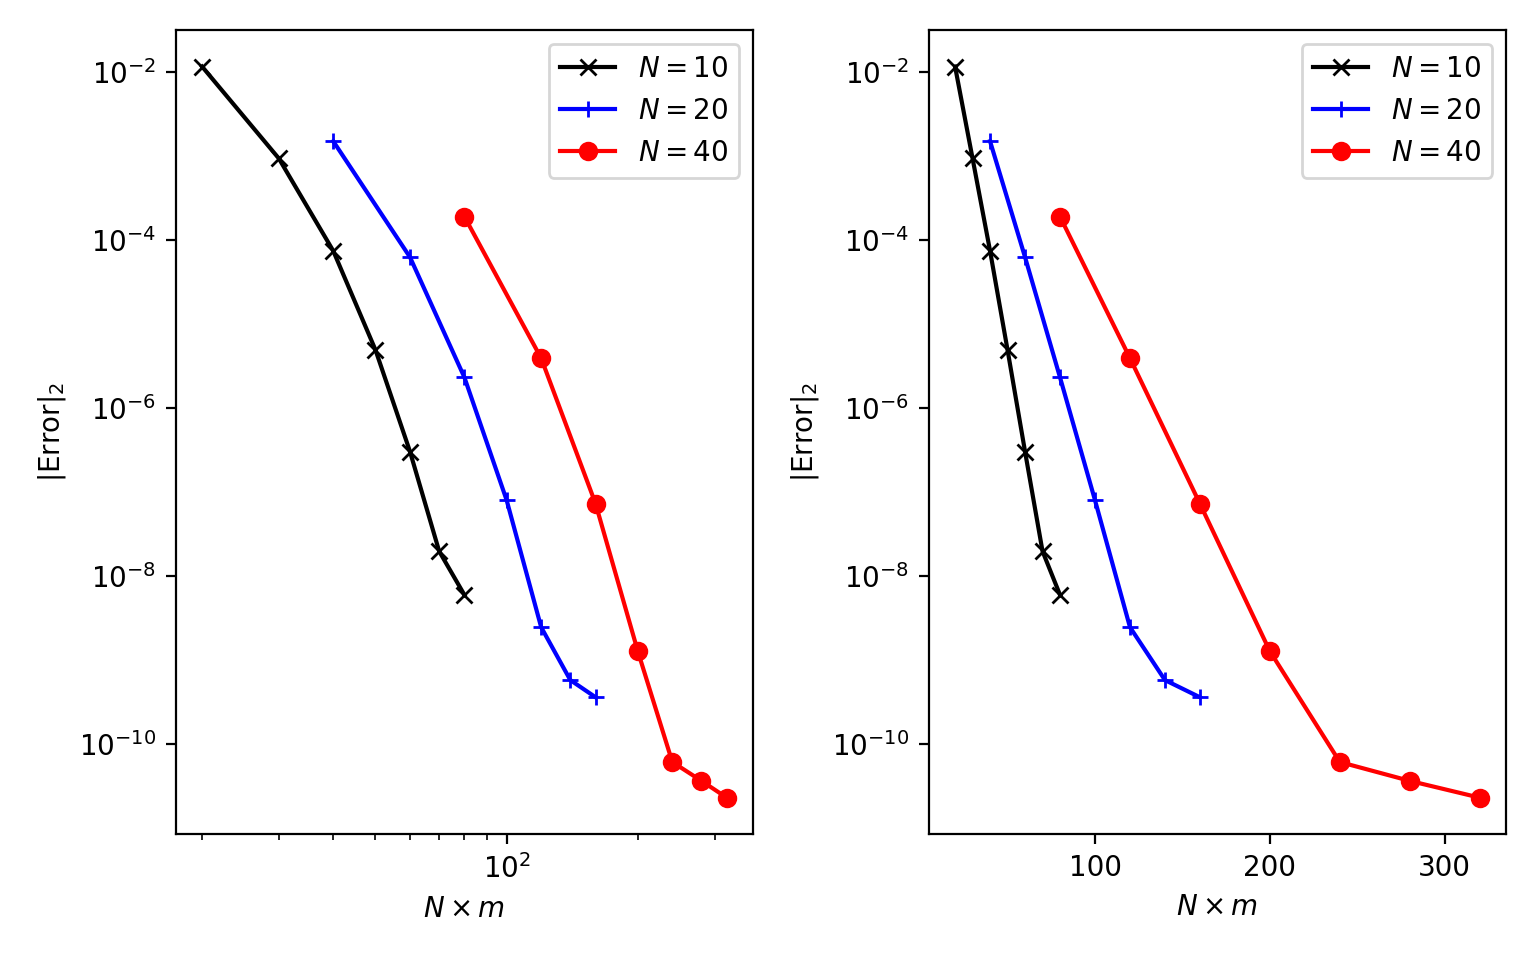

In [36]:
colors='kbr'
markers='x+o'
fig, axes = plt.subplots(1, 2, figsize=full_width)
for i, N in enumerate(Ns):
    axes[0].loglog(N*ms, all_errors[i, :], marker=markers[i], c=colors[i], label=rf"$N={N}$")
    axes[1].semilogy(N*ms, all_errors[i, :], marker=markers[i], c=colors[i], label=rf"$N={N}$")
for ax in axes:
    ax.legend()
    ax.set_xlabel(r"$N \times m$")
    ax.set_ylabel(r"$|$Error$|_2$")
fig.tight_layout()
plt.show()

So we see spectral accuracy with varying $m$ for fixed $N$, up until the point where the time error dominates. Flip that around and check for usual convergence with cells:

In [37]:
Ns = np.array([10, 20, 40, 80, 160])
ms = np.arange(2, 7, 2)
all_errors = np.zeros((len(Ns), len(ms)))
for i, N in enumerate(Ns):
    for j, m in enumerate(ms):
        all_errors[i, j] = DG_errors(N, m)

<IPython.core.display.Javascript object>


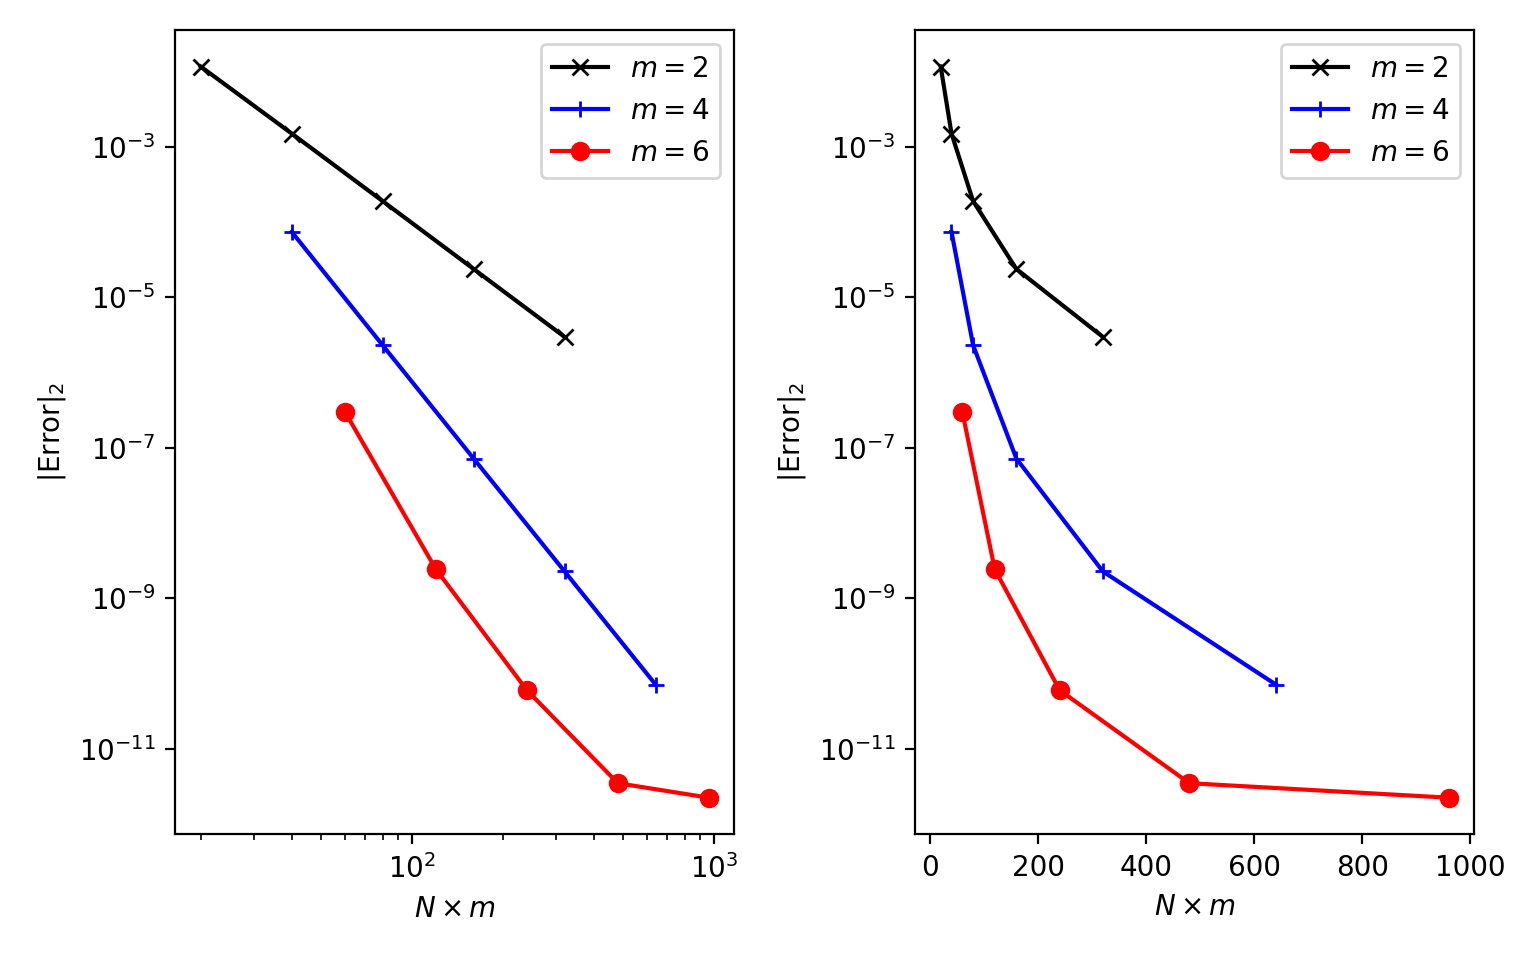

In [38]:
colors='kbr'
markers='x+o'
fig, axes = plt.subplots(1, 2, figsize=full_width)
for j, m in enumerate(ms):
    axes[0].loglog(m*Ns, all_errors[:, j], marker=markers[j], c=colors[j], label=rf"$m={m}$")
    axes[1].semilogy(m*Ns, all_errors[:, j], marker=markers[j], c=colors[j], label=rf"$m={m}$")
for ax in axes:
    ax.legend()
    ax.set_xlabel(r"$N \times m$")
    ax.set_ylabel(r"$|$Error$|_2$")
fig.tight_layout()
plt.show()

So the expected power law convergence with $N$, until we hit the floor.

Now we can do the timing.

In [39]:
Ns = np.array([10, 20, 40, 80])
ms = np.arange(2, 9, 2)
all_errors = np.zeros((len(Ns), len(ms)))
all_timings = np.zeros_like(all_errors)
for i, N in enumerate(Ns):
    for j, m in enumerate(ms):
        all_errors[i, j] = DG_errors(N, m)
        all_timings[i, j] = timeit.timeit(f"DG_errors({N}, {m})",
                                   globals=globals(), number=4)
        
p_fixed_N = np.zeros(len(Ns))
p_fixed_m = np.zeros(len(ms))
for i in range(len(Ns)):
    p_fixed_N[i] = np.polyfit(ms, np.log(all_errors[i, :]), 1)[0]
for j in range(len(ms)):
    p_fixed_m[j] = np.polyfit(np.log(Ns), np.log(all_errors[:, j]), 1)[0]

<IPython.core.display.Javascript object>


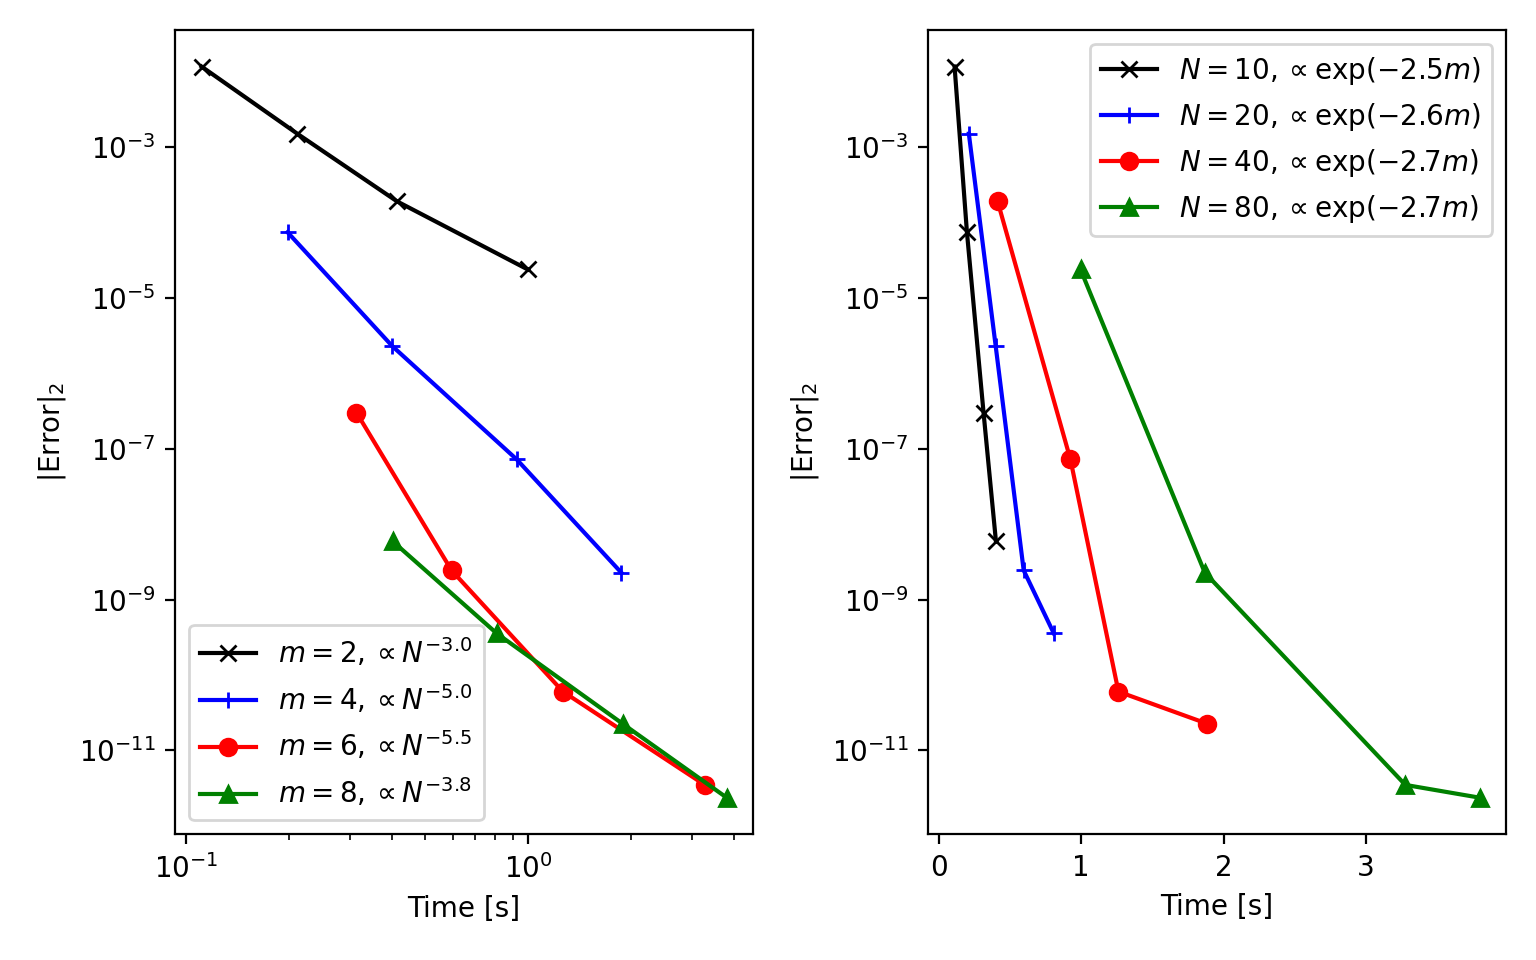

In [40]:
colors='kbrg'
markers='x+o^'
fig, axes = plt.subplots(1, 2, figsize=full_width)
for j, m in enumerate(ms):
    axes[0].loglog(all_timings[:, j], all_errors[:, j], marker=markers[j], c=colors[j], 
                   label=rf"$m={m}, \propto N^{{{p_fixed_m[j]:.1f}}}$")
for i, N in enumerate(Ns):
    axes[1].semilogy(all_timings[i, :], all_errors[i, :], marker=markers[i], c=colors[i], 
                     label=rf"$N={N}, \propto \exp({{{p_fixed_N[i]:.1f}}}m)$")
for ax in axes:
    ax.legend()
    ax.set_xlabel(r"Time [s]")
    ax.set_ylabel(r"$|$Error$|_2$")
fig.tight_layout()
plt.show()

For smooth solutions we see that the most efficient solution uses the smallest number of cells $N$ and the largest number of modes $m$, as you would expect from the spectral method argument.

#### Discontinuities and MOOD

Let's check that discontinuous data behaves catastrophically with DG without limiting, due to the standard Gibb's oscillations:

In [68]:
# This version works for arbitrary input
def ics_discontinuous_dg(x, a=0.0, b=2*np.pi, t=0):
    L = b - a
    x_norm = np.mod(x - t, L)
    y = np.zeros_like(x)
    dy = np.zeros_like(x)
    for index, xx in np.ndenumerate(x_norm):
        if (xx > a + L/8) and (xx < a + L/4):
            y[index] = (xx - (a+L/8)) / (L/8)
            dy[index] = 8/L
        elif (xx > a + L/4) and (xx < a + 3*L/8):
            y[index] = -(xx - (a+3*L/8)) / (L/8)
            dy[index] = -8/L
        elif (abs(xx - (a+3*L/4)) < L/8):
            y[index] = 1
    return y, dy

# This version is DG only, but ensures the discontinuities are at element boundaries, assuming the grid
# is right. Not really suited for general t because of this.
def ics_discontinuous_dg(x, a=0.0, b=2*np.pi, t=0):
    L = b - a
    x_norm = np.mod(x - t, L)
    y = np.zeros_like(x)
    dy = np.zeros_like(x)
    for j in range(x_norm.shape[1]):
        for i, xx in enumerate(x_norm[:, j]):
            if (xx > a + L/8) and (xx <= a + L/4):
                y[i, j] = (xx - (a+L/8)) / (L/8)
                dy[i, j] = 8/L
            elif (xx > a + L/4) and (xx < a + 3*L/8):
                y[i, j] = -(xx - (a+3*L/8)) / (L/8)
                dy[i, j] = -8/L
        indicator = np.abs(x_norm[:, j] - (a+3*L/4)) - L/8
        if np.mean(indicator) < 0:
            y[:, j] = 1
            for i in range(len(indicator)):
                if (indicator[i] > 0) and (not np.allclose(indicator[i], 0)):
                    print(i, j, y[i, j], indicator[i])
                    raise NotImplementedError("Need element boundaries to fall on shock")
        else:
            for i in range(len(indicator)):
                if (indicator[i] < 0) and (not np.allclose(indicator[i], 0)):
                    print(i, j, y[i, j], indicator[i])
                    raise NotImplementedError("Need element boundaries to fall on shock")
    return y, dy


<IPython.core.display.Javascript object>


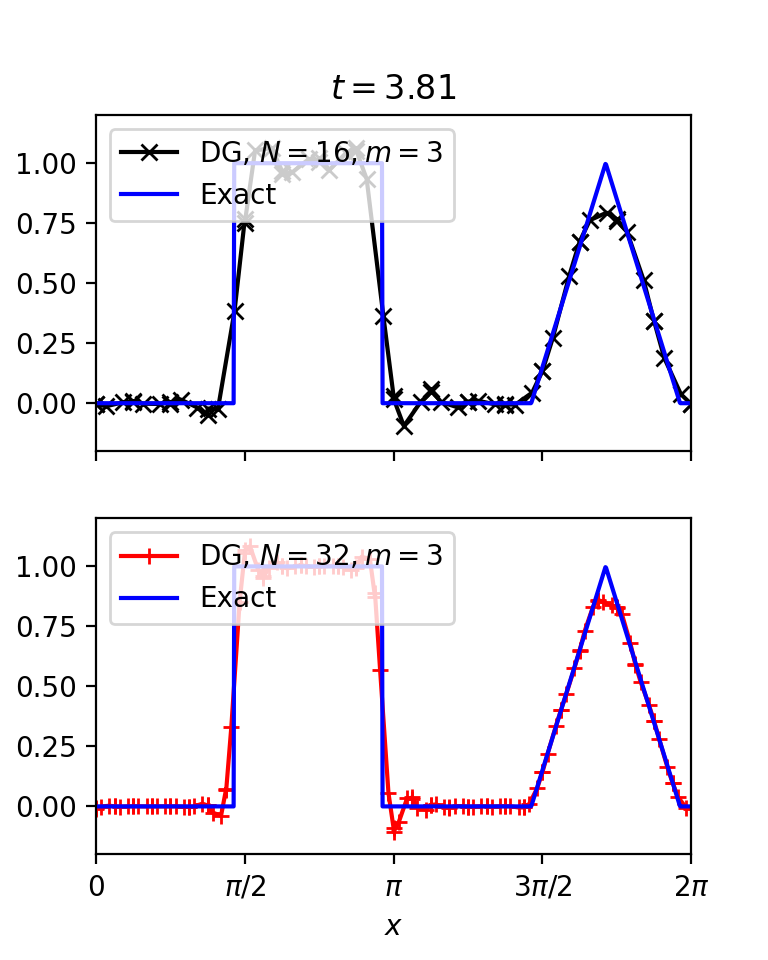

In [42]:
movie_dg(ssperk33, [16, 32], 3, ics=ics_discontinuous_dg, ylim=(-0.2, 1.2))

In some ways that's not as bad as I expected, although those oscillations are still larger than I would like. Try higher $m$:

<IPython.core.display.Javascript object>


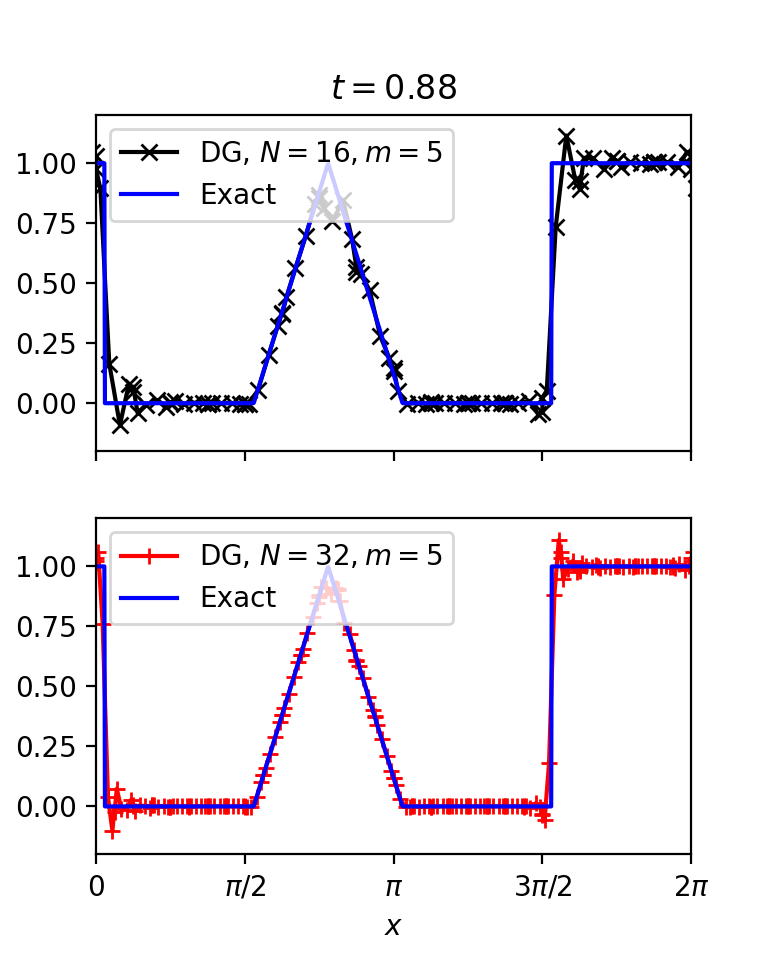

In [43]:
movie_dg(ssperk33, [16, 32], 5, ics=ics_discontinuous_dg, cfl=0.2/5, ylim=(-0.2, 1.2))

The Gibbs' oscillations don't seem to be getting larger, in contrast to what happens when increasing $N$.

Now move to MOOD. We need to detect troubled cells. Use the Numerical Admissability Detector of Dumbser et al (2014), "A posteriori subcell limiting..."

In [44]:
def troubled_cells(y, y_new):
    troubled = np.zeros((y.shape[1],), dtype=np.bool8)
    delta0 = 1e-4
    eps = 1e-3
    for i in range(1, y.shape[1]-1):
        max_y = np.max(y[:, i-1:i+2])
        min_y = np.min(y[:, i-1:i+2])
        delta = max(delta0, eps * (max_y - min_y))
        min_test = np.all(min_y - delta < y_new[:, i])
        max_test = np.all(max_y + delta > y_new[:, i])
        troubled[i] = not(min_test and max_test)
    return troubled

In [136]:
def solve_periodic_mood(rhs_dg, rhs_weno, DG, stepper, y0, dt, t_end=2*np.pi):
    y_dg = y0.copy()
    to_mood = DG['to_mood']
    from_mood = DG['from_mood']
    y_weno = nodal_to_mood(y_dg, to_mood).ravel(order='F')
    t = 0
    while t < t_end:
        if t+dt > t_end:
            dt = t_end - t 
        t += dt
        y_new_dg = stepper(rhs_dg, y_dg, dt)
        y_new_weno = stepper(rhs_weno, y_weno, dt)
        y_weno_on_dg = mood_to_nodal(y_new_weno.reshape(y_dg.shape, order='F'), from_mood)
        troubled = troubled_cells(y_dg, y_new_dg)
        y = np.where(troubled, y_weno_on_dg, y_new_dg)
        y_dg = y.copy()
        y_weno = nodal_to_mood(y_dg, to_mood).ravel(order='F')
    return y

In [138]:
N=16
cfl = 0.1
t_end = np.pi/2
gz = 4

dx, x = grid(N, gz)
DG = DG_matrices(m=3)
x_DG, x_mood = DG_nodes(x, dx, m=3)
y0, dy0 = ics_discontinuous_dg(x_DG)
rhs_dg = rhs_advection_DG(dx, m=3)
rhs_weno = rhs_advection_weno(dx/4, order=3)
y = solve_periodic_mood(rhs_dg, rhs_weno, DG, ssperk33, y0, cfl*dx, t_end=t_end)
y_weno = solve_periodic(rhs_weno, ssperk33, nodal_to_mood(y0, DG['to_mood']).ravel(order='F'), cfl*dx/4, t_end=t_end)

<IPython.core.display.Javascript object>


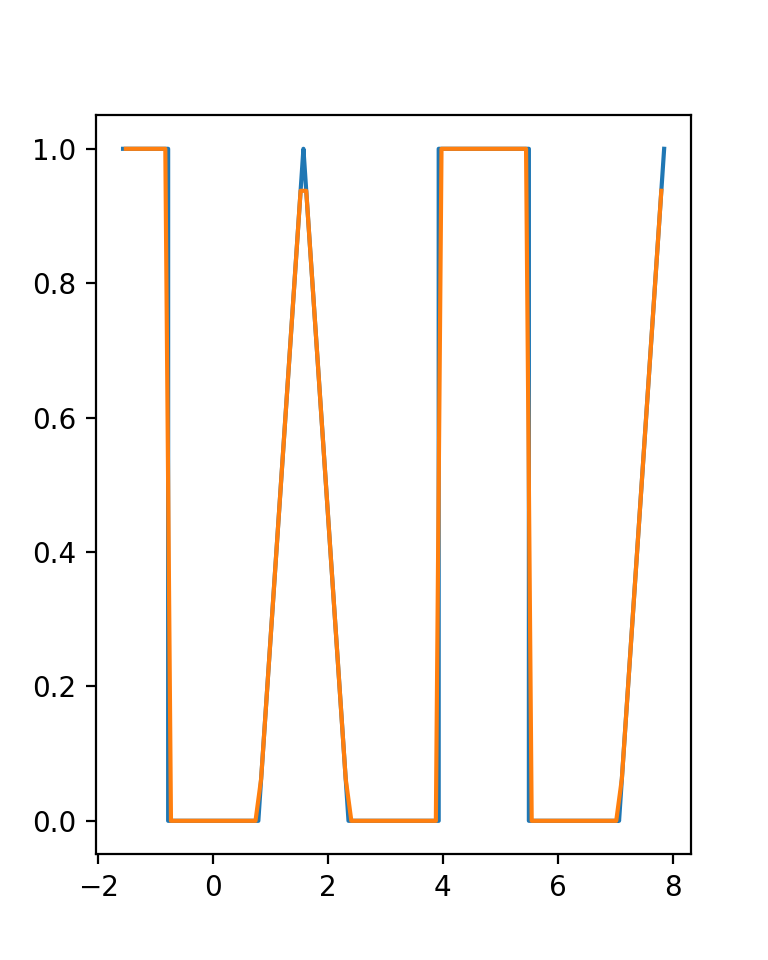

In [71]:
plt.figure()
plt.plot(x_DG.ravel(order='F'), y0.ravel(order='F'))
plt.plot(x_mood.ravel(order='F'), nodal_to_mood(y0, DG['to_mood']).ravel(order='F'))
plt.show()

So by fixing the shock to perfectly match element boundaries the MOOD conversion through this pointwise route is fine.

0.0


<IPython.core.display.Javascript object>


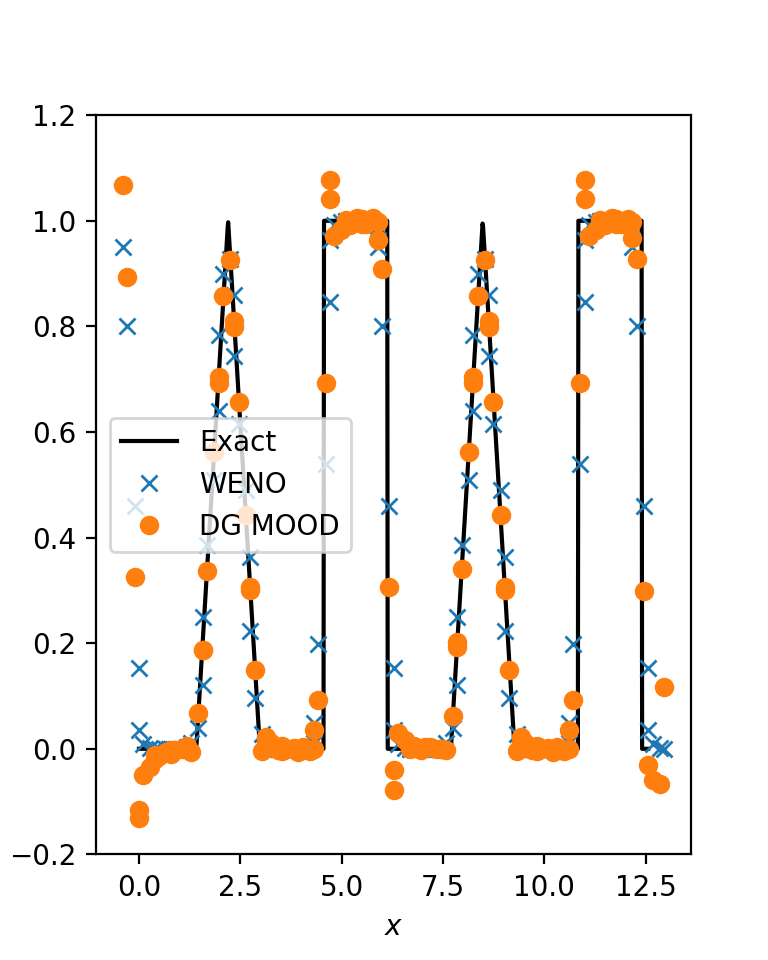

In [140]:
N=16
cfl = 0.1
t_end = 0.2*np.pi
gz = 1 # Need to think about this more.

N = 32
a = 0
b = 4 * np.pi

dx, x = grid(N, gz, a, b)
DG = DG_matrices(m=3)
x_DG, x_mood = DG_nodes(x, dx, m=3)
y0, dy0 = ics_discontinuous_dg(x_DG)
rhs_dg = rhs_advection_DG(dx, m=3)
rhs_weno = rhs_advection_weno(dx/4, order=3, gz=4)
print(dx/4- (x_mood[1, 0]-x_mood[0, 0]))

# plt.figure()
# plt.plot(x_DG.ravel(order='F'), y0.ravel(order='F'), 'kx')
# plt.plot(x_mood.ravel(order='F'), nodal_to_mood(y0, DG['to_mood']).ravel(order='F'), 'b+')
# plt.show()
y = solve_periodic_mood(rhs_dg, rhs_weno, DG, ssperk33, y0, cfl*dx, t_end=t_end)
y_weno = solve_periodic(rhs_weno, ssperk33, nodal_to_mood(y0, DG['to_mood']).ravel(order='F'), cfl*dx/4, t_end=t_end)

x_exact = np.linspace(a, b, 1000)
plt.figure()
plt.plot(x_exact, ics_discontinuous(x_exact, t=t_end)[0], 'k-', label="Exact")
plt.plot(x_DG.ravel(order='F'), y_weno, 'x', label="WENO")
plt.plot(x_DG.ravel(order='F'), y.ravel(order='F'), 'o', label="DG MOOD")
# plt.xlim(0, 2*np.pi)
plt.ylim(-0.2, 1.2)
plt.xlabel(r"$x$")
plt.legend()
plt.show()

This isn't perfect but it's much better. Issues with the BCs.

<IPython.core.display.Javascript object>


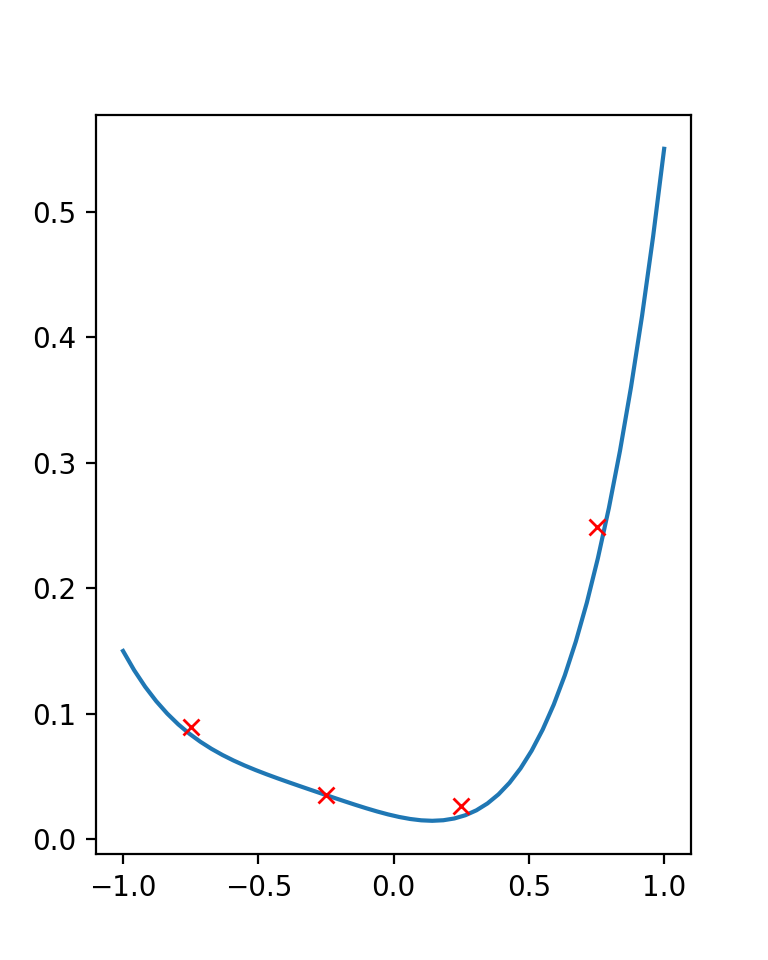

In [72]:
c = np.array([0.1, 0.1, 0.2, 0.1, 0.05])
# These steps will interpolate via integration onto a grid
c_int = legendre.legint(c)
dx = 2/4
x_grid = np.arange(-1+dx/2, 1, dx)
x_int_grid = np.arange(-1, 1+dx/2, dx)
int_p = legendre.legval(x_int_grid, c_int)
int_q = np.zeros_like(x_grid)
int_q = np.diff(int_p)/dx
x = np.linspace(-1, 1, 50)
plt.figure()
plt.plot(x, legendre.legval(x, c))
plt.plot(x_grid, int_q, 'rx')

In [75]:
# This does not work - scaling error.

def nodal_to_mood_int(y, DG):
    modes = nodal_to_modal(y, DG['V_inv'])
    result = np.zeros_like(y)
    dx = 2 / y.shape[0]
    x_int_grid = np.arange(-1, 1+dx/2, dx)
    for i in range(y.shape[1]):
        modes_int = legendre.legint(modes[:, i])
        int_vals = legendre.legval(x_int_grid, modes_int)
        result[:, i] = np.diff(int_vals)/dx
    return result

<IPython.core.display.Javascript object>


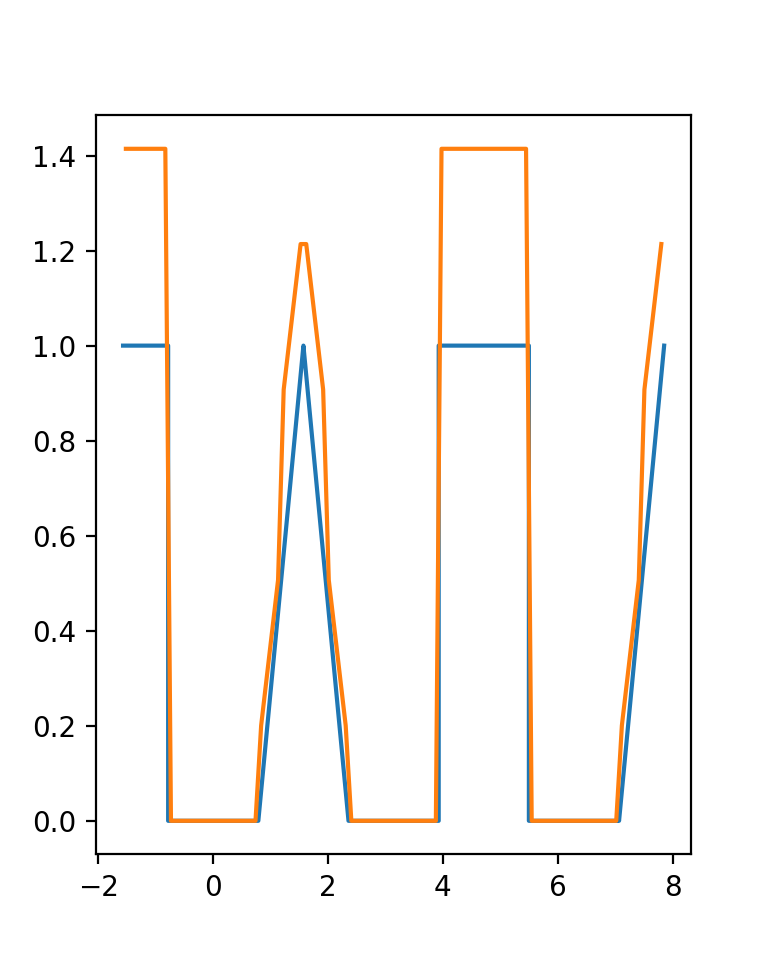

In [74]:
plt.figure()
# plt.plot(x_DG.ravel(order='F'), y_weno)
# plt.plot(x_DG.ravel(order='F'), y.ravel(order='F'))
plt.plot(x_DG.ravel(order='F'), y0.ravel(order='F'))
plt.plot(x_mood.ravel(order='F'), nodal_to_mood_int(y0, DG).ravel(order='F'))
plt.show()

Ok, so going between the different grid setups obviously introduces oscillations. Paper says to work with integrals instead - think.

In [90]:
def movie_dg_mood(stepper, Ns, m, gz=4, cfl=0.1, t_end=2*np.pi, a=0.0, b=2*np.pi, ics=ics_discontinuous_dg, 
                  legend_loc='upper left', ylim=(-0.2, 1.2), ics_exact=None):
    
    colors='kr'
    markers='x+'
    
    class Mov:
        def __init__(self, axes):
            self.axes = axes
            self.stepper = stepper
            self.Ns = Ns
            self.m = m
            self.cfl = cfl
            self.t_end = t_end
            self.ics = ics
            if ics_exact is not None:
                self.ics_exact = ics_exact
            else:
                self.ics_exact = ics
            self.legend_loc = legend_loc
            self.a = a
            self.b = b
            self.DG = DG_matrices(m)
            self.x_exact = np.linspace(a, b, 1000)
            self.dx_xs = [grid(N, gz, a, b) for N in Ns]
            self.x_DGs = [DG_nodes(dx_x[1], dx_x[0], m)[0] for dx_x in self.dx_xs]
            self.y_dgs = [ics(x)[0] for x in self.x_DGs]
            self.y_wenos = [nodal_to_mood(y_dg, self.DG['to_mood']).ravel(order='F') for y_dg in self.y_dgs]
            self.rhss_dg = [rhs_advection_DG(dx_x[0], m, gz=gz) for dx_x in self.dx_xs]
            self.rhss_weno = [rhs_advection_weno(dx_x[0]/(m+1)) for dx_x in self.dx_xs]
            self.ts = [0 for dx_x in self.dx_xs]
            self.dts = [cfl*dx_x[0] for dx_x in self.dx_xs]
            
            self.lines = []
            self.lines_compare = []
            for j in range(len(self.y_dgs)):
                lines, = axes[j].plot(self.x_DGs[j].ravel(order='F'), self.y_dgs[j].ravel(order='F'), 
                                      color=colors[j], marker=markers[j], 
                                      label=rf"DG, $N={self.Ns[j]}, m={m}$")
                self.lines.append(lines)
                lines_compare, = axes[j].plot(self.x_exact, self.ics_exact(self.x_exact)[0], 'b-', label="Exact")
                self.lines_compare.append(lines_compare)
            for j, ax in enumerate(self.axes.flatten()):
                ax.set_xlim(0, 2*np.pi)
                ax.legend(loc=legend_loc)
                ax.set_ylim(*ylim)
            self.axes[-1].set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi], ["0", r"$\pi$/2", r"$\pi$", r"3$\pi$/2", r"2$\pi$"])
            self.axes[-1].set_xlabel(r"$x$")
            self.time_text = self.axes[0].set_title(r"$t=0$")

        def update(self, i):
            if self.ts[0]+self.dts[0] > self.t_end:
                self.dts[0] = self.t_end - self.ts[0]
            self.ts[0] += self.dts[0]
            y_dg_new = self.stepper(self.rhss_dg[0], self.y_dgs[0], self.dts[0])
            y_weno_new = self.stepper(self.rhss_weno[0], self.y_weno[0], self.dts[0])
            y_weno_on_dg = mood_to_nodal(y_weno_new.reshape(y_dg.shape, order='F'), DG['from_mood'])
            troubled = troubled_cells(self.y_dgs[0], y_new_dg)
            self.y_dg[0] = np.where(troubled, y_weno_on_dg, y_new_dg)
            self.y_weno = nodal_to_mood(self.y_dgs[0], DG['to_mood']).ravel(order='F')
            self.dts[1] = cfl*self.dx_xs[1][0]
            while self.ts[1] < self.ts[0]:
                if self.ts[1]+self.dts[1] > self.ts[0]:
                    self.dts[1] = self.ts[0] - self.ts[1]
                self.ts[1] += self.dts[1]
                y_dg_new = self.stepper(self.rhss_dg[1], self.y_dgs[1], self.dts[1])
                y_weno_new = self.stepper(self.rhss_weno[1], self.y_weno[1], self.dts[1])
                y_weno_on_dg = mood_to_nodal(y_weno_new.reshape(y_dg.shape, order='F'), DG['from_mood'])
                troubled = troubled_cells(self.y_dgs[1], y_new_dg)
                self.y_dg[1] = np.where(troubled, y_weno_on_dg, y_new_dg)
                self.y_weno = nodal_to_mood(self.y_dgs[1], DG['to_mood']).ravel(order='F')
            for j in range(len(self.y_dgs)):
                self.lines[j].set_data(self.x_DGs[j].ravel(order='F'), self.y_dgs[j].ravel(order='F'))
                self.lines_compare[j].set_data(self.x_exact, self.ics_exact(self.x_exact, t=self.ts[0])[0])
            self.time_text.set_text(rf"$t={self.ts[0]:.2f}$")
            return self.lines_compare, self.lines, self.time_text

    fig, axes = plt.subplots(2, 1, sharex=True)
    mov = Mov(axes)

    Nframes = int(t_end / mov.dts[0])+1
    anim = animation.FuncAnimation(fig, mov.update, interval=100, blit=True, frames=Nframes)
    return anim

<IPython.core.display.Javascript object>


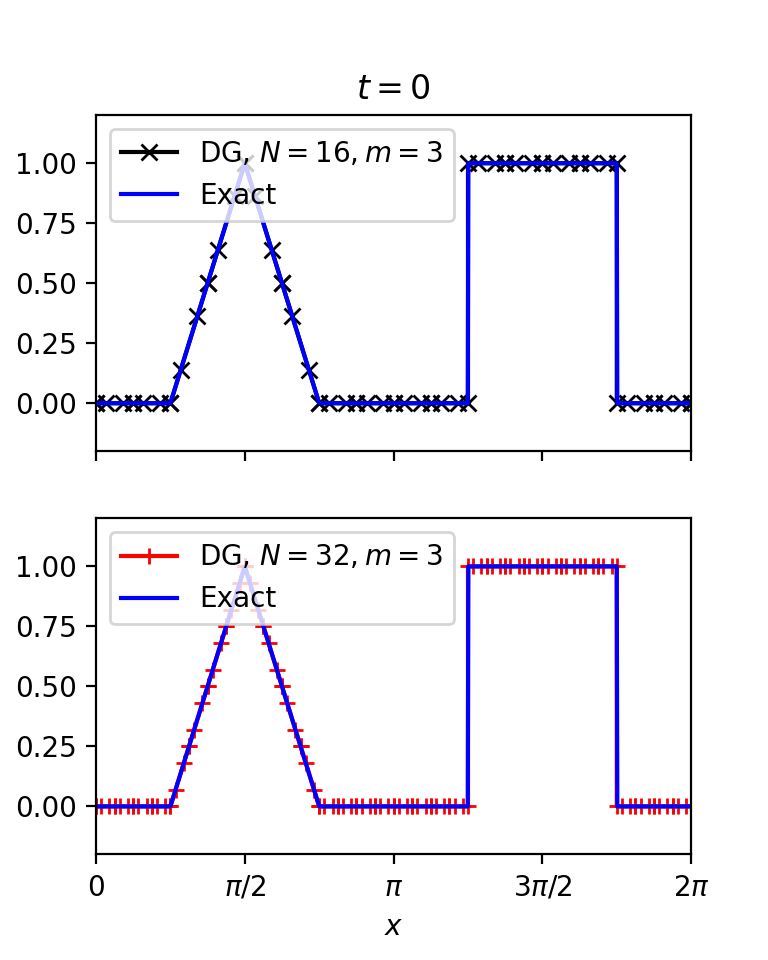

In [91]:
movie_dg_mood(ssperk104, [16, 32], 3, ics_exact=ics_discontinuous)

<IPython.core.display.Javascript object>


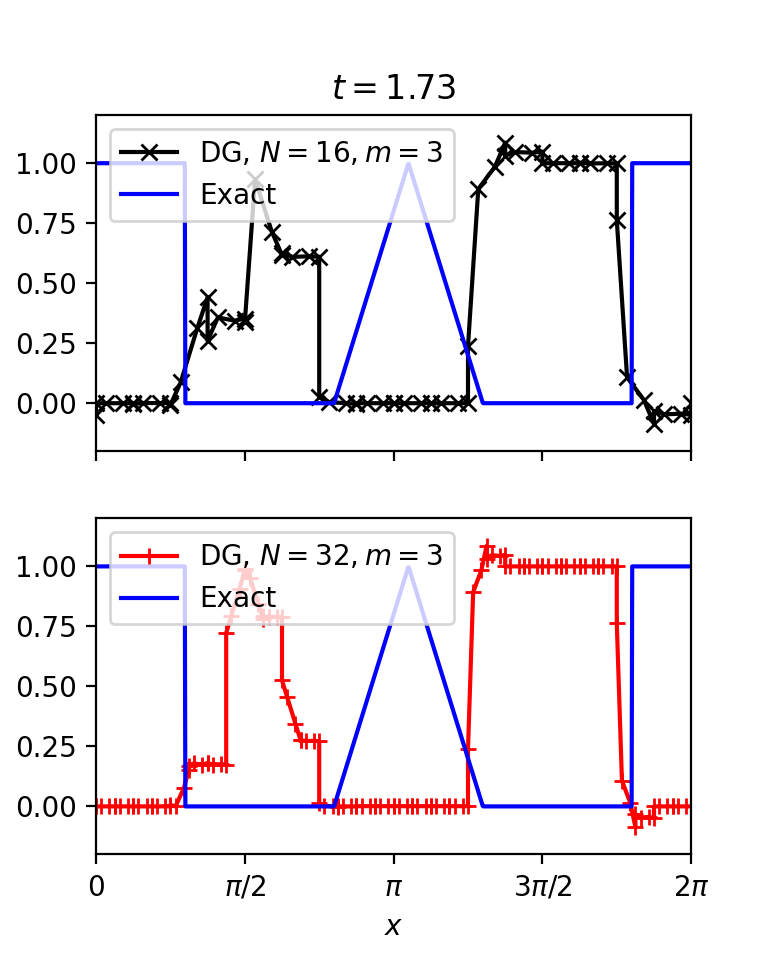

In [107]:
stepper=ssperk104
Ns=[16,32]
m=3
ics_exact=ics_discontinuous
gz=4
cfl=0.1
t_end=2*np.pi
a=0.0
b=2*np.pi
ics=ics_discontinuous_dg
legend_loc='upper left'
ylim=(-0.2, 1.2)

colors='kr'
markers='x+'

class Mov:
    def __init__(self, axes):
        self.axes = axes
        self.stepper = stepper
        self.Ns = Ns
        self.m = m
        self.cfl = cfl
        self.t_end = t_end
        self.ics = ics
        if ics_exact is not None:
            self.ics_exact = ics_exact
        else:
            self.ics_exact = ics
        self.legend_loc = legend_loc
        self.a = a
        self.b = b
        self.DG = DG_matrices(m)
        self.x_exact = np.linspace(a, b, 1000)
        self.dx_xs = [grid(N, gz, a, b) for N in Ns]
        self.x_DGs = [DG_nodes(dx_x[1], dx_x[0], m)[0] for dx_x in self.dx_xs]
        self.y_dgs = [ics(x)[0] for x in self.x_DGs]
        self.y_wenos = [nodal_to_mood(y_dg, self.DG['to_mood']).ravel(order='F') for y_dg in self.y_dgs]
        self.rhss_dg = [rhs_advection_DG(dx_x[0], m, gz=gz) for dx_x in self.dx_xs]
        self.rhss_weno = [rhs_advection_weno(dx_x[0]/(m+1)) for dx_x in self.dx_xs]
        self.ts = [0 for dx_x in self.dx_xs]
        self.dts = [cfl*dx_x[0] for dx_x in self.dx_xs]

        self.lines = []
        self.lines_compare = []
        for j in range(len(self.y_dgs)):
            lines, = axes[j].plot(self.x_DGs[j].ravel(order='F'), self.y_dgs[j].ravel(order='F'), 
                                  color=colors[j], marker=markers[j], 
                                  label=rf"DG, $N={self.Ns[j]}, m={m}$")
            self.lines.append(lines)
            lines_compare, = axes[j].plot(self.x_exact, self.ics_exact(self.x_exact)[0], 'b-', label="Exact")
            self.lines_compare.append(lines_compare)
        for j, ax in enumerate(self.axes.flatten()):
            ax.set_xlim(0, 2*np.pi)
            ax.legend(loc=legend_loc)
            ax.set_ylim(*ylim)
        self.axes[-1].set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi], ["0", r"$\pi$/2", r"$\pi$", r"3$\pi$/2", r"2$\pi$"])
        self.axes[-1].set_xlabel(r"$x$")
        self.time_text = self.axes[0].set_title(r"$t=0$")

    def update(self, i):
        if self.ts[0]+self.dts[0] > self.t_end:
            self.dts[0] = self.t_end - self.ts[0]
        self.ts[0] += self.dts[0]
        y_dg_new = self.stepper(self.rhss_dg[0], self.y_dgs[0], self.dts[0])
        y_weno_new = self.stepper(self.rhss_weno[0], self.y_wenos[0], self.dts[0])
        y_weno_on_dg = mood_to_nodal(y_weno_new.reshape(y_dg_new.shape, order='F'), DG['from_mood'])
        troubled = troubled_cells(self.y_dgs[0], y_dg_new)
        self.y_dgs[0] = np.where(troubled, y_weno_on_dg, y_dg_new)
        self.y_weno = nodal_to_mood(self.y_dgs[0], DG['to_mood']).ravel(order='F')
        self.dts[1] = cfl*self.dx_xs[1][0]
        while self.ts[1] < self.ts[0]:
            if self.ts[1]+self.dts[1] > self.ts[0]:
                self.dts[1] = self.ts[0] - self.ts[1]
            self.ts[1] += self.dts[1]
            y_dg_new = self.stepper(self.rhss_dg[1], self.y_dgs[1], self.dts[1])
            y_weno_new = self.stepper(self.rhss_weno[1], self.y_wenos[1], self.dts[1])
            y_weno_on_dg = mood_to_nodal(y_weno_new.reshape(y_dg_new.shape, order='F'), DG['from_mood'])
            troubled = troubled_cells(self.y_dgs[1], y_dg_new)
            self.y_dgs[1] = np.where(troubled, y_weno_on_dg, y_dg_new)
            self.y_weno = nodal_to_mood(self.y_dgs[1], DG['to_mood']).ravel(order='F')
        for j in range(len(self.y_dgs)):
            self.lines[j].set_data(self.x_DGs[j].ravel(order='F'), self.y_dgs[j].ravel(order='F'))
            self.lines_compare[j].set_data(self.x_exact, self.ics_exact(self.x_exact, t=self.ts[0])[0])
        self.time_text.set_text(rf"$t={self.ts[0]:.2f}$")
        return self.lines_compare, self.lines, self.time_text

fig, axes = plt.subplots(2, 1, sharex=True)
mov = Mov(axes)

Nframes = int(t_end / mov.dts[0])+1
anim = animation.FuncAnimation(fig, mov.update, interval=100, blit=True, frames=Nframes)

In [109]:
mov.dts
# mov.y_wenos[0]

[0.039269908169872414, 0.019634954084936207]

# Old stuff

In [ ]:
1/0

In [ ]:
def setup_advection(N, gz):
    dx = 2.0*np.pi / N
    x = np.arange(-np.pi-(gz-1/2)*dx, np.pi+(gz)*dx, dx)
    y = np.sin(x - np.sin(x)/np.pi)
    return x, dx, y

def rhs_advection_2(dx):
    def rhs(y):
        dydt = np.zeros_like(y)
        dydt[2:-2] = (y[3:-1] - y[1:-3]) / (2*dx)
        dydt[0] = dydt[-4]
        dydt[1] = dydt[-3]
        dydt[-2] = dydt[2]
        dydt[-1] = dydt[3]
        return dydt
    return rhs

def rhs_advection_4(dx):
    def rhs(y):
        dydt = np.zeros_like(y)
        dydt[2:-2] = (-y[4:] + 8*y[3:-1] - 8*y[1:-3] + y[:-4]) / (12*dx)
        dydt[0] = dydt[-4]
        dydt[1] = dydt[-3]
        dydt[-2] = dydt[2]
        dydt[-1] = dydt[3]
        return dydt
    return rhs

def time_fd(stepper, rhs_gen, cfl, N, t_end=20*np.pi):
    x, dx, y = setup_advection(N, 2)
    dt = cfl * dx
    rhs = rhs_gen(dx)
    y0 = y.copy()
    t = 0
    while t < t_end:
        if t+dt > t_end:
            dt = t_end - t 
        t += dt
        y = stepper(rhs, y, dt)
    errors = np.sqrt(dx) * np.linalg.norm(y - y0, 2)
    return dx, errors

In [ ]:
N=100
t_end = 20*np.pi
cfl = 0.4
x, dx, y2 = setup_advection(N, 2)
dt = cfl * dx
y0 = y2.copy()
y4 = y2.copy()
rhs2 = rhs_advection_2(dx)
rhs4 = rhs_advection_4(dx)
t = 0
while t < t_end:
    if t+dt > t_end:
        dt = t_end - t 
    t += dt
    y2 = ssperk33(rhs2, y2, dt)
    y4 = ssperk104(rhs4, y4, dt)

In [ ]:
plt.figure()
plt.plot(x, y0, 'b-')
plt.plot(x, y2, 'kx')
plt.plot(x, y4, 'ro')

In [ ]:
Ns_fd = 2**np.arange(5, 10)
errors2 = np.zeros(len(Ns_fd))
errors4 = np.zeros(len(Ns_fd))
times2 = np.zeros(len(Ns_fd))
times4 = np.zeros(len(Ns_fd))
dxs_fd = np.zeros_like(errors2)
t_end = 20*np.pi
cfl = 0.4
for j, N in enumerate(Ns_fd):
#     x, dx, y2 = setup_advection(N, 2)
#     dxs_fd[j] = dx
#     dt = cfl * dx
#     Nt = int(t_end / dt)
#     y0 = y2.copy()
#     y4 = y2.copy()
#     rhs2 = rhs_advection_2(dx)
#     rhs4 = rhs_advection_4(dx)
#     for i in range(Nt):
#         y2 = ssperk33(rhs2, y2, dt)
#         y4 = ssperk104(rhs4, y4, dt)
#     errors2[j] = np.sqrt(dx) * np.linalg.norm(y2 - y0, 2)
#     errors4[j] = np.sqrt(dx) * np.linalg.norm(y4 - y0, 2)
    dxs_fd[j], errors2[j] = time_fd(ssperk33, rhs_advection_2, cfl, N)
    dxs_fd[j], errors4[j] = time_fd(ssperk104, rhs_advection_4, cfl, N)
    times2[j] = timeit.timeit(f"time_fd(ssperk33, rhs_advection_2, {cfl}, {N})",
                             globals=globals(), number=4)
    times4[j] = timeit.timeit(f"time_fd(ssperk104, rhs_advection_4, {cfl}, {N})",
                             globals=globals(), number=4)

In [ ]:
plt.figure()
p2 = np.polyfit(np.log(dxs_fd), np.log(errors2), 1)
plt.loglog(dxs_fd, errors2, 'kx', label="Second order")
plt.loglog(dxs_fd, np.exp(p2[1])*dxs_fd**p2[0], 'b-', label=rf"$\propto \Delta x^{{{p2[0]:.1f}}}$")
p4 = np.polyfit(np.log(dxs_fd), np.log(errors4), 1)
plt.loglog(dxs_fd, errors4, 'r+', label="Fourth order")
plt.loglog(dxs_fd, np.exp(p4[1])*dxs_fd**p4[0], 'g-', label=rf"$\propto \Delta x^{{{p4[0]:.1f}}}$")
plt.legend()
plt.show()

In [ ]:
plt.figure()
p2 = np.polyfit(np.log(Ns_fd), np.log(errors2), 1)
plt.loglog(Ns_fd, errors2, 'kx', label="Second order")
# plt.loglog(Ns, np.exp(p2[1])*Ns_fd**p2[0], 'b-', label=rf"$\propto N^{{{p2[0]:.2f}}}$")
plt.loglog(Ns_fd, np.exp(p2[1])*Ns_fd**(-2.0), 'b-', label=r"$\propto N^{-2}$")
p4 = np.polyfit(np.log(Ns_fd), np.log(errors4), 1)
plt.loglog(Ns_fd, errors4, 'r+', label="Fourth order")
# plt.loglog(Ns, np.exp(p4[1])*Ns_fd**p4[0], 'g-', label=rf"$\propto N^{{{p4[0]:.2f}}}$")
plt.loglog(Ns_fd, np.exp(p4[1])*Ns_fd**(-4.0), 'g-', label=r"$\propto N^{-4}$")
plt.legend()
plt.show()

In [ ]:
plt.figure()
p2_cost = np.polyfit(np.log(times2), np.log(errors2), 1)
p4_cost = np.polyfit(np.log(times4), np.log(errors4), 1)
plt.loglog(times2, errors2, 'kx', label='Second order')
plt.loglog(times2, np.exp(p2_cost[1])*times2**p2_cost[0], 'b-', label=rf"$\propto t^{{{p2_cost[0]:.1f}}}$")
plt.loglog(times4, errors4, 'r+', label='Fourth order')
plt.loglog(times4, np.exp(p4_cost[1])*times4**p4_cost[0], 'g-', label=rf"$\propto t^{{{p4_cost[0]:.1f}}}$")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel(r"$\|$Error$\|_2$")
plt.show()

## Spectral

In [ ]:
def setup_spectral_advection(N):
#     dx = 1.0 / N
#     x = np.arange(-1, 1, dx)
    dx = 2*np.pi/(2*N+1)
    x = np.arange(0, 2*np.pi, dx)
    y = np.sin(x - np.sin(x)/np.pi)
    D = np.zeros((2*N+1, 2*N+1))
    for i in range(2*N+1):
        for j in range(2*N+1):
            if i != j:
                D[i, j] = (-1)**(i+j) / (2 * np.sin(np.pi*(i-j)/(2*N+1)))
    return x, dx, y, D

In [ ]:
x, dx, y, D = setup_spectral_advection(5)

In [ ]:
dx2, x2 = grid(11, 0)
print(dx, dx2)
print(x[0], x2[0])
print(D@np.sin(x2)-np.cos(x2))

In [ ]:
D@np.sin(x)-np.cos(x)

In [ ]:
D@y - (1 - np.cos(x)/np.pi)*np.cos(x - np.sin(x)/np.pi)

In [ ]:
# Errors of derivative
Ns_deriv_spectral = np.arange(4, 15)
errors_deriv_spectral = np.zeros(len(Ns_deriv_spectral))
for j, N in enumerate(Ns_deriv_spectral):
    x, dx, y, D = setup_spectral_advection(N)
    errors_deriv_spectral[j] = np.sqrt(dx) * np.linalg.norm(D@y - (1 - np.cos(x)/np.pi)*np.cos(x - np.sin(x)/np.pi), 2)

Ns_deriv_fd = 2**np.arange(5, 10)
errors_deriv_fd2 = np.zeros(len(Ns_deriv_fd))
errors_deriv_fd4 = np.zeros(len(Ns_deriv_fd))
for j, N in enumerate(Ns_deriv_fd):
    x, dx, y = setup_advection(N, 2)
    errors_deriv_fd2[j] = np.sqrt(dx) * np.linalg.norm(rhs_advection_2(dx)(y) - 
                                                       (1 - np.cos(x)/np.pi)*np.cos(x - np.sin(x)/np.pi), 2)
    errors_deriv_fd4[j] = np.sqrt(dx) * np.linalg.norm(rhs_advection_4(dx)(y) - 
                                                       (1 - np.cos(x)/np.pi)*np.cos(x - np.sin(x)/np.pi), 2)


p_deriv_spectral = np.polyfit(2*Ns_deriv_spectral[:-3], np.log(errors_deriv_spectral[:-3]), 1)
fig = plt.figure()
gs = fig.add_gridspec(1, 2, hspace=0.05, wspace=0.025)
axes = gs.subplots()

axes[0].loglog(Ns_deriv_fd, errors_deriv_fd2, 'kx', label='Second order')
axes[0].loglog(Ns_deriv_fd, errors_deriv_fd2[0]*(Ns_deriv_fd/Ns_deriv_fd[0])**(-2.0), 'k--', label=r"$\propto N^{-2}$")
axes[0].loglog(Ns_deriv_fd, errors_deriv_fd4, 'r+', label='Fourth order')
axes[0].loglog(Ns_deriv_fd, errors_deriv_fd4[0]*(Ns_deriv_fd/Ns_deriv_fd[0])**(-4.0), 'r--', label=r"$\propto N^{-4}$")
axes[0].loglog(2*Ns_deriv_spectral, errors_deriv_spectral, 'go', label='Spectral')
axes[1].semilogy(2*Ns_deriv_spectral, errors_deriv_spectral, 'go', label='Spectral')
axes[1].semilogy(2*Ns_deriv_spectral[:-3], np.exp(p_deriv_spectral[1]+2*Ns_deriv_spectral[:-3]*p_deriv_spectral[0]), 
                 'g--', label=rf"$\sim e^{{{p_deriv_spectral[0]:.1f}N}}$")
axes[1].set_yticks([])
axes[0].set_ylabel(r"$\|$Error$\|_2$")
axes[0].legend()
axes[1].legend()
for ax in axes.flatten():
    ax.set_xlabel(r"$N$")
plt.show()

In [ ]:
def rhs_spectral(D):
    def rhs(y):
        return -D@y
    return rhs

def time_spectral(cfl, N):
    x, dx, y, D = setup_spectral_advection(N)
    dt = cfl * dx
    y0 = y.copy()
    rhs = rhs_spectral(D)
    t = 0
    while t < t_end:
        if t+dt > t_end:
            dt = t_end - t 
        t += dt
        y = ssperk104(rhs, y, dt)
    errors = np.sqrt(dx) * np.linalg.norm(y - y0, 2)
    return errors

In [ ]:
cfl = 0.4
t_end = 20*np.pi


Ns_spectral = 2**np.arange(1, 7)
errors_spectral = np.zeros(len(Ns_spectral))
times_spectral = np.zeros_like(errors_spectral)
for j, N in enumerate(Ns_spectral):
#     x, dx, y, D = setup_spectral_advection(N)
#     dt = cfl * dx
#     y0 = y.copy()
#     rhs = rhs_spectral(D)
#     t = 0
#     while t < t_end:
#         if t+dt > t_end:
#             dt = t_end - t 
#         t += dt
#         y = ssperk104(rhs, y, dt)
#     errors_spectral[j] = np.sqrt(dx) * np.linalg.norm(y - y0, 2)
    errors_spectral[j] = time_spectral(cfl, N)
    times_spectral[j] = timeit.timeit(f"time_spectral({cfl}, {N})",
                                        globals=globals(), number=5)

In [ ]:
plt.figure()
p4_spectral = np.polyfit(np.log(2*Ns_spectral), np.log(errors_spectral), 1)
# plt.loglog(Ns, np.exp(p4[1])*Ns**p4[0], 'g-', label=rf"$\propto N^{{{p4[0]:.2f}}}$")
plt.loglog(2*Ns_spectral, np.exp(p4_spectral[1])*(2*Ns_spectral)**(-4.0), 'g-', label=r"$\propto N^{-4}$")
plt.loglog(2*Ns_spectral, errors_spectral, 'kx', label="Spectral")
plt.legend()

In [ ]:
plt.figure()
p2 = np.polyfit(np.log(Ns_fd), np.log(errors2), 1)
plt.loglog(Ns_fd, errors2, 'kx', label="Second order")
# plt.loglog(Ns, np.exp(p2[1])*Ns_fd**p2[0], 'b-', label=rf"$\propto N^{{{p2[0]:.2f}}}$")
plt.loglog(Ns_fd, np.exp(p2[1])*Ns_fd**(-2.0), 'k--', label=r"$\propto N^{-2}$")
p4 = np.polyfit(np.log(Ns_fd), np.log(errors4), 1)
plt.loglog(Ns_fd, errors4, 'r+', label="Fourth order")
# plt.loglog(Ns, np.exp(p4[1])*Ns_fd**p4[0], 'g-', label=rf"$\propto N^{{{p4[0]:.2f}}}$")
plt.loglog(Ns_fd, np.exp(p4[1])*Ns_fd**(-4.0), 'r--', label=r"$\propto N^{-4}$")
plt.loglog(2*Ns_spectral, errors_spectral, 'go', label="Spectral")
plt.loglog(2*Ns_spectral, np.exp(p4_spectral[1])*(2*Ns_spectral)**(-4.0), 'g--', label=r"$\propto N^{-4}$")
plt.legend()
plt.show()

In [ ]:
plt.figure()
p_spectral_cost = np.polyfit(np.log(times_spectral[1:-1]), np.log(errors_spectral[1:-1]), 1)
plt.loglog(times2, errors2, 'kx', label='Second order')
plt.loglog(times2, np.exp(p2_cost[1])*times2**p2_cost[0], 'k--', label=rf"$\propto t^{{{p2_cost[0]:.1f}}}$")
plt.loglog(times4, errors4, 'r+', label='Fourth order')
plt.loglog(times4, np.exp(p4_cost[1])*times4**p4_cost[0], 'r--', label=rf"$\propto t^{{{p4_cost[0]:.1f}}}$")
plt.loglog(times_spectral, errors_spectral, 'go', label='Spectral')
plt.loglog(times_spectral[1:-1], np.exp(p_spectral_cost[1])*times_spectral[1:-1]**p_spectral_cost[0], 'g--', label=rf"$\propto t^{{{p_spectral_cost[0]:.1f}}}$")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel(r"$\|$Error$\|_2$")
plt.show()

## Discontinuous data

In [ ]:
def disc_id(x):
    y = np.zeros_like(x)
    dy = np.zeros_like(x)
    for i, xx in enumerate(x):
        if (xx > 0.25*np.pi) and (xx < 0.5 * np.pi):
            y[i] = (xx - 0.25*np.pi) / (0.25*np.pi)
            dy[i] = 4/np.pi
        elif (xx > 0.5*np.pi) and (xx < 0.75 * np.pi):
            y[i] = -(xx - 0.75*np.pi) / (0.25*np.pi)
            dy[i] = -4/np.pi
        elif (abs(xx - 1.5*np.pi) < 0.25*np.pi):
#             y[i] = 1 - ((xx - 1.5*np.pi)/(0.25*np.pi))**2
            y[i] = 1
    return y, dy

def setup_spectral_disc(N):
    dx = 2*np.pi/(2*N+1)
    x = np.arange(0, 2*np.pi, dx)
    y, dy = disc_id(x)
    D = np.zeros((2*N+1, 2*N+1))
    for i in range(2*N+1):
        for j in range(2*N+1):
            if i != j:
                D[i, j] = (-1)**(i+j) / (2 * np.sin(np.pi*(i-j)/(2*N+1)))
    return x, dx, y, dy, D

In [ ]:
# plt.figure()
x_exact = np.linspace(0, 2*np.pi, 1000)
# plt.plot(x, disc_id(x_exact))
fig, axes = plt.subplots(3, 1, sharex=True)
x, dx, y, dy, D = setup_spectral_disc(20)
axes[0].plot(x_exact, disc_id(x_exact)[0], 'b-')
axes[1].plot(x_exact, disc_id(x_exact)[1], 'b-', label='Exact')
axes[1].plot(x, rhs_advection_2(dx)(y), 'r--', label='Second order')
axes[1].plot(x, D@y, 'k--', label='Spectral')
axes[0].set_xlim(0, 2*np.pi)
axes[1].set_xlim(0, 2*np.pi)
axes[0].set_ylim(-0.1, 1.1)
axes[1].set_ylim(-1.5, 1.5)
# axes[0].set_xlabel(r"$x$")
# axes[1].set_xlabel(r"$x$")
axes[0].set_ylabel(r"$y$")
axes[1].set_ylabel(r"$\partial_x y$")
# axes[1].yaxis.set_label_position('right')
axes[1].legend()
x, dx, y, dy, D = setup_spectral_disc(50)
axes[2].plot(x_exact, disc_id(x_exact)[1], 'b-', label='Exact')
axes[2].plot(x, rhs_advection_2(dx)(y), 'r--', label='Second order')
axes[2].plot(x, D@y, 'k--', label='Spectral')
axes[2].set_xlim(0, 2*np.pi)
axes[2].set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi], ["0", r"$\pi$/2", r"$\pi$", r"3$\pi$/2", r"2$\pi$"])
axes[2].set_ylim(-1.5, 1.5)
axes[2].set_xlabel(r"$x$")
axes[2].set_ylabel(r"$\partial_x y$")
# axes[2].yaxis.set_label_position('right')
axes[2].legend()
fig.tight_layout()
plt.show()

### WENO

In [ ]:
@jit(float32[:](int8,float32[:]))
def weno(order, q):
    """
    Do WENO reconstruction

    Parameters
    ----------

    order : int
        The stencil width
    q : numpy array
        Scalar data to reconstruct

    Returns
    -------

    qL : numpy array
        Reconstructed data - boundary points are zero
    """
    C = weno_coefficients.C_all[order]
    a = weno_coefficients.a_all[order]
    sigma = weno_coefficients.sigma_all[order]

    qL = np.zeros_like(q)
    beta = np.zeros((order, len(q)))
    w = np.zeros_like(beta)
    nx = len(q) - 2 * order
    epsilon = 1e-16
    for i in range(order, nx+order):
        q_stencils = np.zeros(order)
        alpha = np.zeros(order)
        for k in range(order):
            for l in range(order):
                for m in range(l+1):
                    beta[k, i] += sigma[k, l, m] * q[i+k-l] * q[i+k-m]
            alpha[k] = C[k] / (epsilon + beta[k, i]**2)
            for l in range(order):
                q_stencils[k] += a[k, l] * q[i+k-l]
        w[:, i] = alpha / np.sum(alpha)
        qL[i] = np.dot(w[:, i], q_stencils)

    return qL

In [ ]:
def reconstruction_fd(order, q):
    C = weno_coefficients.C_all[order]
    a = weno_coefficients.a_all[order]
    qr = np.zeros_like(q)
    for i in range(order, len(q)-order):
        q_stencils = np.zeros(order)
        alpha = np.zeros(order)
        w = np.zeros(order)
        for k in range(order):
            alpha[k] = C[k]
            for l in range(order):
                q_stencils[k] += a[k, l] * q[i+k-l]
        w = alpha / np.sum(alpha)
        qr[i] = np.dot(w, q_stencils)
    return qr

In [ ]:
x, dx, y, dy, D = setup_spectral_disc(20)


fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 2)
ax_main = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])
# plt.figure()
for ax in [ax_main, ax1, ax2]:
    ax.plot(x_exact, disc_id(x_exact)[0], 'k-', label="Exact")
    ax.plot(x+dx/2, reconstruction_fd(2, y), 'ro--', label="Central")
    ax.plot(x+dx/2, weno(3, y), 'bx--', label="WENO")
    ax.set_yticks([])
ax_main.set_xlim(0, 2*np.pi)
ax_main.set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi], ["0", r"$\pi$/2", r"$\pi$", r"3$\pi$/2", r"2$\pi$"])
ax_main.legend()
ax1.set_xlim(0.6*np.pi, 0.9*np.pi)
ax1.set_ylim(-0.05, 0.2)
ax2.set_xlim(1.1*np.pi, 1.4*np.pi)
# ax2.yaxis.tick_right()
for ax in [ax1, ax2]:
    ax.set_xlabel(r"$x$")
plt.show()

In [ ]:
x, dx, y, dy, D = setup_spectral_disc(50)


fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2, 2)
ax_main = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])
# plt.figure()
for ax in [ax_main, ax1, ax2]:
    ax.plot(x_exact, disc_id(x_exact)[0], 'k-', label="Exact")
    ax.plot(x+dx/2, reconstruction_fd(2, y), 'ro--', label="Central")
    ax.plot(x+dx/2, weno(3, y), 'bx--', label="WENO")
    ax.set_yticks([])
ax_main.set_xlim(0, 2*np.pi)
ax_main.set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi], ["0", r"$\pi$/2", r"$\pi$", r"3$\pi$/2", r"2$\pi$"])
ax_main.legend()
ax1.set_xlim(0.6*np.pi, 0.9*np.pi)
ax1.set_ylim(-0.05, 0.2)
ax2.set_xlim(1.1*np.pi, 1.4*np.pi)
# ax2.yaxis.tick_right()
for ax in [ax1, ax2]:
    ax.set_xlabel(r"$x$")
plt.show()

So that shows the reconstruction issues. Now do an actual evolution. Use the exact upwind flux for WENO.

In [ ]:
def setup_advection_disc(N, gz):
    dx = 2.0*np.pi / N
    x = np.arange(-(gz-1/2)*dx, 2*np.pi+(gz)*dx, dx)
    y, dy = disc_id(x)
    return x, dx, y

def rhs_advection_weno(order, dx):
    def rhs(y):
        dydt = np.zeros_like(y)
        flux = np.zeros_like(y)
        f = y.copy()
        alpha = 1
        fp = (f + alpha * y) / 2
        fm = (f - alpha * y) / 2
        fpr = np.zeros_like(y)
        fml = np.zeros_like(y)
        fpr[1:] = weno(order, fp[:-1])
        fml[-1::-1] = weno(order, fm[-1::-1])
        flux[1:-1] = fpr[1:-1] + fml[1:-1]
        dydt[1:-1] = (flux[1:-1] - flux[2:]) / dx
        for k in range(order+1):
            dydt[k] = dydt[-(2*(order+1)-k)]
            dydt[-(k+1)] = dydt[2*(order+1)-k-1]
        return dydt
    return rhs

def time_weno(order, stepper, cfl, N, t_end=2*np.pi):
    x, dx, y = setup_advection(N, order+1)
    dt = cfl * dx
    rhs = rhs_advection_weno(order, dx)
    y0 = y.copy()
    t = 0
    while t < t_end:
        if t+dt > t_end:
            dt = t_end - t 
        t += dt
        y = stepper(rhs, y, dt)
    errors = np.sqrt(dx) * np.linalg.norm(y - y0, 2)
    return dx, errors

In [ ]:
order = 3
stepper = ssperk104
cfl = 0.4
N = 50
x, dx, y = setup_advection(N, order+1)
dt = cfl * dx
rhs = rhs_advection_weno(order, dx)
y0 = y.copy()
t = 0
t_end = 2*np.pi
while t < t_end:
    if t+dt > t_end:
        dt = t_end - t 
    t += dt
    y = stepper(rhs, y, dt)

In [ ]:
plt.figure()
plt.plot(x, y0, 'k-')
plt.plot(x, y, 'bx--')
plt.show()

In [ ]:
Ns_weno = 2**np.arange(5, 10)
dxs_weno = np.zeros(len(Ns_weno))
errors_weno = np.zeros(len(Ns_weno))
times_weno = np.zeros(len(Ns_weno))
errors4 = np.zeros(len(Ns_weno))
times4 = np.zeros(len(Ns_weno))
for j, N in enumerate(Ns_weno):
    dxs_weno[j], errors_weno[j] = time_weno(3, ssperk104, cfl, N)
    dxs_weno[j], errors4[j] = time_fd(ssperk104, rhs_advection_4, cfl, N, t_end=2*np.pi)
    times_weno[j] = timeit.timeit(f"time_weno(3, ssperk104, {cfl}, {N})",
                             globals=globals(), number=4)
    times4[j] = timeit.timeit(f"time_fd(ssperk104, rhs_advection_4, {cfl}, {N}, t_end=2*np.pi)",
                             globals=globals(), number=4)

In [ ]:
fig, axes = plt.subplots(1, 2, sharey=True)
p_weno = np.polyfit(np.log(Ns_weno), np.log(errors_weno), 1)
p_weno_time = np.polyfit(np.log(times_weno), np.log(errors_weno), 1)
p4 = np.polyfit(np.log(Ns_weno), np.log(errors4), 1)
p4_time = np.polyfit(np.log(times4), np.log(errors4), 1)
axes[0].loglog(Ns_weno, errors_weno, 'kx', label="WENO")
axes[0].loglog(Ns_weno, np.exp(p_weno[1])*Ns_weno**(p_weno[0]), 'k--',
               label=rf"$\propto \Delta x^{{{p_weno[0]:.1f}}}$")
axes[0].loglog(Ns_weno, errors4, 'b+', label="Fourth order")
axes[0].loglog(Ns_weno, np.exp(p4[1])*Ns_weno**(p4[0]), 'b--',
               label=rf"$\propto \Delta x^{{{p2[0]:.1f}}}$")
axes[1].loglog(times_weno, errors_weno, 'kx', label="WENO")
axes[1].loglog(times_weno, np.exp(p_weno_time[1])*times_weno**(p_weno_time[0]), 'k--',
               label=rf"$\propto \Delta x^{{{p_weno_time[0]:.1f}}}$")
axes[1].loglog(times4, errors4, 'b+', label="Fourth order")
axes[1].loglog(times4, np.exp(p4_time[1])*times4**(p4_time[0]), 'b--',
               label=rf"$\propto \Delta x^{{{p4_time[0]:.1f}}}$")
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel(r"$N$")
axes[1].set_xlabel(r"Time [s]")
axes[0].set_ylabel(r"$\|$Error$\|_2$")
plt.show()

So the accuracy of the methods (WENO5 vs central fourth order) is essentially identical and likely dominated by the time solver. But the cost...

In [ ]:
Ns = [100, 400]
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7.68, 9.6))
plt.subplots_adjust(hspace=0.01)
for j, N in enumerate(Ns):
    x, dx, y = setup_advection_disc(N, 2)
    dt = cfl * dx
    rhs4 = rhs_advection_4(dx)
    y0 = y.copy()
    y4 = y.copy()
    xw, dx, yw = setup_advection_disc(N, 4)
    rhsw = rhs_advection_weno(3, dx)
    t = 0
    t_end = 2*np.pi
    while t < t_end:
        if t+dt > t_end:
            dt = t_end - t 
        t += dt
        y4 = ssperk104(rhs4, y4, dt)
        yw = ssperk104(rhsw, yw, dt)
    
    axes[j].plot(x, y0, 'k-', label="Exact")
    axes[j].plot(x, y4, 'b--', label='Fourth order')
    axes[j].plot(xw, yw, 'r--', label="WENO")
    axes[j].legend(loc='upper left')
    axes[j].set_xlim(0, 2*np.pi)
    axes[j].set_ylim(-0.25, 1.25)
    axes[j].set_ylabel(rf"$N=${N}")

axes[-1].set_xlabel(r"$x$")
axes[-1].set_xticks([0, 0.5*np.pi, np.pi, 1.5*np.pi, 2*np.pi], ["0", r"$\pi$/2", r"$\pi$", r"3$\pi$/2", r"2$\pi$"])
plt.show()

So central differencing methods have Gibbs' oscillations which don't converge, whilst WENO methods avoid the oscillations.